In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mnist = tf.keras.datasets.mnist

In [2]:
def leakyReLU(x, alpha):
    return tf.maximum(alpha*x, x)

In [3]:
class Dataset:
    def __init__(self, train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True):
        self.train_img = train_images
        self.train_labels = train_labels
        self.shuffle = shuffle
        self.projection_data_path = projection_data_path
        self.metadata_tsv = '%s/metadata.tsv' % projection_data_path
        self.sprite = '%s/sprite_train_img.png' % projection_data_path
        if self.shuffle:
            idx = np.arange(len(self.train_img))
            np.random.shuffle(idx)
            self.train_img = self.train_img[idx]
            self.train_labels = self.train_labels[idx]
        
        whole_train = len(train_images)
        num_validation_samples = int(whole_train*validation)
        num_train_sample = whole_train - num_validation_samples
        
        self.train_img = self.train_img[:num_train_sample,:,:]
        self.train_img = self.prepare_data(self.train_img)
        self.train_labels = self.train_labels[:num_train_sample]
        
        self.test_img = self.prepare_data(test_images)
        self.test_labels = test_labels
        
        if not validation == 0.0:
            self.validation_labels = self.train_labels[num_train_sample+1:]
            self.validation_img = self.train_img[num_train_sample+1:,:,:]
            self.validation_img = self.prepare_data(self.validation_img)        
            if len(self.train_img.shape)==3:
                new_shape = self.validation_img.shape + (1,)
                self.validation_img = self.validation_img.reshape(new_shape)

        
        if len(self.train_img.shape)==3:
            new_shape = self.train_img.shape + (1,)
            self.train_img = self.train_img.reshape(new_shape)
            new_shape = self.test_img.shape + (1,)
            self.test_img = self.test_img.reshape(new_shape)
        
        self.data_shape = self.train_img.shape
        
    def normalize(self, images):
        # Normalize.
        max_value = np.amax(images)
        post = images/max_value
        return post
    
    # Function to pre-process the data.
    def prepare_data(self, images):
        post_images = self.normalize(images)
        return post_images
    
    def batches(self, batch_size):
        n_batches = self.train_img.shape[0]//batch_size
        for index in range(0, n_batches):
            x = self.train_img[index:index+batch_size, :, :, :]
            y = self.train_labels[index:index+batch_size]
            yield (x, y)

    def random_test(self):
        idx = np.arange(len(self.test_img))
        np.random.shuffle(idx)
        return [self.test_img[idx[0], :, :]]
    
    def random_train(self):
        idx = np.arange(len(self.train_img))
        np.random.shuffle(idx)
        return [self.train_img[idx[0], :, :]]
    
    def create_sprite_image(self, images):
        if os.path.isfile(self.sprite):
            os.remove(self.sprite)

        img_h = images.shape[1]
        img_w = images.shape[2]
        n_plots = int(np.ceil(np.sqrt(images.shape[0])))
        spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
        for i in range(n_plots):
            for j in range(n_plots):
                this_filter = i * n_plots + j
                if this_filter < images.shape[0]:
                    this_img = images[this_filter]
                    spriteimage[i * img_h:(i + 1) * img_h, j * img_w:(j + 1) * img_w] = this_img
        plt.imsave(self.sprite, spriteimage,cmap='gray')

    def create_tsv_file(self, img_labels):
        if os.path.isfile(self.metadata_tsv):
            os.remove(self.metadata_tsv)
        
        with open(self.metadata_tsv,'w') as f:
            f.write("Index\tLabel\n")
            for index,label in enumerate(img_labels):
                f.write("%d\t%d\n" % (index,label))

In [4]:
# Simple function to plot number images.
def plot_images(plt_num, images, dim, cmap):
    # Standard parameters for the plot.
    
    mpl.rcParams["figure.figsize"] = dim, dim
    fig = plt.figure()
    for i in range(0, plt_num):
        fig.add_subplot(1, 10, i+1)
        img = images[i, :, :, 0]
        plt.imshow(img, cmap=cmap)
    plt.show()

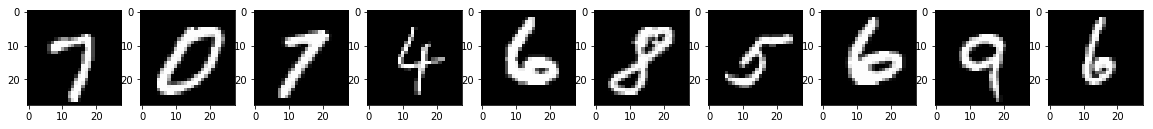

In [5]:
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
data = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

plot_images(plt_num=10, images=data.train_img, dim=20, cmap='gray')

In [6]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    real_images = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_images')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return real_images, z_input, learning_rate

In [7]:
def discriminator(images, reuse, alpha):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Padding = 'Same' -> H_new = H_old // Stride
        # Input Shape: (None, 28, 28, 1)
        
        net = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = leakyReLU(net, alpha)
        # Shape: (None, 16, 16, 128)
        
        net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        # Shape: (None, 8, 8, 128)

        net = tf.layers.flatten(net)
        # Shape: (None, 8*8*128)

        # Dense.
        net = tf.layers.dense(net, 1024, activation=None)
        net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        # Shape: (None, 1024)
        
        # Dense
        logits = tf.layers.dense(net, 1, activation=None)
        # Shape: (None, 1)
        output = tf.nn.sigmoid(logits)
        
        return output, logits

In [8]:
def generator(z_input, out_channel_dim, reuse, is_train, alpha):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully
        net = tf.layers.dense(inputs=z_input, units=1024, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 1024)
        
        # Fully
        net = tf.layers.dense(inputs=net, units=128*7*7, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 128*7*7)
        
        net = tf.reshape(net, (-1, 7, 7, 128))
        # Shape: (None, 7, 7, 128)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 14, 14, 128)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 14, 14, 128)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # Shape: (None, 28, 28, 128)
        
        output = tf.nn.sigmoid(net)
        
        return output

In [9]:
def show_generated(session, output_fake, n_images, z_input, image_type):
    cmap = None if image_type == 'RGB' else 'gray'
    z_dim = z_input.get_shape()[-1]
    sample_z = np.random.uniform(low=-1., high=1., size=(n_images, z_dim))
    feed_dict = {z_input:sample_z}
    gen_samples = session.run(output_fake, feed_dict=feed_dict)
    
    gen_samples *= 255.
    
    plot_images(plt_num=n_images, images=gen_samples, dim=10, cmap=cmap)    

In [10]:
def loss(real_images, z_input, out_channel_dim, alpha):
    
    # Generator.
    fake_images = generator(z_input, out_channel_dim=out_channel_dim, reuse=False, is_train=True, alpha=alpha)
    
    # Discriminator.
    output_fake, logits_fake = discriminator(images=fake_images, reuse=False, alpha=alpha) 
    output_real, logits_real = discriminator(images=real_images, reuse=True, alpha=alpha)
    
    # Discriminator loss.
    loss_dis_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(output_fake)))
    loss_dis_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(output_fake)*0.9))
    loss_dis = loss_dis_fake + loss_dis_real

    # Generator loss.
    # This is where we implement -log[D(G(z))] instead log[1-D(G(z))].
    # Recall the implementation of cross-entropy, sign already in. 
    loss_gen = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(output_fake)))
    
    return loss_dis, loss_gen

In [11]:
def optimization(loss_dis, loss_gen, learning_rate, beta1):
    trainable_variables = tf.trainable_variables()
    generator_variables = [variable for variable in trainable_variables if variable.name.startswith('generator')]
    discriminator_variables = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]
    
    # Handling Batch Normalization.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_generator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                 beta1=beta1).minimize(loss_gen, var_list=generator_variables)
        train_discriminator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                     beta1=beta1).minimize(loss_dis, var_list=discriminator_variables)    
    return train_generator, train_discriminator

In [12]:
def train(epochs, batch_size, z_dim, learning_rate, beta1, dataset, image_type, alpha):
    
    dataset_size, image_width, image_height, image_channels = dataset.data_shape
    
    real_images, z_input, learning_rate_input = model_inputs(image_width=image_width, image_height=image_height, 
                                                            image_channels=image_channels, z_dim=z_dim)
    loss_dis, loss_gen = loss(real_images=real_images, z_input=z_input, out_channel_dim=image_channels, alpha=alpha)
    train_generator, train_discriminator = optimization(loss_dis=loss_dis, loss_gen=loss_gen, learning_rate=learning_rate_input, 
                                                       beta1=beta1)
    
    output_gen = generator(z_input=z_input, out_channel_dim=image_channels, reuse=True, is_train=False, alpha=alpha)

    samples = list()
    losses = list()
    run_epochs = 0
    
    show_epochs = 100
    print_epochs = 10
    n_images = 10
    
    images_e = 0
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epochs+1):
            get_batches = data.batches(batch_size)
            for batch_images, batch_labels in get_batches.__iter__():
                images_e += batch_images.shape[0]
                z_batch = np.random.uniform(low=-1., high=1., size=(batch_size, z_dim))
               
                feed_dict = {z_input:z_batch, real_images:batch_images, learning_rate_input: learning_rate}
                session.run(train_discriminator, feed_dict=feed_dict)
                session.run(train_generator, feed_dict=feed_dict)
               
                if run_epochs%print_epochs==0:
                    feed_dict = {z_input:z_batch, real_images:batch_images}
                    epoch_loss_dis = session.run(loss_dis, feed_dict=feed_dict)
                    epoch_loss_gen = session.run(loss_gen, feed_dict=feed_dict)
                    losses.append((epoch_loss_dis, epoch_loss_gen))
                    print('Epochs %s/%s: Generator Loss: %s. Discriminator Loss: %s' % (epoch, epochs, np.round(epoch_loss_gen, 3), 
                                                                                        np.round(epoch_loss_dis, 3)))
                if run_epochs%show_epochs == 0:
                    show_generated(session=session, output_fake=output_gen, n_images=n_images, z_input=z_input, 
                                   image_type=image_type)
                run_epochs+=1


Epochs 0/10: Generator Loss: 0.822. Discriminator Loss: 1.822


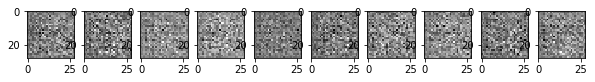

Epochs 0/10: Generator Loss: 0.775. Discriminator Loss: 1.087
Epochs 0/10: Generator Loss: 0.945. Discriminator Loss: 0.965
Epochs 0/10: Generator Loss: 1.042. Discriminator Loss: 0.879
Epochs 0/10: Generator Loss: 1.108. Discriminator Loss: 0.882
Epochs 0/10: Generator Loss: 1.142. Discriminator Loss: 0.848
Epochs 0/10: Generator Loss: 1.198. Discriminator Loss: 0.803
Epochs 0/10: Generator Loss: 1.222. Discriminator Loss: 0.789
Epochs 0/10: Generator Loss: 1.247. Discriminator Loss: 0.837
Epochs 0/10: Generator Loss: 1.19. Discriminator Loss: 0.817
Epochs 0/10: Generator Loss: 1.261. Discriminator Loss: 0.775


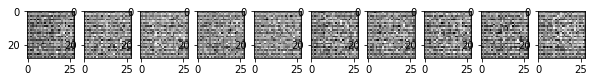

Epochs 0/10: Generator Loss: 1.282. Discriminator Loss: 0.837
Epochs 0/10: Generator Loss: 1.284. Discriminator Loss: 0.768
Epochs 0/10: Generator Loss: 1.302. Discriminator Loss: 0.768
Epochs 0/10: Generator Loss: 1.341. Discriminator Loss: 0.733
Epochs 0/10: Generator Loss: 1.289. Discriminator Loss: 0.77
Epochs 0/10: Generator Loss: 1.313. Discriminator Loss: 0.752
Epochs 0/10: Generator Loss: 1.349. Discriminator Loss: 0.753
Epochs 0/10: Generator Loss: 1.325. Discriminator Loss: 0.806
Epochs 0/10: Generator Loss: 1.286. Discriminator Loss: 0.769
Epochs 0/10: Generator Loss: 1.282. Discriminator Loss: 0.764


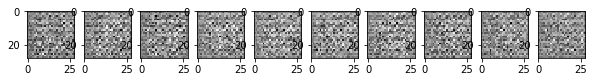

Epochs 0/10: Generator Loss: 1.337. Discriminator Loss: 0.724
Epochs 0/10: Generator Loss: 1.334. Discriminator Loss: 0.755
Epochs 0/10: Generator Loss: 1.339. Discriminator Loss: 0.74
Epochs 0/10: Generator Loss: 1.378. Discriminator Loss: 0.727
Epochs 0/10: Generator Loss: 1.37. Discriminator Loss: 0.754
Epochs 0/10: Generator Loss: 1.399. Discriminator Loss: 0.733
Epochs 0/10: Generator Loss: 1.432. Discriminator Loss: 0.689
Epochs 0/10: Generator Loss: 1.429. Discriminator Loss: 0.723
Epochs 0/10: Generator Loss: 1.411. Discriminator Loss: 0.722
Epochs 0/10: Generator Loss: 1.421. Discriminator Loss: 0.714


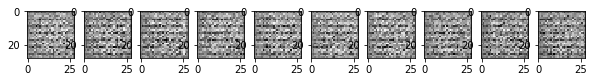

Epochs 0/10: Generator Loss: 1.43. Discriminator Loss: 0.696
Epochs 0/10: Generator Loss: 1.454. Discriminator Loss: 0.702
Epochs 0/10: Generator Loss: 1.439. Discriminator Loss: 0.699
Epochs 0/10: Generator Loss: 1.422. Discriminator Loss: 0.738
Epochs 0/10: Generator Loss: 1.434. Discriminator Loss: 0.707
Epochs 0/10: Generator Loss: 1.437. Discriminator Loss: 0.74
Epochs 0/10: Generator Loss: 1.47. Discriminator Loss: 0.685
Epochs 0/10: Generator Loss: 1.476. Discriminator Loss: 0.688
Epochs 0/10: Generator Loss: 1.498. Discriminator Loss: 0.688
Epochs 0/10: Generator Loss: 1.509. Discriminator Loss: 0.66


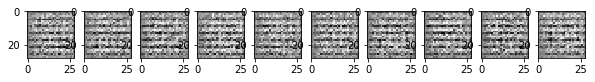

Epochs 0/10: Generator Loss: 1.535. Discriminator Loss: 0.65
Epochs 0/10: Generator Loss: 1.541. Discriminator Loss: 0.665
Epochs 0/10: Generator Loss: 1.566. Discriminator Loss: 0.641
Epochs 0/10: Generator Loss: 1.531. Discriminator Loss: 0.716
Epochs 0/10: Generator Loss: 1.622. Discriminator Loss: 0.638
Epochs 0/10: Generator Loss: 1.567. Discriminator Loss: 0.673
Epochs 0/10: Generator Loss: 1.571. Discriminator Loss: 0.659
Epochs 0/10: Generator Loss: 1.507. Discriminator Loss: 0.704
Epochs 0/10: Generator Loss: 1.543. Discriminator Loss: 0.654
Epochs 0/10: Generator Loss: 1.534. Discriminator Loss: 0.666


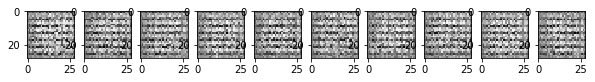

Epochs 0/10: Generator Loss: 1.578. Discriminator Loss: 0.651
Epochs 0/10: Generator Loss: 1.584. Discriminator Loss: 0.643
Epochs 0/10: Generator Loss: 1.526. Discriminator Loss: 0.642
Epochs 0/10: Generator Loss: 1.621. Discriminator Loss: 0.647
Epochs 0/10: Generator Loss: 1.655. Discriminator Loss: 0.607
Epochs 0/10: Generator Loss: 1.594. Discriminator Loss: 0.631
Epochs 0/10: Generator Loss: 1.596. Discriminator Loss: 0.629
Epochs 0/10: Generator Loss: 1.66. Discriminator Loss: 0.619
Epochs 0/10: Generator Loss: 1.689. Discriminator Loss: 0.607
Epochs 0/10: Generator Loss: 1.663. Discriminator Loss: 0.625


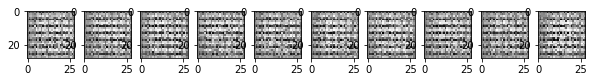

Epochs 0/10: Generator Loss: 1.538. Discriminator Loss: 0.674
Epochs 0/10: Generator Loss: 1.644. Discriminator Loss: 0.646
Epochs 0/10: Generator Loss: 1.631. Discriminator Loss: 0.607
Epochs 0/10: Generator Loss: 1.598. Discriminator Loss: 0.643
Epochs 0/10: Generator Loss: 1.726. Discriminator Loss: 0.601
Epochs 0/10: Generator Loss: 1.696. Discriminator Loss: 0.599
Epochs 0/10: Generator Loss: 1.745. Discriminator Loss: 0.582
Epochs 0/10: Generator Loss: 1.576. Discriminator Loss: 0.636
Epochs 0/10: Generator Loss: 1.71. Discriminator Loss: 0.642
Epochs 0/10: Generator Loss: 1.668. Discriminator Loss: 0.636


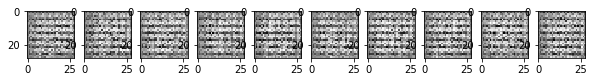

Epochs 0/10: Generator Loss: 1.746. Discriminator Loss: 0.586
Epochs 0/10: Generator Loss: 1.768. Discriminator Loss: 0.578
Epochs 0/10: Generator Loss: 1.796. Discriminator Loss: 0.564
Epochs 0/10: Generator Loss: 1.76. Discriminator Loss: 0.578
Epochs 0/10: Generator Loss: 1.764. Discriminator Loss: 0.602
Epochs 0/10: Generator Loss: 1.696. Discriminator Loss: 0.63
Epochs 0/10: Generator Loss: 1.703. Discriminator Loss: 0.61
Epochs 0/10: Generator Loss: 1.767. Discriminator Loss: 0.576
Epochs 0/10: Generator Loss: 1.847. Discriminator Loss: 0.563
Epochs 0/10: Generator Loss: 1.923. Discriminator Loss: 0.539


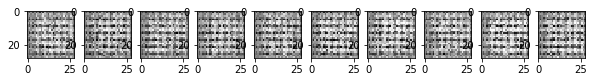

Epochs 0/10: Generator Loss: 1.903. Discriminator Loss: 0.638
Epochs 0/10: Generator Loss: 1.859. Discriminator Loss: 0.552
Epochs 0/10: Generator Loss: 1.824. Discriminator Loss: 0.559
Epochs 0/10: Generator Loss: 1.792. Discriminator Loss: 0.575
Epochs 0/10: Generator Loss: 1.794. Discriminator Loss: 0.578
Epochs 0/10: Generator Loss: 1.836. Discriminator Loss: 0.563
Epochs 0/10: Generator Loss: 1.83. Discriminator Loss: 0.623
Epochs 0/10: Generator Loss: 1.893. Discriminator Loss: 0.582
Epochs 0/10: Generator Loss: 1.772. Discriminator Loss: 0.591
Epochs 0/10: Generator Loss: 1.819. Discriminator Loss: 0.553


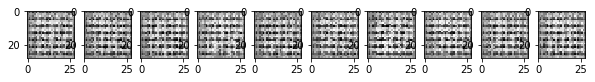

Epochs 0/10: Generator Loss: 1.965. Discriminator Loss: 0.61
Epochs 0/10: Generator Loss: 1.863. Discriminator Loss: 0.582
Epochs 0/10: Generator Loss: 1.914. Discriminator Loss: 0.542
Epochs 0/10: Generator Loss: 2.069. Discriminator Loss: 0.525
Epochs 0/10: Generator Loss: 1.875. Discriminator Loss: 0.524
Epochs 0/10: Generator Loss: 2.05. Discriminator Loss: 0.507
Epochs 0/10: Generator Loss: 2.081. Discriminator Loss: 0.512
Epochs 0/10: Generator Loss: 1.793. Discriminator Loss: 0.597
Epochs 0/10: Generator Loss: 1.81. Discriminator Loss: 0.536
Epochs 0/10: Generator Loss: 1.843. Discriminator Loss: 0.705


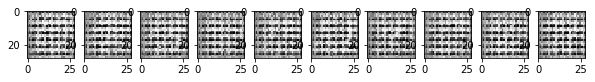

Epochs 0/10: Generator Loss: 2.012. Discriminator Loss: 0.515
Epochs 0/10: Generator Loss: 2.005. Discriminator Loss: 0.526
Epochs 0/10: Generator Loss: 1.773. Discriminator Loss: 0.612
Epochs 0/10: Generator Loss: 1.717. Discriminator Loss: 0.589
Epochs 0/10: Generator Loss: 1.646. Discriminator Loss: 0.623
Epochs 0/10: Generator Loss: 1.882. Discriminator Loss: 0.595
Epochs 0/10: Generator Loss: 1.763. Discriminator Loss: 0.612
Epochs 0/10: Generator Loss: 1.723. Discriminator Loss: 0.592
Epochs 0/10: Generator Loss: 1.883. Discriminator Loss: 0.541
Epochs 0/10: Generator Loss: 1.919. Discriminator Loss: 0.565


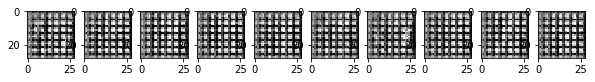

Epochs 0/10: Generator Loss: 1.985. Discriminator Loss: 0.542
Epochs 0/10: Generator Loss: 1.999. Discriminator Loss: 0.546
Epochs 0/10: Generator Loss: 1.761. Discriminator Loss: 0.585
Epochs 0/10: Generator Loss: 1.916. Discriminator Loss: 0.532
Epochs 0/10: Generator Loss: 1.929. Discriminator Loss: 0.572
Epochs 0/10: Generator Loss: 1.787. Discriminator Loss: 0.613
Epochs 0/10: Generator Loss: 1.693. Discriminator Loss: 0.605
Epochs 0/10: Generator Loss: 1.709. Discriminator Loss: 0.629
Epochs 0/10: Generator Loss: 1.815. Discriminator Loss: 0.562
Epochs 0/10: Generator Loss: 1.72. Discriminator Loss: 0.8


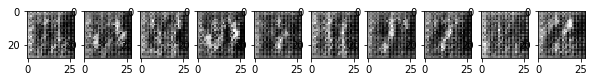

Epochs 0/10: Generator Loss: 2.22. Discriminator Loss: 0.798
Epochs 0/10: Generator Loss: 1.793. Discriminator Loss: 0.613
Epochs 0/10: Generator Loss: 1.63. Discriminator Loss: 0.65
Epochs 0/10: Generator Loss: 1.594. Discriminator Loss: 0.645
Epochs 0/10: Generator Loss: 1.878. Discriminator Loss: 0.59
Epochs 0/10: Generator Loss: 1.867. Discriminator Loss: 0.75
Epochs 0/10: Generator Loss: 1.735. Discriminator Loss: 0.629
Epochs 0/10: Generator Loss: 1.692. Discriminator Loss: 0.81
Epochs 0/10: Generator Loss: 1.59. Discriminator Loss: 0.717
Epochs 0/10: Generator Loss: 1.556. Discriminator Loss: 0.658


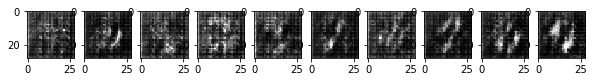

Epochs 0/10: Generator Loss: 1.731. Discriminator Loss: 0.598
Epochs 0/10: Generator Loss: 1.799. Discriminator Loss: 0.661
Epochs 0/10: Generator Loss: 1.871. Discriminator Loss: 0.76
Epochs 0/10: Generator Loss: 1.629. Discriminator Loss: 0.805
Epochs 0/10: Generator Loss: 1.49. Discriminator Loss: 0.665
Epochs 0/10: Generator Loss: 1.424. Discriminator Loss: 0.779
Epochs 0/10: Generator Loss: 1.492. Discriminator Loss: 0.752
Epochs 0/10: Generator Loss: 1.469. Discriminator Loss: 0.712
Epochs 0/10: Generator Loss: 1.767. Discriminator Loss: 0.838
Epochs 0/10: Generator Loss: 1.485. Discriminator Loss: 0.701


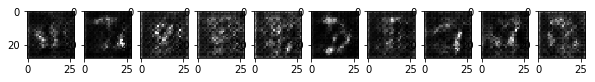

Epochs 0/10: Generator Loss: 1.691. Discriminator Loss: 0.667
Epochs 0/10: Generator Loss: 1.731. Discriminator Loss: 0.613
Epochs 0/10: Generator Loss: 1.724. Discriminator Loss: 0.591
Epochs 0/10: Generator Loss: 1.756. Discriminator Loss: 0.692
Epochs 0/10: Generator Loss: 1.775. Discriminator Loss: 0.654
Epochs 0/10: Generator Loss: 1.656. Discriminator Loss: 0.646
Epochs 0/10: Generator Loss: 1.86. Discriminator Loss: 0.861
Epochs 0/10: Generator Loss: 1.664. Discriminator Loss: 0.666
Epochs 0/10: Generator Loss: 1.548. Discriminator Loss: 0.692
Epochs 0/10: Generator Loss: 1.771. Discriminator Loss: 0.613


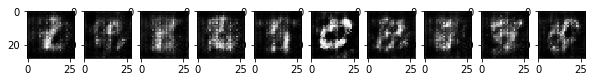

Epochs 0/10: Generator Loss: 1.63. Discriminator Loss: 0.672
Epochs 0/10: Generator Loss: 1.743. Discriminator Loss: 0.638
Epochs 0/10: Generator Loss: 1.801. Discriminator Loss: 0.678
Epochs 0/10: Generator Loss: 1.865. Discriminator Loss: 0.606
Epochs 0/10: Generator Loss: 1.691. Discriminator Loss: 0.638
Epochs 0/10: Generator Loss: 1.73. Discriminator Loss: 0.682
Epochs 0/10: Generator Loss: 1.797. Discriminator Loss: 0.594
Epochs 0/10: Generator Loss: 1.707. Discriminator Loss: 0.644
Epochs 0/10: Generator Loss: 1.678. Discriminator Loss: 0.634
Epochs 0/10: Generator Loss: 1.821. Discriminator Loss: 0.681


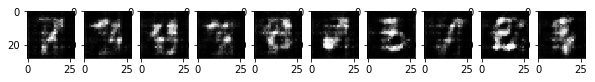

Epochs 0/10: Generator Loss: 1.742. Discriminator Loss: 0.627
Epochs 0/10: Generator Loss: 1.731. Discriminator Loss: 0.591
Epochs 0/10: Generator Loss: 1.756. Discriminator Loss: 0.643
Epochs 0/10: Generator Loss: 1.721. Discriminator Loss: 0.593
Epochs 0/10: Generator Loss: 1.805. Discriminator Loss: 0.625
Epochs 0/10: Generator Loss: 1.542. Discriminator Loss: 0.674
Epochs 0/10: Generator Loss: 1.756. Discriminator Loss: 0.619
Epochs 0/10: Generator Loss: 1.666. Discriminator Loss: 0.628
Epochs 0/10: Generator Loss: 1.922. Discriminator Loss: 0.572
Epochs 0/10: Generator Loss: 1.799. Discriminator Loss: 0.558


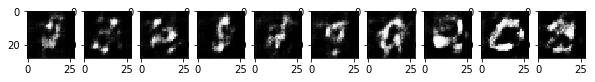

Epochs 0/10: Generator Loss: 1.839. Discriminator Loss: 0.683
Epochs 0/10: Generator Loss: 1.746. Discriminator Loss: 0.615
Epochs 0/10: Generator Loss: 1.767. Discriminator Loss: 0.597
Epochs 0/10: Generator Loss: 1.815. Discriminator Loss: 0.577
Epochs 0/10: Generator Loss: 1.714. Discriminator Loss: 0.68
Epochs 0/10: Generator Loss: 1.824. Discriminator Loss: 0.601
Epochs 0/10: Generator Loss: 1.836. Discriminator Loss: 0.588
Epochs 0/10: Generator Loss: 1.959. Discriminator Loss: 0.733
Epochs 0/10: Generator Loss: 1.747. Discriminator Loss: 0.603
Epochs 0/10: Generator Loss: 1.834. Discriminator Loss: 0.666


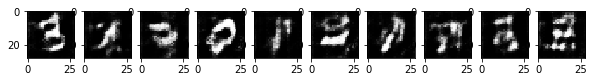

Epochs 0/10: Generator Loss: 1.815. Discriminator Loss: 0.584
Epochs 0/10: Generator Loss: 1.783. Discriminator Loss: 0.607
Epochs 0/10: Generator Loss: 1.953. Discriminator Loss: 0.599
Epochs 0/10: Generator Loss: 1.764. Discriminator Loss: 0.587
Epochs 0/10: Generator Loss: 1.489. Discriminator Loss: 0.691
Epochs 0/10: Generator Loss: 1.79. Discriminator Loss: 0.637
Epochs 0/10: Generator Loss: 1.709. Discriminator Loss: 0.591
Epochs 1/10: Generator Loss: 1.363. Discriminator Loss: 0.785
Epochs 1/10: Generator Loss: 1.679. Discriminator Loss: 0.609
Epochs 1/10: Generator Loss: 1.715. Discriminator Loss: 0.623


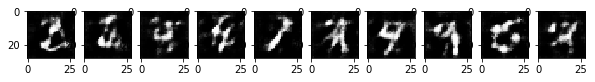

Epochs 1/10: Generator Loss: 1.633. Discriminator Loss: 0.661
Epochs 1/10: Generator Loss: 1.768. Discriminator Loss: 0.611
Epochs 1/10: Generator Loss: 1.872. Discriminator Loss: 0.571
Epochs 1/10: Generator Loss: 1.574. Discriminator Loss: 0.633
Epochs 1/10: Generator Loss: 1.914. Discriminator Loss: 0.649
Epochs 1/10: Generator Loss: 1.744. Discriminator Loss: 0.682
Epochs 1/10: Generator Loss: 1.802. Discriminator Loss: 0.575
Epochs 1/10: Generator Loss: 1.8. Discriminator Loss: 0.632
Epochs 1/10: Generator Loss: 1.879. Discriminator Loss: 0.723
Epochs 1/10: Generator Loss: 1.904. Discriminator Loss: 0.592


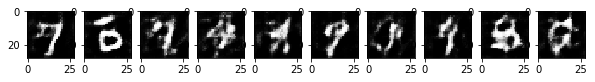

Epochs 1/10: Generator Loss: 1.844. Discriminator Loss: 0.594
Epochs 1/10: Generator Loss: 1.966. Discriminator Loss: 0.651
Epochs 1/10: Generator Loss: 1.92. Discriminator Loss: 0.599
Epochs 1/10: Generator Loss: 1.805. Discriminator Loss: 0.572
Epochs 1/10: Generator Loss: 1.83. Discriminator Loss: 0.586
Epochs 1/10: Generator Loss: 1.705. Discriminator Loss: 0.667
Epochs 1/10: Generator Loss: 1.737. Discriminator Loss: 0.604
Epochs 1/10: Generator Loss: 1.755. Discriminator Loss: 0.719
Epochs 1/10: Generator Loss: 1.772. Discriminator Loss: 0.58
Epochs 1/10: Generator Loss: 1.843. Discriminator Loss: 0.583


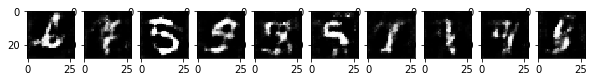

Epochs 1/10: Generator Loss: 1.771. Discriminator Loss: 0.631
Epochs 1/10: Generator Loss: 1.801. Discriminator Loss: 0.715
Epochs 1/10: Generator Loss: 1.761. Discriminator Loss: 0.695
Epochs 1/10: Generator Loss: 1.657. Discriminator Loss: 0.622
Epochs 1/10: Generator Loss: 1.844. Discriminator Loss: 0.611
Epochs 1/10: Generator Loss: 1.766. Discriminator Loss: 0.589
Epochs 1/10: Generator Loss: 1.751. Discriminator Loss: 0.625
Epochs 1/10: Generator Loss: 1.904. Discriminator Loss: 0.571
Epochs 1/10: Generator Loss: 1.846. Discriminator Loss: 0.654
Epochs 1/10: Generator Loss: 1.891. Discriminator Loss: 0.58


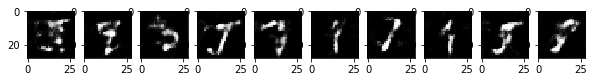

Epochs 1/10: Generator Loss: 1.83. Discriminator Loss: 0.631
Epochs 1/10: Generator Loss: 1.762. Discriminator Loss: 0.599
Epochs 1/10: Generator Loss: 1.758. Discriminator Loss: 0.595
Epochs 1/10: Generator Loss: 1.813. Discriminator Loss: 0.628
Epochs 1/10: Generator Loss: 1.733. Discriminator Loss: 0.661
Epochs 1/10: Generator Loss: 1.864. Discriminator Loss: 0.629
Epochs 1/10: Generator Loss: 1.809. Discriminator Loss: 0.628
Epochs 1/10: Generator Loss: 1.908. Discriminator Loss: 0.579
Epochs 1/10: Generator Loss: 1.76. Discriminator Loss: 0.578
Epochs 1/10: Generator Loss: 1.731. Discriminator Loss: 0.61


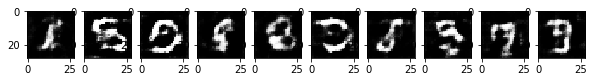

Epochs 1/10: Generator Loss: 1.848. Discriminator Loss: 0.563
Epochs 1/10: Generator Loss: 1.784. Discriminator Loss: 0.611
Epochs 1/10: Generator Loss: 1.854. Discriminator Loss: 0.609
Epochs 1/10: Generator Loss: 1.741. Discriminator Loss: 0.702
Epochs 1/10: Generator Loss: 1.794. Discriminator Loss: 0.605
Epochs 1/10: Generator Loss: 1.808. Discriminator Loss: 0.626
Epochs 1/10: Generator Loss: 1.711. Discriminator Loss: 0.641
Epochs 1/10: Generator Loss: 1.748. Discriminator Loss: 0.598
Epochs 1/10: Generator Loss: 1.92. Discriminator Loss: 0.588
Epochs 1/10: Generator Loss: 1.796. Discriminator Loss: 0.604


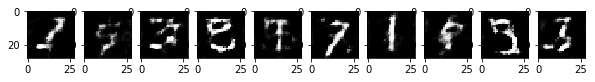

Epochs 1/10: Generator Loss: 1.829. Discriminator Loss: 0.641
Epochs 1/10: Generator Loss: 1.896. Discriminator Loss: 0.58
Epochs 1/10: Generator Loss: 1.749. Discriminator Loss: 0.622
Epochs 1/10: Generator Loss: 1.863. Discriminator Loss: 0.566
Epochs 1/10: Generator Loss: 1.759. Discriminator Loss: 0.685
Epochs 1/10: Generator Loss: 1.816. Discriminator Loss: 0.574
Epochs 1/10: Generator Loss: 1.607. Discriminator Loss: 0.654
Epochs 1/10: Generator Loss: 1.7. Discriminator Loss: 0.687
Epochs 1/10: Generator Loss: 1.661. Discriminator Loss: 0.633
Epochs 1/10: Generator Loss: 1.731. Discriminator Loss: 0.621


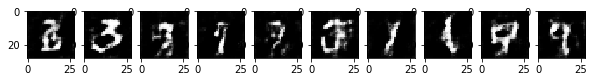

Epochs 1/10: Generator Loss: 1.672. Discriminator Loss: 0.671
Epochs 1/10: Generator Loss: 1.704. Discriminator Loss: 0.59
Epochs 1/10: Generator Loss: 1.766. Discriminator Loss: 0.606
Epochs 1/10: Generator Loss: 1.911. Discriminator Loss: 0.578
Epochs 1/10: Generator Loss: 1.831. Discriminator Loss: 0.806
Epochs 1/10: Generator Loss: 1.979. Discriminator Loss: 0.633
Epochs 1/10: Generator Loss: 1.629. Discriminator Loss: 0.694
Epochs 1/10: Generator Loss: 1.836. Discriminator Loss: 0.608
Epochs 1/10: Generator Loss: 1.756. Discriminator Loss: 0.636
Epochs 1/10: Generator Loss: 1.845. Discriminator Loss: 0.594


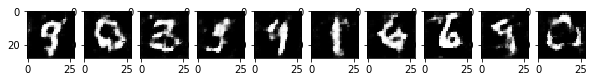

Epochs 1/10: Generator Loss: 1.877. Discriminator Loss: 0.686
Epochs 1/10: Generator Loss: 1.675. Discriminator Loss: 0.647
Epochs 1/10: Generator Loss: 1.82. Discriminator Loss: 0.589
Epochs 1/10: Generator Loss: 1.965. Discriminator Loss: 0.58
Epochs 1/10: Generator Loss: 1.965. Discriminator Loss: 0.578
Epochs 1/10: Generator Loss: 1.865. Discriminator Loss: 0.621
Epochs 1/10: Generator Loss: 1.826. Discriminator Loss: 0.653
Epochs 1/10: Generator Loss: 1.775. Discriminator Loss: 0.613
Epochs 1/10: Generator Loss: 1.89. Discriminator Loss: 0.63
Epochs 1/10: Generator Loss: 1.764. Discriminator Loss: 0.623


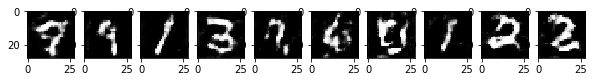

Epochs 1/10: Generator Loss: 1.925. Discriminator Loss: 0.584
Epochs 1/10: Generator Loss: 1.815. Discriminator Loss: 0.59
Epochs 1/10: Generator Loss: 1.692. Discriminator Loss: 0.674
Epochs 1/10: Generator Loss: 1.808. Discriminator Loss: 0.594
Epochs 1/10: Generator Loss: 1.841. Discriminator Loss: 0.601
Epochs 1/10: Generator Loss: 1.883. Discriminator Loss: 0.599
Epochs 1/10: Generator Loss: 1.896. Discriminator Loss: 0.584
Epochs 1/10: Generator Loss: 1.878. Discriminator Loss: 0.61
Epochs 1/10: Generator Loss: 1.848. Discriminator Loss: 0.651
Epochs 1/10: Generator Loss: 1.939. Discriminator Loss: 0.591


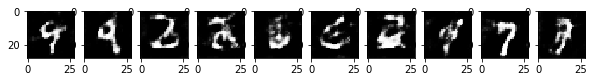

Epochs 1/10: Generator Loss: 1.709. Discriminator Loss: 0.597
Epochs 1/10: Generator Loss: 1.704. Discriminator Loss: 0.608
Epochs 1/10: Generator Loss: 1.801. Discriminator Loss: 0.594
Epochs 1/10: Generator Loss: 1.875. Discriminator Loss: 0.577
Epochs 1/10: Generator Loss: 1.726. Discriminator Loss: 0.61
Epochs 1/10: Generator Loss: 1.744. Discriminator Loss: 0.601
Epochs 1/10: Generator Loss: 1.823. Discriminator Loss: 0.795
Epochs 1/10: Generator Loss: 1.806. Discriminator Loss: 0.603
Epochs 1/10: Generator Loss: 1.86. Discriminator Loss: 0.599
Epochs 1/10: Generator Loss: 1.844. Discriminator Loss: 0.622


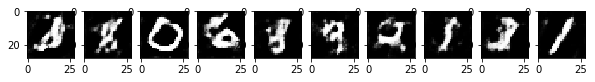

Epochs 1/10: Generator Loss: 1.933. Discriminator Loss: 0.625
Epochs 1/10: Generator Loss: 1.808. Discriminator Loss: 0.629
Epochs 1/10: Generator Loss: 1.772. Discriminator Loss: 0.614
Epochs 1/10: Generator Loss: 1.787. Discriminator Loss: 0.626
Epochs 1/10: Generator Loss: 1.814. Discriminator Loss: 0.638
Epochs 1/10: Generator Loss: 1.674. Discriminator Loss: 0.632
Epochs 1/10: Generator Loss: 1.713. Discriminator Loss: 0.62
Epochs 1/10: Generator Loss: 1.783. Discriminator Loss: 0.667
Epochs 1/10: Generator Loss: 2.028. Discriminator Loss: 0.6
Epochs 1/10: Generator Loss: 1.982. Discriminator Loss: 0.56


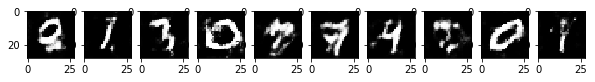

Epochs 1/10: Generator Loss: 1.812. Discriminator Loss: 0.574
Epochs 1/10: Generator Loss: 2.012. Discriminator Loss: 0.54
Epochs 1/10: Generator Loss: 1.939. Discriminator Loss: 0.578
Epochs 1/10: Generator Loss: 1.671. Discriminator Loss: 0.627
Epochs 1/10: Generator Loss: 1.921. Discriminator Loss: 0.566
Epochs 1/10: Generator Loss: 1.863. Discriminator Loss: 0.599
Epochs 1/10: Generator Loss: 1.825. Discriminator Loss: 0.571
Epochs 1/10: Generator Loss: 2.053. Discriminator Loss: 0.529
Epochs 1/10: Generator Loss: 1.958. Discriminator Loss: 0.558
Epochs 1/10: Generator Loss: 1.794. Discriminator Loss: 0.582


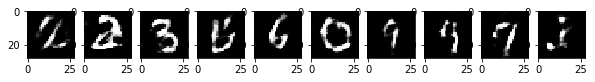

Epochs 1/10: Generator Loss: 2.049. Discriminator Loss: 0.551
Epochs 1/10: Generator Loss: 2.019. Discriminator Loss: 0.55
Epochs 1/10: Generator Loss: 1.841. Discriminator Loss: 0.651
Epochs 1/10: Generator Loss: 2.06. Discriminator Loss: 0.538
Epochs 1/10: Generator Loss: 1.886. Discriminator Loss: 0.566
Epochs 1/10: Generator Loss: 1.935. Discriminator Loss: 0.668
Epochs 1/10: Generator Loss: 1.88. Discriminator Loss: 0.574
Epochs 1/10: Generator Loss: 1.952. Discriminator Loss: 0.571
Epochs 1/10: Generator Loss: 1.979. Discriminator Loss: 0.588
Epochs 1/10: Generator Loss: 1.878. Discriminator Loss: 0.679


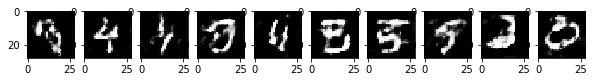

Epochs 1/10: Generator Loss: 2.076. Discriminator Loss: 0.652
Epochs 1/10: Generator Loss: 2.019. Discriminator Loss: 0.699
Epochs 1/10: Generator Loss: 1.863. Discriminator Loss: 0.593
Epochs 1/10: Generator Loss: 1.96. Discriminator Loss: 0.54
Epochs 1/10: Generator Loss: 1.83. Discriminator Loss: 0.583
Epochs 1/10: Generator Loss: 1.916. Discriminator Loss: 0.563
Epochs 1/10: Generator Loss: 1.861. Discriminator Loss: 0.584
Epochs 1/10: Generator Loss: 1.776. Discriminator Loss: 0.608
Epochs 1/10: Generator Loss: 1.801. Discriminator Loss: 0.574
Epochs 1/10: Generator Loss: 1.886. Discriminator Loss: 0.546


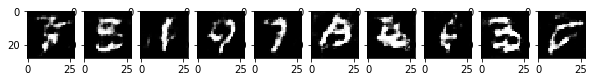

Epochs 1/10: Generator Loss: 1.839. Discriminator Loss: 0.617
Epochs 1/10: Generator Loss: 1.95. Discriminator Loss: 0.543
Epochs 1/10: Generator Loss: 1.939. Discriminator Loss: 0.597
Epochs 1/10: Generator Loss: 1.819. Discriminator Loss: 0.599
Epochs 1/10: Generator Loss: 1.939. Discriminator Loss: 0.573
Epochs 1/10: Generator Loss: 1.949. Discriminator Loss: 0.551
Epochs 1/10: Generator Loss: 1.888. Discriminator Loss: 0.585
Epochs 1/10: Generator Loss: 1.981. Discriminator Loss: 0.56
Epochs 1/10: Generator Loss: 1.964. Discriminator Loss: 0.575
Epochs 1/10: Generator Loss: 1.896. Discriminator Loss: 0.58


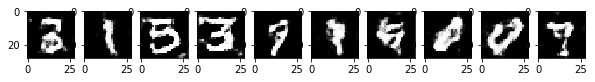

Epochs 1/10: Generator Loss: 1.899. Discriminator Loss: 0.59
Epochs 1/10: Generator Loss: 2.037. Discriminator Loss: 0.55
Epochs 1/10: Generator Loss: 1.872. Discriminator Loss: 0.597
Epochs 1/10: Generator Loss: 1.8. Discriminator Loss: 0.603
Epochs 1/10: Generator Loss: 1.919. Discriminator Loss: 0.596
Epochs 1/10: Generator Loss: 1.891. Discriminator Loss: 0.584
Epochs 1/10: Generator Loss: 1.867. Discriminator Loss: 0.561
Epochs 1/10: Generator Loss: 1.728. Discriminator Loss: 0.635
Epochs 1/10: Generator Loss: 1.904. Discriminator Loss: 0.56
Epochs 1/10: Generator Loss: 1.805. Discriminator Loss: 0.681


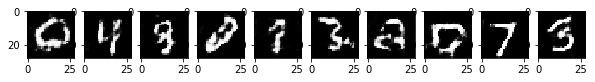

Epochs 1/10: Generator Loss: 1.802. Discriminator Loss: 0.589
Epochs 1/10: Generator Loss: 1.676. Discriminator Loss: 0.627
Epochs 1/10: Generator Loss: 1.856. Discriminator Loss: 0.572
Epochs 1/10: Generator Loss: 1.775. Discriminator Loss: 0.63
Epochs 1/10: Generator Loss: 1.836. Discriminator Loss: 0.656
Epochs 1/10: Generator Loss: 2.013. Discriminator Loss: 0.534
Epochs 1/10: Generator Loss: 1.983. Discriminator Loss: 0.568
Epochs 1/10: Generator Loss: 1.987. Discriminator Loss: 0.535
Epochs 1/10: Generator Loss: 1.972. Discriminator Loss: 0.541
Epochs 1/10: Generator Loss: 1.992. Discriminator Loss: 0.526


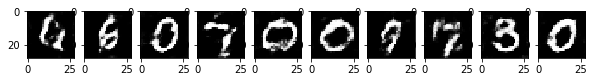

Epochs 1/10: Generator Loss: 1.836. Discriminator Loss: 0.567
Epochs 1/10: Generator Loss: 1.962. Discriminator Loss: 0.738
Epochs 1/10: Generator Loss: 1.942. Discriminator Loss: 0.609
Epochs 1/10: Generator Loss: 1.965. Discriminator Loss: 0.575
Epochs 1/10: Generator Loss: 2.068. Discriminator Loss: 0.635
Epochs 1/10: Generator Loss: 1.987. Discriminator Loss: 0.546
Epochs 1/10: Generator Loss: 2.038. Discriminator Loss: 0.729
Epochs 1/10: Generator Loss: 2.008. Discriminator Loss: 0.565
Epochs 1/10: Generator Loss: 2.071. Discriminator Loss: 0.547
Epochs 1/10: Generator Loss: 1.819. Discriminator Loss: 0.601


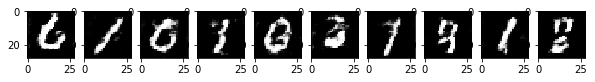

Epochs 1/10: Generator Loss: 1.874. Discriminator Loss: 0.599
Epochs 1/10: Generator Loss: 1.96. Discriminator Loss: 0.557
Epochs 1/10: Generator Loss: 2.008. Discriminator Loss: 0.574
Epochs 1/10: Generator Loss: 1.988. Discriminator Loss: 0.547
Epochs 2/10: Generator Loss: 1.802. Discriminator Loss: 1.332
Epochs 2/10: Generator Loss: 1.893. Discriminator Loss: 0.587
Epochs 2/10: Generator Loss: 1.843. Discriminator Loss: 0.573
Epochs 2/10: Generator Loss: 1.775. Discriminator Loss: 0.6
Epochs 2/10: Generator Loss: 1.946. Discriminator Loss: 0.563
Epochs 2/10: Generator Loss: 1.853. Discriminator Loss: 0.582


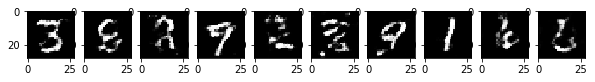

Epochs 2/10: Generator Loss: 1.768. Discriminator Loss: 0.595
Epochs 2/10: Generator Loss: 1.954. Discriminator Loss: 0.541
Epochs 2/10: Generator Loss: 1.898. Discriminator Loss: 0.549
Epochs 2/10: Generator Loss: 1.918. Discriminator Loss: 0.584
Epochs 2/10: Generator Loss: 2.01. Discriminator Loss: 0.534
Epochs 2/10: Generator Loss: 1.999. Discriminator Loss: 0.54
Epochs 2/10: Generator Loss: 2.081. Discriminator Loss: 0.532
Epochs 2/10: Generator Loss: 1.977. Discriminator Loss: 0.562
Epochs 2/10: Generator Loss: 2.025. Discriminator Loss: 0.542
Epochs 2/10: Generator Loss: 1.893. Discriminator Loss: 0.579


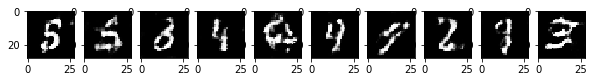

Epochs 2/10: Generator Loss: 1.982. Discriminator Loss: 0.547
Epochs 2/10: Generator Loss: 2.005. Discriminator Loss: 0.536
Epochs 2/10: Generator Loss: 1.846. Discriminator Loss: 0.691
Epochs 2/10: Generator Loss: 1.852. Discriminator Loss: 0.581
Epochs 2/10: Generator Loss: 2.006. Discriminator Loss: 0.539
Epochs 2/10: Generator Loss: 1.98. Discriminator Loss: 0.528
Epochs 2/10: Generator Loss: 2.141. Discriminator Loss: 0.567
Epochs 2/10: Generator Loss: 2.069. Discriminator Loss: 0.553
Epochs 2/10: Generator Loss: 1.871. Discriminator Loss: 0.594
Epochs 2/10: Generator Loss: 1.844. Discriminator Loss: 0.579


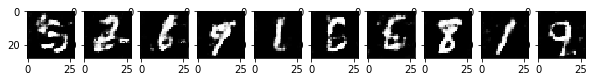

Epochs 2/10: Generator Loss: 1.937. Discriminator Loss: 0.553
Epochs 2/10: Generator Loss: 2.068. Discriminator Loss: 0.52
Epochs 2/10: Generator Loss: 1.926. Discriminator Loss: 0.631
Epochs 2/10: Generator Loss: 1.871. Discriminator Loss: 0.558
Epochs 2/10: Generator Loss: 2.147. Discriminator Loss: 0.519
Epochs 2/10: Generator Loss: 2.206. Discriminator Loss: 0.514
Epochs 2/10: Generator Loss: 2.053. Discriminator Loss: 0.544
Epochs 2/10: Generator Loss: 1.986. Discriminator Loss: 0.54
Epochs 2/10: Generator Loss: 1.811. Discriminator Loss: 0.619
Epochs 2/10: Generator Loss: 1.762. Discriminator Loss: 0.611


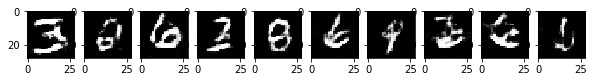

Epochs 2/10: Generator Loss: 1.935. Discriminator Loss: 0.575
Epochs 2/10: Generator Loss: 1.942. Discriminator Loss: 0.562
Epochs 2/10: Generator Loss: 2.149. Discriminator Loss: 0.556
Epochs 2/10: Generator Loss: 1.988. Discriminator Loss: 0.561
Epochs 2/10: Generator Loss: 1.858. Discriminator Loss: 0.556
Epochs 2/10: Generator Loss: 1.941. Discriminator Loss: 0.575
Epochs 2/10: Generator Loss: 2.224. Discriminator Loss: 0.553
Epochs 2/10: Generator Loss: 2.047. Discriminator Loss: 0.508
Epochs 2/10: Generator Loss: 2.023. Discriminator Loss: 0.643
Epochs 2/10: Generator Loss: 1.984. Discriminator Loss: 0.546


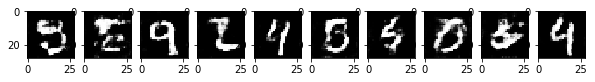

Epochs 2/10: Generator Loss: 2.036. Discriminator Loss: 0.531
Epochs 2/10: Generator Loss: 1.859. Discriminator Loss: 0.569
Epochs 2/10: Generator Loss: 2.084. Discriminator Loss: 0.559
Epochs 2/10: Generator Loss: 1.961. Discriminator Loss: 0.57
Epochs 2/10: Generator Loss: 2.165. Discriminator Loss: 0.511
Epochs 2/10: Generator Loss: 2.052. Discriminator Loss: 0.573
Epochs 2/10: Generator Loss: 2.06. Discriminator Loss: 0.539
Epochs 2/10: Generator Loss: 1.929. Discriminator Loss: 0.542
Epochs 2/10: Generator Loss: 1.906. Discriminator Loss: 0.573
Epochs 2/10: Generator Loss: 2.154. Discriminator Loss: 0.502


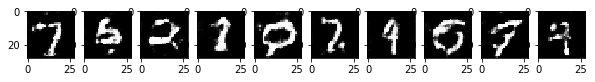

Epochs 2/10: Generator Loss: 1.963. Discriminator Loss: 0.554
Epochs 2/10: Generator Loss: 2.072. Discriminator Loss: 0.523
Epochs 2/10: Generator Loss: 2.129. Discriminator Loss: 0.523
Epochs 2/10: Generator Loss: 2.14. Discriminator Loss: 0.539
Epochs 2/10: Generator Loss: 2.067. Discriminator Loss: 0.549
Epochs 2/10: Generator Loss: 2.079. Discriminator Loss: 0.528
Epochs 2/10: Generator Loss: 2.039. Discriminator Loss: 0.541
Epochs 2/10: Generator Loss: 2.118. Discriminator Loss: 0.521
Epochs 2/10: Generator Loss: 1.88. Discriminator Loss: 0.588
Epochs 2/10: Generator Loss: 2.082. Discriminator Loss: 0.511


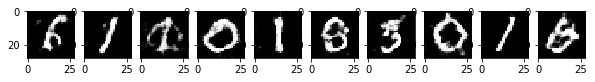

Epochs 2/10: Generator Loss: 2.301. Discriminator Loss: 0.477
Epochs 2/10: Generator Loss: 2.078. Discriminator Loss: 0.532
Epochs 2/10: Generator Loss: 2.009. Discriminator Loss: 0.542
Epochs 2/10: Generator Loss: 1.921. Discriminator Loss: 0.549
Epochs 2/10: Generator Loss: 2.106. Discriminator Loss: 0.517
Epochs 2/10: Generator Loss: 2.125. Discriminator Loss: 0.5
Epochs 2/10: Generator Loss: 2.439. Discriminator Loss: 0.479
Epochs 2/10: Generator Loss: 2.197. Discriminator Loss: 0.519
Epochs 2/10: Generator Loss: 2.178. Discriminator Loss: 0.548
Epochs 2/10: Generator Loss: 2.201. Discriminator Loss: 0.55


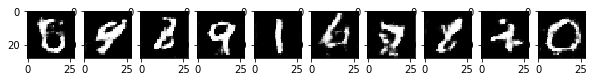

Epochs 2/10: Generator Loss: 2.281. Discriminator Loss: 0.513
Epochs 2/10: Generator Loss: 2.089. Discriminator Loss: 0.55
Epochs 2/10: Generator Loss: 2.36. Discriminator Loss: 0.5
Epochs 2/10: Generator Loss: 2.127. Discriminator Loss: 0.522
Epochs 2/10: Generator Loss: 2.174. Discriminator Loss: 0.521
Epochs 2/10: Generator Loss: 2.198. Discriminator Loss: 0.566
Epochs 2/10: Generator Loss: 2.083. Discriminator Loss: 0.537
Epochs 2/10: Generator Loss: 1.969. Discriminator Loss: 0.541
Epochs 2/10: Generator Loss: 1.989. Discriminator Loss: 0.524
Epochs 2/10: Generator Loss: 2.259. Discriminator Loss: 0.496


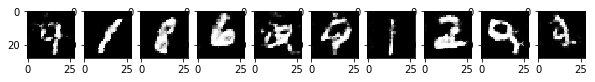

Epochs 2/10: Generator Loss: 2.12. Discriminator Loss: 0.559
Epochs 2/10: Generator Loss: 2.356. Discriminator Loss: 0.549
Epochs 2/10: Generator Loss: 2.192. Discriminator Loss: 0.529
Epochs 2/10: Generator Loss: 2.172. Discriminator Loss: 0.512
Epochs 2/10: Generator Loss: 2.08. Discriminator Loss: 0.532
Epochs 2/10: Generator Loss: 1.922. Discriminator Loss: 0.608
Epochs 2/10: Generator Loss: 2.2. Discriminator Loss: 0.503
Epochs 2/10: Generator Loss: 2.308. Discriminator Loss: 0.482
Epochs 2/10: Generator Loss: 2.202. Discriminator Loss: 0.518
Epochs 2/10: Generator Loss: 2.163. Discriminator Loss: 0.531


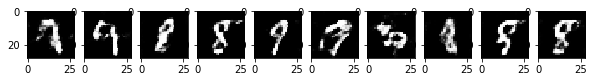

Epochs 2/10: Generator Loss: 2.1. Discriminator Loss: 0.52
Epochs 2/10: Generator Loss: 2.211. Discriminator Loss: 0.501
Epochs 2/10: Generator Loss: 2.243. Discriminator Loss: 0.534
Epochs 2/10: Generator Loss: 2.246. Discriminator Loss: 0.495
Epochs 2/10: Generator Loss: 2.112. Discriminator Loss: 0.532
Epochs 2/10: Generator Loss: 2.226. Discriminator Loss: 0.501
Epochs 2/10: Generator Loss: 2.284. Discriminator Loss: 0.517
Epochs 2/10: Generator Loss: 2.084. Discriminator Loss: 0.552
Epochs 2/10: Generator Loss: 2.079. Discriminator Loss: 0.541
Epochs 2/10: Generator Loss: 2.267. Discriminator Loss: 0.49


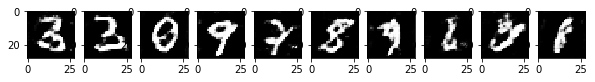

Epochs 2/10: Generator Loss: 1.987. Discriminator Loss: 0.525
Epochs 2/10: Generator Loss: 2.097. Discriminator Loss: 0.512
Epochs 2/10: Generator Loss: 2.041. Discriminator Loss: 0.522
Epochs 2/10: Generator Loss: 2.045. Discriminator Loss: 0.541
Epochs 2/10: Generator Loss: 2.203. Discriminator Loss: 0.554
Epochs 2/10: Generator Loss: 2.151. Discriminator Loss: 0.492
Epochs 2/10: Generator Loss: 2.276. Discriminator Loss: 0.548
Epochs 2/10: Generator Loss: 2.113. Discriminator Loss: 0.537
Epochs 2/10: Generator Loss: 2.256. Discriminator Loss: 0.494
Epochs 2/10: Generator Loss: 2.342. Discriminator Loss: 0.532


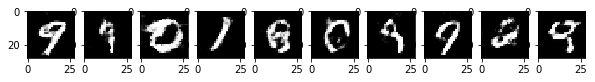

Epochs 2/10: Generator Loss: 2.021. Discriminator Loss: 0.63
Epochs 2/10: Generator Loss: 2.144. Discriminator Loss: 0.525
Epochs 2/10: Generator Loss: 2.379. Discriminator Loss: 0.51
Epochs 2/10: Generator Loss: 2.276. Discriminator Loss: 0.479
Epochs 2/10: Generator Loss: 2.272. Discriminator Loss: 0.504
Epochs 2/10: Generator Loss: 2.109. Discriminator Loss: 0.549
Epochs 2/10: Generator Loss: 2.346. Discriminator Loss: 0.494
Epochs 2/10: Generator Loss: 2.302. Discriminator Loss: 0.487
Epochs 2/10: Generator Loss: 2.248. Discriminator Loss: 0.492
Epochs 2/10: Generator Loss: 2.307. Discriminator Loss: 0.521


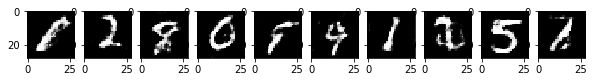

Epochs 2/10: Generator Loss: 2.222. Discriminator Loss: 0.511
Epochs 2/10: Generator Loss: 2.182. Discriminator Loss: 0.536
Epochs 2/10: Generator Loss: 2.26. Discriminator Loss: 0.517
Epochs 2/10: Generator Loss: 2.171. Discriminator Loss: 0.545
Epochs 2/10: Generator Loss: 2.411. Discriminator Loss: 0.525
Epochs 2/10: Generator Loss: 2.453. Discriminator Loss: 0.46
Epochs 2/10: Generator Loss: 2.174. Discriminator Loss: 0.499
Epochs 2/10: Generator Loss: 2.293. Discriminator Loss: 0.507
Epochs 2/10: Generator Loss: 2.26. Discriminator Loss: 0.554
Epochs 2/10: Generator Loss: 2.3. Discriminator Loss: 0.563


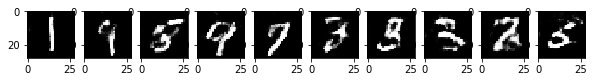

Epochs 2/10: Generator Loss: 2.295. Discriminator Loss: 0.505
Epochs 2/10: Generator Loss: 2.419. Discriminator Loss: 0.493
Epochs 2/10: Generator Loss: 2.12. Discriminator Loss: 0.512
Epochs 2/10: Generator Loss: 2.279. Discriminator Loss: 0.512
Epochs 2/10: Generator Loss: 2.146. Discriminator Loss: 0.547
Epochs 2/10: Generator Loss: 2.119. Discriminator Loss: 0.528
Epochs 2/10: Generator Loss: 2.208. Discriminator Loss: 0.494
Epochs 2/10: Generator Loss: 2.303. Discriminator Loss: 0.471
Epochs 2/10: Generator Loss: 2.069. Discriminator Loss: 0.566
Epochs 2/10: Generator Loss: 2.29. Discriminator Loss: 0.533


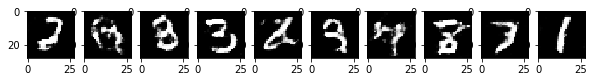

Epochs 2/10: Generator Loss: 2.29. Discriminator Loss: 0.49
Epochs 2/10: Generator Loss: 2.269. Discriminator Loss: 0.522
Epochs 2/10: Generator Loss: 2.325. Discriminator Loss: 0.506
Epochs 2/10: Generator Loss: 2.315. Discriminator Loss: 0.494
Epochs 2/10: Generator Loss: 2.307. Discriminator Loss: 0.476
Epochs 2/10: Generator Loss: 2.225. Discriminator Loss: 0.541
Epochs 2/10: Generator Loss: 2.492. Discriminator Loss: 0.51
Epochs 2/10: Generator Loss: 2.238. Discriminator Loss: 0.522
Epochs 2/10: Generator Loss: 2.405. Discriminator Loss: 0.504
Epochs 2/10: Generator Loss: 2.205. Discriminator Loss: 0.505


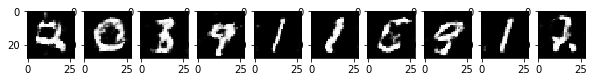

Epochs 2/10: Generator Loss: 2.211. Discriminator Loss: 0.51
Epochs 2/10: Generator Loss: 2.348. Discriminator Loss: 0.586
Epochs 2/10: Generator Loss: 2.313. Discriminator Loss: 0.538
Epochs 2/10: Generator Loss: 2.292. Discriminator Loss: 0.5
Epochs 2/10: Generator Loss: 2.272. Discriminator Loss: 0.524
Epochs 2/10: Generator Loss: 2.164. Discriminator Loss: 0.559
Epochs 2/10: Generator Loss: 2.387. Discriminator Loss: 0.494
Epochs 2/10: Generator Loss: 2.25. Discriminator Loss: 0.515
Epochs 2/10: Generator Loss: 2.388. Discriminator Loss: 0.466
Epochs 2/10: Generator Loss: 2.254. Discriminator Loss: 0.485


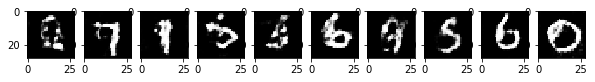

Epochs 2/10: Generator Loss: 2.25. Discriminator Loss: 0.516
Epochs 2/10: Generator Loss: 2.492. Discriminator Loss: 0.478
Epochs 2/10: Generator Loss: 2.427. Discriminator Loss: 0.488
Epochs 2/10: Generator Loss: 2.217. Discriminator Loss: 0.5
Epochs 2/10: Generator Loss: 2.381. Discriminator Loss: 0.463
Epochs 2/10: Generator Loss: 2.243. Discriminator Loss: 0.577
Epochs 2/10: Generator Loss: 2.388. Discriminator Loss: 0.497
Epochs 2/10: Generator Loss: 2.27. Discriminator Loss: 0.541
Epochs 2/10: Generator Loss: 2.409. Discriminator Loss: 0.471
Epochs 2/10: Generator Loss: 2.32. Discriminator Loss: 0.495


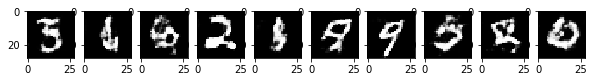

Epochs 2/10: Generator Loss: 2.336. Discriminator Loss: 0.518
Epochs 2/10: Generator Loss: 2.494. Discriminator Loss: 0.462
Epochs 2/10: Generator Loss: 2.275. Discriminator Loss: 0.487
Epochs 2/10: Generator Loss: 2.452. Discriminator Loss: 0.469
Epochs 2/10: Generator Loss: 2.418. Discriminator Loss: 0.532
Epochs 2/10: Generator Loss: 2.445. Discriminator Loss: 0.47
Epochs 2/10: Generator Loss: 2.499. Discriminator Loss: 0.469
Epochs 2/10: Generator Loss: 2.34. Discriminator Loss: 0.497
Epochs 2/10: Generator Loss: 2.44. Discriminator Loss: 0.478
Epochs 2/10: Generator Loss: 2.422. Discriminator Loss: 0.47


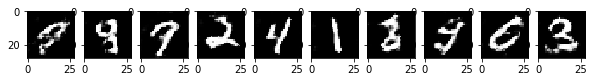

Epochs 2/10: Generator Loss: 2.293. Discriminator Loss: 0.486
Epochs 2/10: Generator Loss: 2.372. Discriminator Loss: 0.486
Epochs 3/10: Generator Loss: 1.668. Discriminator Loss: 0.614
Epochs 3/10: Generator Loss: 2.438. Discriminator Loss: 0.473
Epochs 3/10: Generator Loss: 2.288. Discriminator Loss: 0.498
Epochs 3/10: Generator Loss: 2.45. Discriminator Loss: 0.52
Epochs 3/10: Generator Loss: 2.367. Discriminator Loss: 0.588
Epochs 3/10: Generator Loss: 2.261. Discriminator Loss: 0.466
Epochs 3/10: Generator Loss: 2.546. Discriminator Loss: 0.466
Epochs 3/10: Generator Loss: 2.462. Discriminator Loss: 0.491


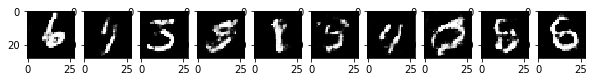

Epochs 3/10: Generator Loss: 2.368. Discriminator Loss: 0.518
Epochs 3/10: Generator Loss: 2.581. Discriminator Loss: 0.479
Epochs 3/10: Generator Loss: 2.429. Discriminator Loss: 0.48
Epochs 3/10: Generator Loss: 2.422. Discriminator Loss: 0.483
Epochs 3/10: Generator Loss: 2.433. Discriminator Loss: 0.471
Epochs 3/10: Generator Loss: 2.55. Discriminator Loss: 0.452
Epochs 3/10: Generator Loss: 2.432. Discriminator Loss: 0.554
Epochs 3/10: Generator Loss: 2.356. Discriminator Loss: 0.501
Epochs 3/10: Generator Loss: 2.338. Discriminator Loss: 0.468
Epochs 3/10: Generator Loss: 2.458. Discriminator Loss: 0.483


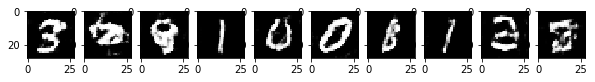

Epochs 3/10: Generator Loss: 2.212. Discriminator Loss: 0.502
Epochs 3/10: Generator Loss: 2.349. Discriminator Loss: 0.49
Epochs 3/10: Generator Loss: 2.235. Discriminator Loss: 0.498
Epochs 3/10: Generator Loss: 2.45. Discriminator Loss: 0.47
Epochs 3/10: Generator Loss: 2.334. Discriminator Loss: 0.56
Epochs 3/10: Generator Loss: 2.479. Discriminator Loss: 0.528
Epochs 3/10: Generator Loss: 2.566. Discriminator Loss: 0.494
Epochs 3/10: Generator Loss: 2.397. Discriminator Loss: 0.513
Epochs 3/10: Generator Loss: 2.506. Discriminator Loss: 0.461
Epochs 3/10: Generator Loss: 2.441. Discriminator Loss: 0.482


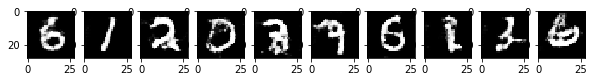

Epochs 3/10: Generator Loss: 2.509. Discriminator Loss: 0.483
Epochs 3/10: Generator Loss: 2.509. Discriminator Loss: 0.511
Epochs 3/10: Generator Loss: 2.561. Discriminator Loss: 0.465
Epochs 3/10: Generator Loss: 2.531. Discriminator Loss: 0.476
Epochs 3/10: Generator Loss: 2.424. Discriminator Loss: 0.478
Epochs 3/10: Generator Loss: 2.279. Discriminator Loss: 0.597
Epochs 3/10: Generator Loss: 2.52. Discriminator Loss: 0.447
Epochs 3/10: Generator Loss: 2.514. Discriminator Loss: 0.456
Epochs 3/10: Generator Loss: 2.64. Discriminator Loss: 0.486
Epochs 3/10: Generator Loss: 2.473. Discriminator Loss: 0.516


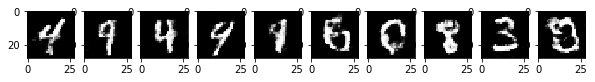

Epochs 3/10: Generator Loss: 2.432. Discriminator Loss: 0.454
Epochs 3/10: Generator Loss: 2.506. Discriminator Loss: 0.453
Epochs 3/10: Generator Loss: 2.57. Discriminator Loss: 0.46
Epochs 3/10: Generator Loss: 2.497. Discriminator Loss: 0.46
Epochs 3/10: Generator Loss: 2.688. Discriminator Loss: 0.474
Epochs 3/10: Generator Loss: 2.395. Discriminator Loss: 0.459
Epochs 3/10: Generator Loss: 2.504. Discriminator Loss: 0.552
Epochs 3/10: Generator Loss: 2.479. Discriminator Loss: 0.483
Epochs 3/10: Generator Loss: 2.656. Discriminator Loss: 0.489
Epochs 3/10: Generator Loss: 2.556. Discriminator Loss: 0.472


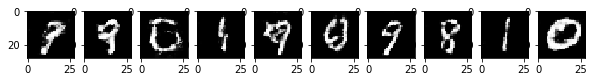

Epochs 3/10: Generator Loss: 2.484. Discriminator Loss: 0.496
Epochs 3/10: Generator Loss: 2.354. Discriminator Loss: 0.524
Epochs 3/10: Generator Loss: 2.509. Discriminator Loss: 0.452
Epochs 3/10: Generator Loss: 2.498. Discriminator Loss: 0.499
Epochs 3/10: Generator Loss: 2.525. Discriminator Loss: 0.457
Epochs 3/10: Generator Loss: 2.53. Discriminator Loss: 0.507
Epochs 3/10: Generator Loss: 2.486. Discriminator Loss: 0.473
Epochs 3/10: Generator Loss: 2.476. Discriminator Loss: 0.474
Epochs 3/10: Generator Loss: 2.548. Discriminator Loss: 0.467
Epochs 3/10: Generator Loss: 2.472. Discriminator Loss: 0.442


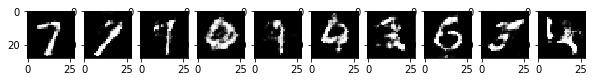

Epochs 3/10: Generator Loss: 2.373. Discriminator Loss: 0.453
Epochs 3/10: Generator Loss: 2.608. Discriminator Loss: 0.442
Epochs 3/10: Generator Loss: 2.254. Discriminator Loss: 0.555
Epochs 3/10: Generator Loss: 2.536. Discriminator Loss: 0.461
Epochs 3/10: Generator Loss: 2.325. Discriminator Loss: 0.508
Epochs 3/10: Generator Loss: 2.499. Discriminator Loss: 0.456
Epochs 3/10: Generator Loss: 2.509. Discriminator Loss: 0.443
Epochs 3/10: Generator Loss: 2.513. Discriminator Loss: 0.484
Epochs 3/10: Generator Loss: 2.505. Discriminator Loss: 0.467
Epochs 3/10: Generator Loss: 2.501. Discriminator Loss: 0.481


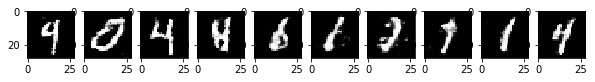

Epochs 3/10: Generator Loss: 2.702. Discriminator Loss: 0.459
Epochs 3/10: Generator Loss: 2.677. Discriminator Loss: 0.645
Epochs 3/10: Generator Loss: 2.504. Discriminator Loss: 0.473
Epochs 3/10: Generator Loss: 2.563. Discriminator Loss: 0.458
Epochs 3/10: Generator Loss: 2.653. Discriminator Loss: 0.444
Epochs 3/10: Generator Loss: 2.849. Discriminator Loss: 0.481
Epochs 3/10: Generator Loss: 2.638. Discriminator Loss: 0.456
Epochs 3/10: Generator Loss: 2.516. Discriminator Loss: 0.525
Epochs 3/10: Generator Loss: 2.701. Discriminator Loss: 0.46
Epochs 3/10: Generator Loss: 2.86. Discriminator Loss: 0.449


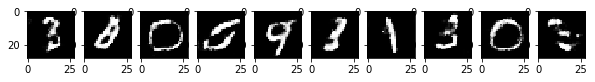

Epochs 3/10: Generator Loss: 2.822. Discriminator Loss: 0.439
Epochs 3/10: Generator Loss: 2.425. Discriminator Loss: 0.488
Epochs 3/10: Generator Loss: 2.757. Discriminator Loss: 0.437
Epochs 3/10: Generator Loss: 2.72. Discriminator Loss: 0.454
Epochs 3/10: Generator Loss: 2.632. Discriminator Loss: 0.443
Epochs 3/10: Generator Loss: 2.786. Discriminator Loss: 0.448
Epochs 3/10: Generator Loss: 2.386. Discriminator Loss: 0.511
Epochs 3/10: Generator Loss: 2.562. Discriminator Loss: 0.485
Epochs 3/10: Generator Loss: 2.589. Discriminator Loss: 0.453
Epochs 3/10: Generator Loss: 2.483. Discriminator Loss: 0.52


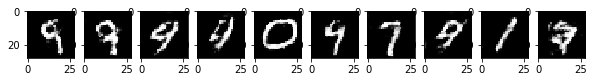

Epochs 3/10: Generator Loss: 2.667. Discriminator Loss: 0.463
Epochs 3/10: Generator Loss: 2.854. Discriminator Loss: 0.451
Epochs 3/10: Generator Loss: 2.674. Discriminator Loss: 0.443
Epochs 3/10: Generator Loss: 2.36. Discriminator Loss: 0.477
Epochs 3/10: Generator Loss: 2.696. Discriminator Loss: 0.469
Epochs 3/10: Generator Loss: 2.881. Discriminator Loss: 0.425
Epochs 3/10: Generator Loss: 2.371. Discriminator Loss: 0.509
Epochs 3/10: Generator Loss: 2.704. Discriminator Loss: 0.488
Epochs 3/10: Generator Loss: 2.772. Discriminator Loss: 0.466
Epochs 3/10: Generator Loss: 2.749. Discriminator Loss: 0.44


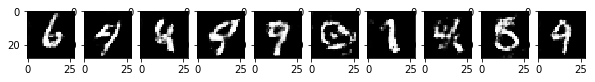

Epochs 3/10: Generator Loss: 2.669. Discriminator Loss: 0.433
Epochs 3/10: Generator Loss: 2.76. Discriminator Loss: 0.453
Epochs 3/10: Generator Loss: 2.428. Discriminator Loss: 0.456
Epochs 3/10: Generator Loss: 2.399. Discriminator Loss: 0.472
Epochs 3/10: Generator Loss: 2.744. Discriminator Loss: 0.492
Epochs 3/10: Generator Loss: 2.537. Discriminator Loss: 0.541
Epochs 3/10: Generator Loss: 2.836. Discriminator Loss: 0.435
Epochs 3/10: Generator Loss: 2.718. Discriminator Loss: 0.441
Epochs 3/10: Generator Loss: 2.601. Discriminator Loss: 0.444
Epochs 3/10: Generator Loss: 2.646. Discriminator Loss: 0.442


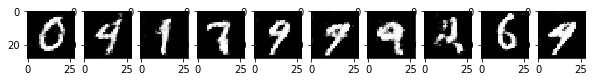

Epochs 3/10: Generator Loss: 2.496. Discriminator Loss: 0.488
Epochs 3/10: Generator Loss: 2.6. Discriminator Loss: 0.436
Epochs 3/10: Generator Loss: 2.643. Discriminator Loss: 0.458
Epochs 3/10: Generator Loss: 2.656. Discriminator Loss: 0.464
Epochs 3/10: Generator Loss: 2.82. Discriminator Loss: 0.459
Epochs 3/10: Generator Loss: 2.767. Discriminator Loss: 0.424
Epochs 3/10: Generator Loss: 2.878. Discriminator Loss: 0.421
Epochs 3/10: Generator Loss: 2.675. Discriminator Loss: 0.449
Epochs 3/10: Generator Loss: 2.372. Discriminator Loss: 0.511
Epochs 3/10: Generator Loss: 2.699. Discriminator Loss: 0.46


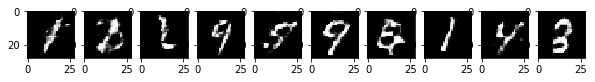

Epochs 3/10: Generator Loss: 2.714. Discriminator Loss: 0.444
Epochs 3/10: Generator Loss: 2.679. Discriminator Loss: 0.424
Epochs 3/10: Generator Loss: 2.763. Discriminator Loss: 0.493
Epochs 3/10: Generator Loss: 2.778. Discriminator Loss: 0.464
Epochs 3/10: Generator Loss: 2.663. Discriminator Loss: 0.503
Epochs 3/10: Generator Loss: 2.892. Discriminator Loss: 0.43
Epochs 3/10: Generator Loss: 2.438. Discriminator Loss: 0.485
Epochs 3/10: Generator Loss: 2.715. Discriminator Loss: 0.514
Epochs 3/10: Generator Loss: 2.783. Discriminator Loss: 0.453
Epochs 3/10: Generator Loss: 2.985. Discriminator Loss: 0.417


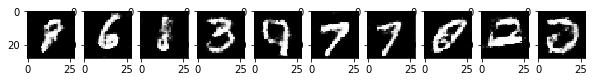

Epochs 3/10: Generator Loss: 2.513. Discriminator Loss: 0.512
Epochs 3/10: Generator Loss: 2.84. Discriminator Loss: 0.442
Epochs 3/10: Generator Loss: 2.82. Discriminator Loss: 0.443
Epochs 3/10: Generator Loss: 2.95. Discriminator Loss: 0.417
Epochs 3/10: Generator Loss: 2.928. Discriminator Loss: 0.468
Epochs 3/10: Generator Loss: 2.832. Discriminator Loss: 0.435
Epochs 3/10: Generator Loss: 2.678. Discriminator Loss: 0.466
Epochs 3/10: Generator Loss: 2.719. Discriminator Loss: 0.446
Epochs 3/10: Generator Loss: 2.676. Discriminator Loss: 0.429
Epochs 3/10: Generator Loss: 2.541. Discriminator Loss: 0.443


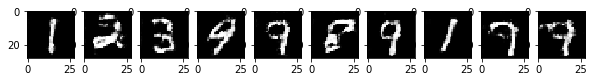

Epochs 3/10: Generator Loss: 2.98. Discriminator Loss: 0.434
Epochs 3/10: Generator Loss: 2.657. Discriminator Loss: 0.465
Epochs 3/10: Generator Loss: 2.751. Discriminator Loss: 0.425
Epochs 3/10: Generator Loss: 2.621. Discriminator Loss: 0.45
Epochs 3/10: Generator Loss: 2.642. Discriminator Loss: 0.449
Epochs 3/10: Generator Loss: 2.782. Discriminator Loss: 0.491
Epochs 3/10: Generator Loss: 2.609. Discriminator Loss: 0.498
Epochs 3/10: Generator Loss: 2.762. Discriminator Loss: 0.455
Epochs 3/10: Generator Loss: 2.836. Discriminator Loss: 0.416
Epochs 3/10: Generator Loss: 2.942. Discriminator Loss: 0.437


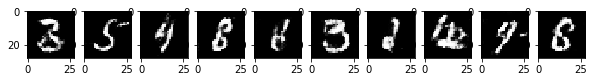

Epochs 3/10: Generator Loss: 2.77. Discriminator Loss: 0.433
Epochs 3/10: Generator Loss: 2.716. Discriminator Loss: 0.449
Epochs 3/10: Generator Loss: 2.719. Discriminator Loss: 0.45
Epochs 3/10: Generator Loss: 2.716. Discriminator Loss: 0.438
Epochs 3/10: Generator Loss: 2.764. Discriminator Loss: 0.438
Epochs 3/10: Generator Loss: 3.044. Discriminator Loss: 0.435
Epochs 3/10: Generator Loss: 3.052. Discriminator Loss: 0.434
Epochs 3/10: Generator Loss: 2.925. Discriminator Loss: 0.471
Epochs 3/10: Generator Loss: 2.797. Discriminator Loss: 0.454
Epochs 3/10: Generator Loss: 2.71. Discriminator Loss: 0.433


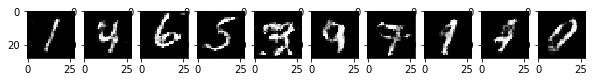

Epochs 3/10: Generator Loss: 2.76. Discriminator Loss: 0.48
Epochs 3/10: Generator Loss: 2.717. Discriminator Loss: 0.422
Epochs 3/10: Generator Loss: 2.619. Discriminator Loss: 0.494
Epochs 3/10: Generator Loss: 2.83. Discriminator Loss: 0.425
Epochs 3/10: Generator Loss: 2.613. Discriminator Loss: 0.445
Epochs 3/10: Generator Loss: 2.494. Discriminator Loss: 0.472
Epochs 3/10: Generator Loss: 2.824. Discriminator Loss: 0.451
Epochs 3/10: Generator Loss: 2.65. Discriminator Loss: 0.469
Epochs 3/10: Generator Loss: 2.903. Discriminator Loss: 0.443
Epochs 3/10: Generator Loss: 2.76. Discriminator Loss: 0.436


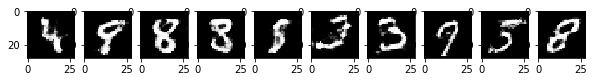

Epochs 3/10: Generator Loss: 2.75. Discriminator Loss: 0.427
Epochs 3/10: Generator Loss: 2.867. Discriminator Loss: 0.443
Epochs 3/10: Generator Loss: 2.911. Discriminator Loss: 0.414
Epochs 3/10: Generator Loss: 2.854. Discriminator Loss: 0.461
Epochs 3/10: Generator Loss: 2.762. Discriminator Loss: 0.43
Epochs 3/10: Generator Loss: 2.883. Discriminator Loss: 0.432
Epochs 3/10: Generator Loss: 2.863. Discriminator Loss: 0.483
Epochs 3/10: Generator Loss: 2.686. Discriminator Loss: 0.5
Epochs 3/10: Generator Loss: 2.966. Discriminator Loss: 0.452
Epochs 3/10: Generator Loss: 3.331. Discriminator Loss: 0.464


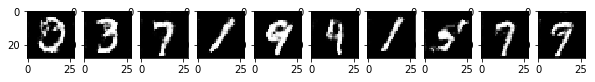

Epochs 3/10: Generator Loss: 2.815. Discriminator Loss: 0.437
Epochs 3/10: Generator Loss: 2.829. Discriminator Loss: 0.624
Epochs 3/10: Generator Loss: 2.975. Discriminator Loss: 0.439
Epochs 3/10: Generator Loss: 3.009. Discriminator Loss: 0.407
Epochs 3/10: Generator Loss: 2.895. Discriminator Loss: 0.507
Epochs 3/10: Generator Loss: 2.898. Discriminator Loss: 0.415
Epochs 3/10: Generator Loss: 2.886. Discriminator Loss: 0.438
Epochs 3/10: Generator Loss: 2.724. Discriminator Loss: 0.429
Epochs 3/10: Generator Loss: 2.778. Discriminator Loss: 0.432
Epochs 4/10: Generator Loss: 2.514. Discriminator Loss: 0.949


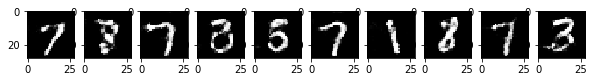

Epochs 4/10: Generator Loss: 2.788. Discriminator Loss: 0.473
Epochs 4/10: Generator Loss: 3.013. Discriminator Loss: 0.404
Epochs 4/10: Generator Loss: 2.801. Discriminator Loss: 0.435
Epochs 4/10: Generator Loss: 2.575. Discriminator Loss: 0.458
Epochs 4/10: Generator Loss: 2.732. Discriminator Loss: 0.452
Epochs 4/10: Generator Loss: 2.673. Discriminator Loss: 0.442
Epochs 4/10: Generator Loss: 2.84. Discriminator Loss: 0.416
Epochs 4/10: Generator Loss: 3.025. Discriminator Loss: 0.435
Epochs 4/10: Generator Loss: 3.027. Discriminator Loss: 0.422
Epochs 4/10: Generator Loss: 2.946. Discriminator Loss: 0.418


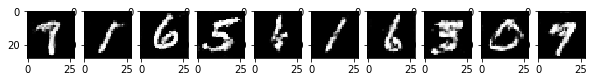

Epochs 4/10: Generator Loss: 2.85. Discriminator Loss: 0.437
Epochs 4/10: Generator Loss: 2.974. Discriminator Loss: 0.43
Epochs 4/10: Generator Loss: 2.766. Discriminator Loss: 0.458
Epochs 4/10: Generator Loss: 3.043. Discriminator Loss: 0.42
Epochs 4/10: Generator Loss: 2.639. Discriminator Loss: 0.455
Epochs 4/10: Generator Loss: 2.996. Discriminator Loss: 0.421
Epochs 4/10: Generator Loss: 2.969. Discriminator Loss: 0.409
Epochs 4/10: Generator Loss: 2.791. Discriminator Loss: 0.479
Epochs 4/10: Generator Loss: 2.851. Discriminator Loss: 0.463
Epochs 4/10: Generator Loss: 2.869. Discriminator Loss: 0.444


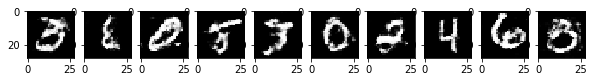

Epochs 4/10: Generator Loss: 3.097. Discriminator Loss: 0.429
Epochs 4/10: Generator Loss: 3.08. Discriminator Loss: 0.504
Epochs 4/10: Generator Loss: 3.057. Discriminator Loss: 0.408
Epochs 4/10: Generator Loss: 3.086. Discriminator Loss: 0.451
Epochs 4/10: Generator Loss: 2.873. Discriminator Loss: 0.417
Epochs 4/10: Generator Loss: 2.89. Discriminator Loss: 0.413
Epochs 4/10: Generator Loss: 3.009. Discriminator Loss: 0.398
Epochs 4/10: Generator Loss: 3.099. Discriminator Loss: 0.437
Epochs 4/10: Generator Loss: 2.957. Discriminator Loss: 0.461
Epochs 4/10: Generator Loss: 2.737. Discriminator Loss: 0.475


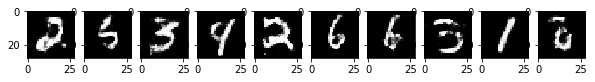

Epochs 4/10: Generator Loss: 3.228. Discriminator Loss: 0.397
Epochs 4/10: Generator Loss: 3.137. Discriminator Loss: 0.433
Epochs 4/10: Generator Loss: 2.916. Discriminator Loss: 0.43
Epochs 4/10: Generator Loss: 3.029. Discriminator Loss: 0.4
Epochs 4/10: Generator Loss: 2.887. Discriminator Loss: 0.399
Epochs 4/10: Generator Loss: 2.969. Discriminator Loss: 0.417
Epochs 4/10: Generator Loss: 2.846. Discriminator Loss: 0.442
Epochs 4/10: Generator Loss: 2.897. Discriminator Loss: 0.449
Epochs 4/10: Generator Loss: 3.137. Discriminator Loss: 0.559
Epochs 4/10: Generator Loss: 2.966. Discriminator Loss: 0.439


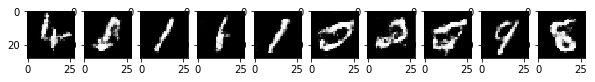

Epochs 4/10: Generator Loss: 2.995. Discriminator Loss: 0.438
Epochs 4/10: Generator Loss: 3.104. Discriminator Loss: 0.428
Epochs 4/10: Generator Loss: 2.818. Discriminator Loss: 0.446
Epochs 4/10: Generator Loss: 2.721. Discriminator Loss: 0.435
Epochs 4/10: Generator Loss: 3.079. Discriminator Loss: 0.445
Epochs 4/10: Generator Loss: 2.888. Discriminator Loss: 0.461
Epochs 4/10: Generator Loss: 3.04. Discriminator Loss: 0.412
Epochs 4/10: Generator Loss: 2.973. Discriminator Loss: 0.411
Epochs 4/10: Generator Loss: 2.625. Discriminator Loss: 0.446
Epochs 4/10: Generator Loss: 3.029. Discriminator Loss: 0.435


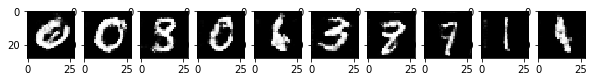

Epochs 4/10: Generator Loss: 2.801. Discriminator Loss: 0.46
Epochs 4/10: Generator Loss: 3.197. Discriminator Loss: 0.444
Epochs 4/10: Generator Loss: 2.934. Discriminator Loss: 0.416
Epochs 4/10: Generator Loss: 3.137. Discriminator Loss: 0.434
Epochs 4/10: Generator Loss: 2.975. Discriminator Loss: 0.404
Epochs 4/10: Generator Loss: 2.971. Discriminator Loss: 0.423
Epochs 4/10: Generator Loss: 3.108. Discriminator Loss: 0.428
Epochs 4/10: Generator Loss: 3.165. Discriminator Loss: 0.434
Epochs 4/10: Generator Loss: 2.949. Discriminator Loss: 0.418
Epochs 4/10: Generator Loss: 3.081. Discriminator Loss: 0.434


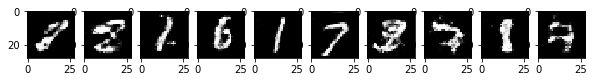

Epochs 4/10: Generator Loss: 2.834. Discriminator Loss: 0.433
Epochs 4/10: Generator Loss: 3.018. Discriminator Loss: 0.428
Epochs 4/10: Generator Loss: 3.082. Discriminator Loss: 0.42
Epochs 4/10: Generator Loss: 2.823. Discriminator Loss: 0.515
Epochs 4/10: Generator Loss: 3.053. Discriminator Loss: 0.402
Epochs 4/10: Generator Loss: 2.934. Discriminator Loss: 0.423
Epochs 4/10: Generator Loss: 2.877. Discriminator Loss: 0.418
Epochs 4/10: Generator Loss: 2.881. Discriminator Loss: 0.426
Epochs 4/10: Generator Loss: 3.015. Discriminator Loss: 0.448
Epochs 4/10: Generator Loss: 2.955. Discriminator Loss: 0.404


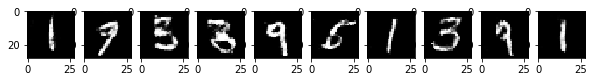

Epochs 4/10: Generator Loss: 3.13. Discriminator Loss: 0.429
Epochs 4/10: Generator Loss: 2.953. Discriminator Loss: 0.421
Epochs 4/10: Generator Loss: 3.061. Discriminator Loss: 0.428
Epochs 4/10: Generator Loss: 2.935. Discriminator Loss: 0.438
Epochs 4/10: Generator Loss: 3.001. Discriminator Loss: 0.44
Epochs 4/10: Generator Loss: 2.961. Discriminator Loss: 0.418
Epochs 4/10: Generator Loss: 3.111. Discriminator Loss: 0.417
Epochs 4/10: Generator Loss: 3.314. Discriminator Loss: 0.395
Epochs 4/10: Generator Loss: 3.083. Discriminator Loss: 0.399
Epochs 4/10: Generator Loss: 3.121. Discriminator Loss: 0.416


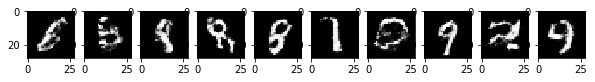

Epochs 4/10: Generator Loss: 3.125. Discriminator Loss: 0.404
Epochs 4/10: Generator Loss: 2.95. Discriminator Loss: 0.442
Epochs 4/10: Generator Loss: 2.935. Discriminator Loss: 0.426
Epochs 4/10: Generator Loss: 3.175. Discriminator Loss: 0.414
Epochs 4/10: Generator Loss: 3.056. Discriminator Loss: 0.418
Epochs 4/10: Generator Loss: 3.056. Discriminator Loss: 0.403
Epochs 4/10: Generator Loss: 3.4. Discriminator Loss: 0.45
Epochs 4/10: Generator Loss: 3.065. Discriminator Loss: 0.434
Epochs 4/10: Generator Loss: 3.202. Discriminator Loss: 0.407
Epochs 4/10: Generator Loss: 3.183. Discriminator Loss: 0.399


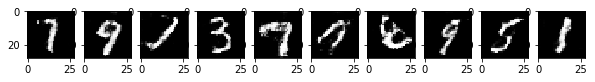

Epochs 4/10: Generator Loss: 3.071. Discriminator Loss: 0.463
Epochs 4/10: Generator Loss: 3.027. Discriminator Loss: 0.419
Epochs 4/10: Generator Loss: 3.171. Discriminator Loss: 0.44
Epochs 4/10: Generator Loss: 3.415. Discriminator Loss: 0.388
Epochs 4/10: Generator Loss: 3.145. Discriminator Loss: 0.569
Epochs 4/10: Generator Loss: 3.329. Discriminator Loss: 0.426
Epochs 4/10: Generator Loss: 3.094. Discriminator Loss: 0.398
Epochs 4/10: Generator Loss: 3.112. Discriminator Loss: 0.477
Epochs 4/10: Generator Loss: 3.272. Discriminator Loss: 0.39
Epochs 4/10: Generator Loss: 3.064. Discriminator Loss: 0.399


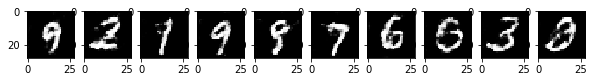

Epochs 4/10: Generator Loss: 3.171. Discriminator Loss: 0.425
Epochs 4/10: Generator Loss: 3.121. Discriminator Loss: 0.447
Epochs 4/10: Generator Loss: 3.14. Discriminator Loss: 0.447
Epochs 4/10: Generator Loss: 3.155. Discriminator Loss: 0.429
Epochs 4/10: Generator Loss: 3.152. Discriminator Loss: 0.407
Epochs 4/10: Generator Loss: 3.242. Discriminator Loss: 0.43
Epochs 4/10: Generator Loss: 3.328. Discriminator Loss: 0.4
Epochs 4/10: Generator Loss: 2.956. Discriminator Loss: 0.422
Epochs 4/10: Generator Loss: 2.822. Discriminator Loss: 0.443
Epochs 4/10: Generator Loss: 2.977. Discriminator Loss: 0.425


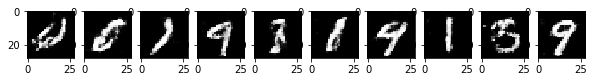

Epochs 4/10: Generator Loss: 2.979. Discriminator Loss: 0.405
Epochs 4/10: Generator Loss: 3.17. Discriminator Loss: 0.482
Epochs 4/10: Generator Loss: 3.039. Discriminator Loss: 0.465
Epochs 4/10: Generator Loss: 3.116. Discriminator Loss: 0.441
Epochs 4/10: Generator Loss: 3.0. Discriminator Loss: 0.448
Epochs 4/10: Generator Loss: 2.965. Discriminator Loss: 0.496
Epochs 4/10: Generator Loss: 3.091. Discriminator Loss: 0.443
Epochs 4/10: Generator Loss: 3.205. Discriminator Loss: 0.414
Epochs 4/10: Generator Loss: 3.037. Discriminator Loss: 0.411
Epochs 4/10: Generator Loss: 2.928. Discriminator Loss: 0.468


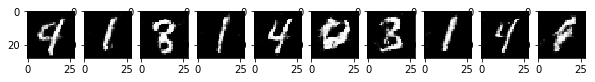

Epochs 4/10: Generator Loss: 3.235. Discriminator Loss: 0.405
Epochs 4/10: Generator Loss: 3.158. Discriminator Loss: 0.437
Epochs 4/10: Generator Loss: 3.027. Discriminator Loss: 0.413
Epochs 4/10: Generator Loss: 3.318. Discriminator Loss: 0.413
Epochs 4/10: Generator Loss: 3.316. Discriminator Loss: 0.435
Epochs 4/10: Generator Loss: 3.338. Discriminator Loss: 0.459
Epochs 4/10: Generator Loss: 3.348. Discriminator Loss: 0.393
Epochs 4/10: Generator Loss: 3.139. Discriminator Loss: 0.461
Epochs 4/10: Generator Loss: 3.355. Discriminator Loss: 0.396
Epochs 4/10: Generator Loss: 3.249. Discriminator Loss: 0.434


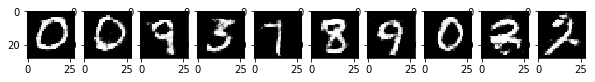

Epochs 4/10: Generator Loss: 3.518. Discriminator Loss: 0.38
Epochs 4/10: Generator Loss: 3.143. Discriminator Loss: 0.424
Epochs 4/10: Generator Loss: 3.686. Discriminator Loss: 0.412
Epochs 4/10: Generator Loss: 3.427. Discriminator Loss: 0.381
Epochs 4/10: Generator Loss: 3.211. Discriminator Loss: 0.456
Epochs 4/10: Generator Loss: 3.175. Discriminator Loss: 0.398
Epochs 4/10: Generator Loss: 2.98. Discriminator Loss: 0.414
Epochs 4/10: Generator Loss: 3.243. Discriminator Loss: 0.391
Epochs 4/10: Generator Loss: 3.268. Discriminator Loss: 0.411
Epochs 4/10: Generator Loss: 3.208. Discriminator Loss: 0.413


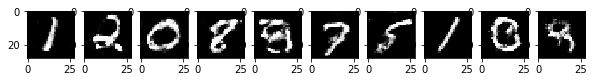

Epochs 4/10: Generator Loss: 3.047. Discriminator Loss: 0.422
Epochs 4/10: Generator Loss: 3.167. Discriminator Loss: 0.393
Epochs 4/10: Generator Loss: 3.366. Discriminator Loss: 0.428
Epochs 4/10: Generator Loss: 3.132. Discriminator Loss: 0.432
Epochs 4/10: Generator Loss: 3.135. Discriminator Loss: 0.436
Epochs 4/10: Generator Loss: 3.15. Discriminator Loss: 0.465
Epochs 4/10: Generator Loss: 3.411. Discriminator Loss: 0.423
Epochs 4/10: Generator Loss: 3.275. Discriminator Loss: 0.42
Epochs 4/10: Generator Loss: 3.101. Discriminator Loss: 0.468
Epochs 4/10: Generator Loss: 3.291. Discriminator Loss: 0.415


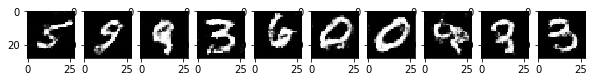

Epochs 4/10: Generator Loss: 3.251. Discriminator Loss: 0.416
Epochs 4/10: Generator Loss: 3.186. Discriminator Loss: 0.415
Epochs 4/10: Generator Loss: 3.292. Discriminator Loss: 0.413
Epochs 4/10: Generator Loss: 3.534. Discriminator Loss: 0.391
Epochs 4/10: Generator Loss: 3.128. Discriminator Loss: 0.435
Epochs 4/10: Generator Loss: 3.311. Discriminator Loss: 0.385
Epochs 4/10: Generator Loss: 2.927. Discriminator Loss: 0.44
Epochs 4/10: Generator Loss: 3.332. Discriminator Loss: 0.407
Epochs 4/10: Generator Loss: 3.175. Discriminator Loss: 0.389
Epochs 4/10: Generator Loss: 3.181. Discriminator Loss: 0.419


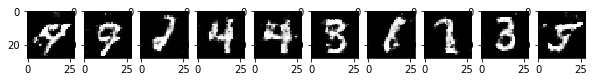

Epochs 4/10: Generator Loss: 3.177. Discriminator Loss: 0.41
Epochs 4/10: Generator Loss: 3.104. Discriminator Loss: 0.422
Epochs 4/10: Generator Loss: 3.062. Discriminator Loss: 0.443
Epochs 4/10: Generator Loss: 3.324. Discriminator Loss: 0.387
Epochs 4/10: Generator Loss: 3.326. Discriminator Loss: 0.437
Epochs 4/10: Generator Loss: 3.086. Discriminator Loss: 0.423
Epochs 4/10: Generator Loss: 3.076. Discriminator Loss: 0.415
Epochs 4/10: Generator Loss: 3.029. Discriminator Loss: 0.476
Epochs 4/10: Generator Loss: 3.099. Discriminator Loss: 0.397
Epochs 4/10: Generator Loss: 3.201. Discriminator Loss: 0.42


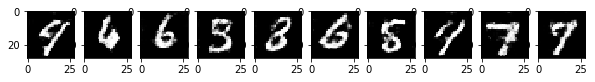

Epochs 4/10: Generator Loss: 3.42. Discriminator Loss: 0.465
Epochs 4/10: Generator Loss: 3.299. Discriminator Loss: 0.402
Epochs 4/10: Generator Loss: 3.19. Discriminator Loss: 0.39
Epochs 4/10: Generator Loss: 3.495. Discriminator Loss: 0.402
Epochs 4/10: Generator Loss: 3.31. Discriminator Loss: 0.407
Epochs 4/10: Generator Loss: 3.321. Discriminator Loss: 0.437
Epochs 4/10: Generator Loss: 3.238. Discriminator Loss: 0.433
Epochs 4/10: Generator Loss: 3.411. Discriminator Loss: 0.436
Epochs 4/10: Generator Loss: 3.454. Discriminator Loss: 0.447
Epochs 4/10: Generator Loss: 3.51. Discriminator Loss: 0.404


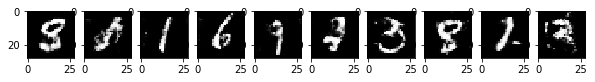

Epochs 4/10: Generator Loss: 3.377. Discriminator Loss: 0.391
Epochs 4/10: Generator Loss: 3.265. Discriminator Loss: 0.408
Epochs 4/10: Generator Loss: 3.347. Discriminator Loss: 0.488
Epochs 4/10: Generator Loss: 3.412. Discriminator Loss: 0.382
Epochs 4/10: Generator Loss: 3.287. Discriminator Loss: 0.389
Epochs 4/10: Generator Loss: 3.284. Discriminator Loss: 0.421
Epochs 4/10: Generator Loss: 3.345. Discriminator Loss: 0.432
Epochs 5/10: Generator Loss: 2.897. Discriminator Loss: 0.573
Epochs 5/10: Generator Loss: 3.23. Discriminator Loss: 0.402
Epochs 5/10: Generator Loss: 3.336. Discriminator Loss: 0.387


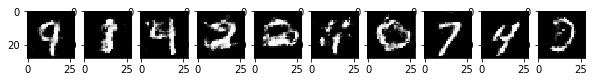

Epochs 5/10: Generator Loss: 3.184. Discriminator Loss: 0.466
Epochs 5/10: Generator Loss: 3.217. Discriminator Loss: 0.519
Epochs 5/10: Generator Loss: 3.086. Discriminator Loss: 0.396
Epochs 5/10: Generator Loss: 3.457. Discriminator Loss: 0.403
Epochs 5/10: Generator Loss: 3.55. Discriminator Loss: 0.441
Epochs 5/10: Generator Loss: 3.219. Discriminator Loss: 0.433
Epochs 5/10: Generator Loss: 3.241. Discriminator Loss: 0.4
Epochs 5/10: Generator Loss: 3.511. Discriminator Loss: 0.391
Epochs 5/10: Generator Loss: 3.384. Discriminator Loss: 0.402
Epochs 5/10: Generator Loss: 3.311. Discriminator Loss: 0.394


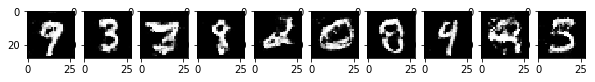

Epochs 5/10: Generator Loss: 3.487. Discriminator Loss: 0.379
Epochs 5/10: Generator Loss: 3.202. Discriminator Loss: 0.443
Epochs 5/10: Generator Loss: 3.293. Discriminator Loss: 0.43
Epochs 5/10: Generator Loss: 3.467. Discriminator Loss: 0.393
Epochs 5/10: Generator Loss: 3.008. Discriminator Loss: 0.452
Epochs 5/10: Generator Loss: 3.388. Discriminator Loss: 0.405
Epochs 5/10: Generator Loss: 3.415. Discriminator Loss: 0.404
Epochs 5/10: Generator Loss: 3.29. Discriminator Loss: 0.393
Epochs 5/10: Generator Loss: 3.276. Discriminator Loss: 0.4
Epochs 5/10: Generator Loss: 3.296. Discriminator Loss: 0.503


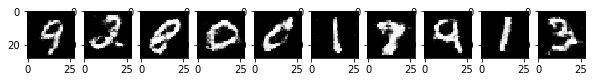

Epochs 5/10: Generator Loss: 3.386. Discriminator Loss: 0.434
Epochs 5/10: Generator Loss: 3.405. Discriminator Loss: 0.405
Epochs 5/10: Generator Loss: 3.162. Discriminator Loss: 0.409
Epochs 5/10: Generator Loss: 3.37. Discriminator Loss: 0.388
Epochs 5/10: Generator Loss: 3.294. Discriminator Loss: 0.39
Epochs 5/10: Generator Loss: 3.233. Discriminator Loss: 0.483
Epochs 5/10: Generator Loss: 3.394. Discriminator Loss: 0.39
Epochs 5/10: Generator Loss: 3.546. Discriminator Loss: 0.381
Epochs 5/10: Generator Loss: 3.641. Discriminator Loss: 0.381
Epochs 5/10: Generator Loss: 3.441. Discriminator Loss: 0.401


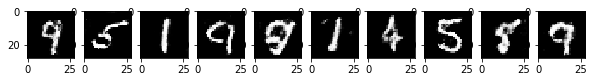

Epochs 5/10: Generator Loss: 3.34. Discriminator Loss: 0.43
Epochs 5/10: Generator Loss: 3.423. Discriminator Loss: 0.398
Epochs 5/10: Generator Loss: 3.36. Discriminator Loss: 0.439
Epochs 5/10: Generator Loss: 3.288. Discriminator Loss: 0.393
Epochs 5/10: Generator Loss: 3.274. Discriminator Loss: 0.43
Epochs 5/10: Generator Loss: 3.423. Discriminator Loss: 0.375
Epochs 5/10: Generator Loss: 3.58. Discriminator Loss: 0.379
Epochs 5/10: Generator Loss: 3.423. Discriminator Loss: 0.425
Epochs 5/10: Generator Loss: 3.492. Discriminator Loss: 0.433
Epochs 5/10: Generator Loss: 3.471. Discriminator Loss: 0.453


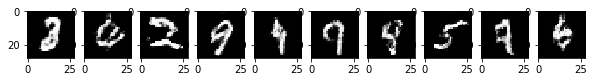

Epochs 5/10: Generator Loss: 3.473. Discriminator Loss: 0.393
Epochs 5/10: Generator Loss: 3.197. Discriminator Loss: 0.433
Epochs 5/10: Generator Loss: 3.497. Discriminator Loss: 0.389
Epochs 5/10: Generator Loss: 3.25. Discriminator Loss: 0.422
Epochs 5/10: Generator Loss: 3.425. Discriminator Loss: 0.389
Epochs 5/10: Generator Loss: 3.269. Discriminator Loss: 0.41
Epochs 5/10: Generator Loss: 3.357. Discriminator Loss: 0.398
Epochs 5/10: Generator Loss: 3.342. Discriminator Loss: 0.377
Epochs 5/10: Generator Loss: 3.602. Discriminator Loss: 0.387
Epochs 5/10: Generator Loss: 3.489. Discriminator Loss: 0.389


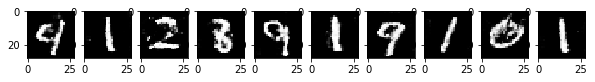

Epochs 5/10: Generator Loss: 3.325. Discriminator Loss: 0.427
Epochs 5/10: Generator Loss: 3.383. Discriminator Loss: 0.424
Epochs 5/10: Generator Loss: 3.398. Discriminator Loss: 0.601
Epochs 5/10: Generator Loss: 3.455. Discriminator Loss: 0.445
Epochs 5/10: Generator Loss: 3.392. Discriminator Loss: 0.393
Epochs 5/10: Generator Loss: 3.554. Discriminator Loss: 0.383
Epochs 5/10: Generator Loss: 3.539. Discriminator Loss: 0.38
Epochs 5/10: Generator Loss: 3.375. Discriminator Loss: 0.407
Epochs 5/10: Generator Loss: 3.404. Discriminator Loss: 0.395
Epochs 5/10: Generator Loss: 3.335. Discriminator Loss: 0.388


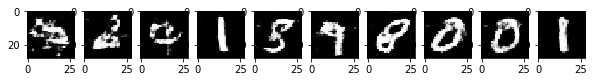

Epochs 5/10: Generator Loss: 3.22. Discriminator Loss: 0.404
Epochs 5/10: Generator Loss: 3.336. Discriminator Loss: 0.428
Epochs 5/10: Generator Loss: 3.564. Discriminator Loss: 0.407
Epochs 5/10: Generator Loss: 3.526. Discriminator Loss: 0.419
Epochs 5/10: Generator Loss: 3.205. Discriminator Loss: 0.467
Epochs 5/10: Generator Loss: 3.426. Discriminator Loss: 0.43
Epochs 5/10: Generator Loss: 3.505. Discriminator Loss: 0.429
Epochs 5/10: Generator Loss: 3.331. Discriminator Loss: 0.427
Epochs 5/10: Generator Loss: 3.55. Discriminator Loss: 0.393
Epochs 5/10: Generator Loss: 3.475. Discriminator Loss: 0.397


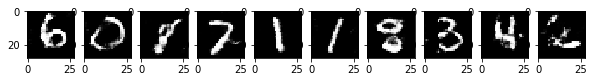

Epochs 5/10: Generator Loss: 3.441. Discriminator Loss: 0.4
Epochs 5/10: Generator Loss: 3.585. Discriminator Loss: 0.405
Epochs 5/10: Generator Loss: 3.388. Discriminator Loss: 0.412
Epochs 5/10: Generator Loss: 3.495. Discriminator Loss: 0.381
Epochs 5/10: Generator Loss: 3.77. Discriminator Loss: 0.373
Epochs 5/10: Generator Loss: 3.501. Discriminator Loss: 0.389
Epochs 5/10: Generator Loss: 3.342. Discriminator Loss: 0.502
Epochs 5/10: Generator Loss: 3.312. Discriminator Loss: 0.401
Epochs 5/10: Generator Loss: 3.715. Discriminator Loss: 0.374
Epochs 5/10: Generator Loss: 3.634. Discriminator Loss: 0.411


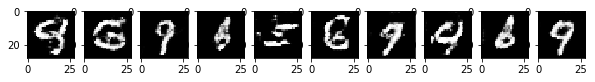

Epochs 5/10: Generator Loss: 3.462. Discriminator Loss: 0.404
Epochs 5/10: Generator Loss: 3.632. Discriminator Loss: 0.377
Epochs 5/10: Generator Loss: 3.414. Discriminator Loss: 0.398
Epochs 5/10: Generator Loss: 3.511. Discriminator Loss: 0.402
Epochs 5/10: Generator Loss: 3.327. Discriminator Loss: 0.398
Epochs 5/10: Generator Loss: 3.511. Discriminator Loss: 0.398
Epochs 5/10: Generator Loss: 3.738. Discriminator Loss: 0.394
Epochs 5/10: Generator Loss: 3.61. Discriminator Loss: 0.382
Epochs 5/10: Generator Loss: 3.684. Discriminator Loss: 0.403
Epochs 5/10: Generator Loss: 3.502. Discriminator Loss: 0.37


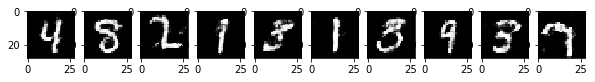

Epochs 5/10: Generator Loss: 3.499. Discriminator Loss: 0.392
Epochs 5/10: Generator Loss: 3.471. Discriminator Loss: 0.517
Epochs 5/10: Generator Loss: 3.281. Discriminator Loss: 0.414
Epochs 5/10: Generator Loss: 3.462. Discriminator Loss: 0.389
Epochs 5/10: Generator Loss: 3.376. Discriminator Loss: 0.382
Epochs 5/10: Generator Loss: 3.646. Discriminator Loss: 0.389
Epochs 5/10: Generator Loss: 3.588. Discriminator Loss: 0.382
Epochs 5/10: Generator Loss: 3.503. Discriminator Loss: 0.381
Epochs 5/10: Generator Loss: 3.359. Discriminator Loss: 0.382
Epochs 5/10: Generator Loss: 3.424. Discriminator Loss: 0.395


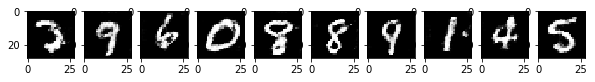

Epochs 5/10: Generator Loss: 3.533. Discriminator Loss: 0.418
Epochs 5/10: Generator Loss: 3.606. Discriminator Loss: 0.422
Epochs 5/10: Generator Loss: 3.457. Discriminator Loss: 0.401
Epochs 5/10: Generator Loss: 3.695. Discriminator Loss: 0.37
Epochs 5/10: Generator Loss: 3.388. Discriminator Loss: 0.396
Epochs 5/10: Generator Loss: 3.611. Discriminator Loss: 0.412
Epochs 5/10: Generator Loss: 3.482. Discriminator Loss: 0.39
Epochs 5/10: Generator Loss: 3.584. Discriminator Loss: 0.391
Epochs 5/10: Generator Loss: 3.781. Discriminator Loss: 0.5
Epochs 5/10: Generator Loss: 3.332. Discriminator Loss: 0.496


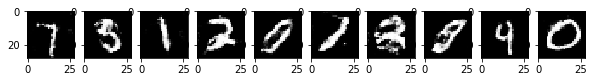

Epochs 5/10: Generator Loss: 3.402. Discriminator Loss: 0.379
Epochs 5/10: Generator Loss: 3.494. Discriminator Loss: 0.384
Epochs 5/10: Generator Loss: 3.577. Discriminator Loss: 0.397
Epochs 5/10: Generator Loss: 3.457. Discriminator Loss: 0.429
Epochs 5/10: Generator Loss: 3.471. Discriminator Loss: 0.489
Epochs 5/10: Generator Loss: 3.765. Discriminator Loss: 0.399
Epochs 5/10: Generator Loss: 3.439. Discriminator Loss: 0.392
Epochs 5/10: Generator Loss: 3.415. Discriminator Loss: 0.384
Epochs 5/10: Generator Loss: 3.358. Discriminator Loss: 0.406
Epochs 5/10: Generator Loss: 3.454. Discriminator Loss: 0.381


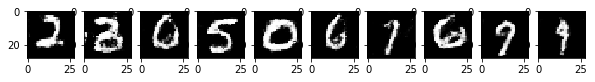

Epochs 5/10: Generator Loss: 3.909. Discriminator Loss: 0.373
Epochs 5/10: Generator Loss: 3.842. Discriminator Loss: 0.371
Epochs 5/10: Generator Loss: 3.676. Discriminator Loss: 0.406
Epochs 5/10: Generator Loss: 3.642. Discriminator Loss: 0.388
Epochs 5/10: Generator Loss: 3.58. Discriminator Loss: 0.385
Epochs 5/10: Generator Loss: 3.745. Discriminator Loss: 0.429
Epochs 5/10: Generator Loss: 3.516. Discriminator Loss: 0.378
Epochs 5/10: Generator Loss: 3.747. Discriminator Loss: 0.385
Epochs 5/10: Generator Loss: 3.7. Discriminator Loss: 0.409
Epochs 5/10: Generator Loss: 3.474. Discriminator Loss: 0.555


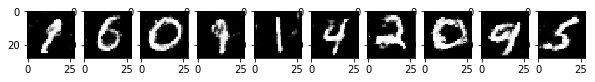

Epochs 5/10: Generator Loss: 3.703. Discriminator Loss: 0.376
Epochs 5/10: Generator Loss: 3.63. Discriminator Loss: 0.407
Epochs 5/10: Generator Loss: 3.554. Discriminator Loss: 0.387
Epochs 5/10: Generator Loss: 3.671. Discriminator Loss: 0.374
Epochs 5/10: Generator Loss: 3.676. Discriminator Loss: 0.373
Epochs 5/10: Generator Loss: 3.621. Discriminator Loss: 0.385
Epochs 5/10: Generator Loss: 3.488. Discriminator Loss: 0.396
Epochs 5/10: Generator Loss: 3.398. Discriminator Loss: 0.498
Epochs 5/10: Generator Loss: 3.629. Discriminator Loss: 0.39
Epochs 5/10: Generator Loss: 3.632. Discriminator Loss: 0.383


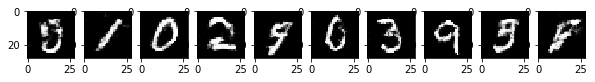

Epochs 5/10: Generator Loss: 3.585. Discriminator Loss: 0.401
Epochs 5/10: Generator Loss: 3.273. Discriminator Loss: 0.484
Epochs 5/10: Generator Loss: 3.715. Discriminator Loss: 0.473
Epochs 5/10: Generator Loss: 3.596. Discriminator Loss: 0.371
Epochs 5/10: Generator Loss: 3.371. Discriminator Loss: 0.524
Epochs 5/10: Generator Loss: 3.722. Discriminator Loss: 0.387
Epochs 5/10: Generator Loss: 3.563. Discriminator Loss: 0.41
Epochs 5/10: Generator Loss: 3.596. Discriminator Loss: 0.387
Epochs 5/10: Generator Loss: 3.53. Discriminator Loss: 0.39
Epochs 5/10: Generator Loss: 3.642. Discriminator Loss: 0.381


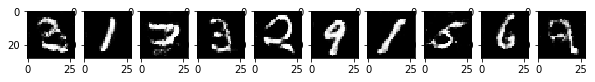

Epochs 5/10: Generator Loss: 3.584. Discriminator Loss: 0.369
Epochs 5/10: Generator Loss: 3.73. Discriminator Loss: 0.4
Epochs 5/10: Generator Loss: 3.75. Discriminator Loss: 0.407
Epochs 5/10: Generator Loss: 3.624. Discriminator Loss: 0.385
Epochs 5/10: Generator Loss: 3.482. Discriminator Loss: 0.382
Epochs 5/10: Generator Loss: 3.459. Discriminator Loss: 0.403
Epochs 5/10: Generator Loss: 3.534. Discriminator Loss: 0.403
Epochs 5/10: Generator Loss: 3.561. Discriminator Loss: 0.425
Epochs 5/10: Generator Loss: 3.456. Discriminator Loss: 0.398
Epochs 5/10: Generator Loss: 3.36. Discriminator Loss: 0.381


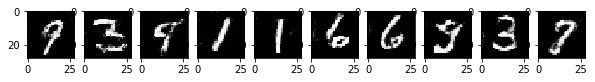

Epochs 5/10: Generator Loss: 3.401. Discriminator Loss: 0.408
Epochs 5/10: Generator Loss: 3.575. Discriminator Loss: 0.386
Epochs 5/10: Generator Loss: 3.621. Discriminator Loss: 0.378
Epochs 5/10: Generator Loss: 3.566. Discriminator Loss: 0.382
Epochs 5/10: Generator Loss: 3.51. Discriminator Loss: 0.437
Epochs 5/10: Generator Loss: 3.474. Discriminator Loss: 0.425
Epochs 5/10: Generator Loss: 3.556. Discriminator Loss: 0.387
Epochs 5/10: Generator Loss: 3.489. Discriminator Loss: 0.394
Epochs 5/10: Generator Loss: 3.678. Discriminator Loss: 0.423
Epochs 5/10: Generator Loss: 3.834. Discriminator Loss: 0.365


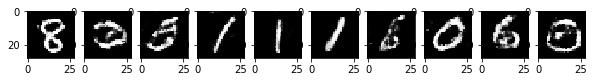

Epochs 5/10: Generator Loss: 3.71. Discriminator Loss: 0.363
Epochs 5/10: Generator Loss: 3.655. Discriminator Loss: 0.378
Epochs 5/10: Generator Loss: 3.797. Discriminator Loss: 0.475
Epochs 5/10: Generator Loss: 3.755. Discriminator Loss: 0.482
Epochs 5/10: Generator Loss: 3.697. Discriminator Loss: 0.386
Epochs 5/10: Generator Loss: 3.673. Discriminator Loss: 0.379
Epochs 5/10: Generator Loss: 3.709. Discriminator Loss: 0.547
Epochs 5/10: Generator Loss: 3.628. Discriminator Loss: 0.387
Epochs 5/10: Generator Loss: 3.786. Discriminator Loss: 0.385
Epochs 5/10: Generator Loss: 3.608. Discriminator Loss: 0.405


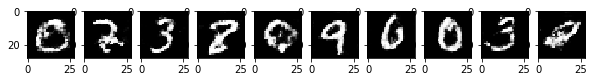

Epochs 5/10: Generator Loss: 3.445. Discriminator Loss: 0.404
Epochs 5/10: Generator Loss: 3.649. Discriminator Loss: 0.41
Epochs 5/10: Generator Loss: 3.57. Discriminator Loss: 0.383
Epochs 5/10: Generator Loss: 3.458. Discriminator Loss: 0.393
Epochs 6/10: Generator Loss: 3.05. Discriminator Loss: 1.088
Epochs 6/10: Generator Loss: 3.323. Discriminator Loss: 0.419
Epochs 6/10: Generator Loss: 3.38. Discriminator Loss: 0.382
Epochs 6/10: Generator Loss: 3.336. Discriminator Loss: 0.375
Epochs 6/10: Generator Loss: 3.482. Discriminator Loss: 0.417
Epochs 6/10: Generator Loss: 3.514. Discriminator Loss: 0.449


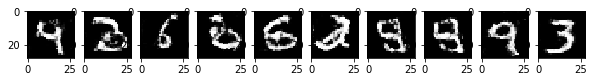

Epochs 6/10: Generator Loss: 3.733. Discriminator Loss: 0.394
Epochs 6/10: Generator Loss: 3.505. Discriminator Loss: 0.414
Epochs 6/10: Generator Loss: 3.958. Discriminator Loss: 0.399
Epochs 6/10: Generator Loss: 3.765. Discriminator Loss: 0.398
Epochs 6/10: Generator Loss: 3.979. Discriminator Loss: 0.375
Epochs 6/10: Generator Loss: 3.648. Discriminator Loss: 0.395
Epochs 6/10: Generator Loss: 3.642. Discriminator Loss: 0.385
Epochs 6/10: Generator Loss: 3.712. Discriminator Loss: 0.374
Epochs 6/10: Generator Loss: 3.576. Discriminator Loss: 0.367
Epochs 6/10: Generator Loss: 3.651. Discriminator Loss: 0.376


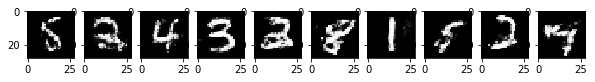

Epochs 6/10: Generator Loss: 3.499. Discriminator Loss: 0.373
Epochs 6/10: Generator Loss: 3.721. Discriminator Loss: 0.378
Epochs 6/10: Generator Loss: 3.49. Discriminator Loss: 0.443
Epochs 6/10: Generator Loss: 3.487. Discriminator Loss: 0.475
Epochs 6/10: Generator Loss: 3.483. Discriminator Loss: 0.393
Epochs 6/10: Generator Loss: 3.55. Discriminator Loss: 0.408
Epochs 6/10: Generator Loss: 3.83. Discriminator Loss: 0.368
Epochs 6/10: Generator Loss: 3.783. Discriminator Loss: 0.461
Epochs 6/10: Generator Loss: 3.729. Discriminator Loss: 0.392
Epochs 6/10: Generator Loss: 3.579. Discriminator Loss: 0.412


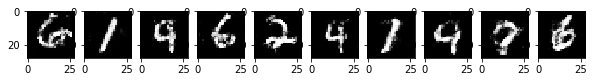

Epochs 6/10: Generator Loss: 3.484. Discriminator Loss: 0.378
Epochs 6/10: Generator Loss: 3.792. Discriminator Loss: 0.381
Epochs 6/10: Generator Loss: 3.524. Discriminator Loss: 0.417
Epochs 6/10: Generator Loss: 3.61. Discriminator Loss: 0.479
Epochs 6/10: Generator Loss: 3.76. Discriminator Loss: 0.387
Epochs 6/10: Generator Loss: 3.477. Discriminator Loss: 0.399
Epochs 6/10: Generator Loss: 3.446. Discriminator Loss: 0.383
Epochs 6/10: Generator Loss: 3.703. Discriminator Loss: 0.383
Epochs 6/10: Generator Loss: 3.798. Discriminator Loss: 0.398
Epochs 6/10: Generator Loss: 3.718. Discriminator Loss: 0.373


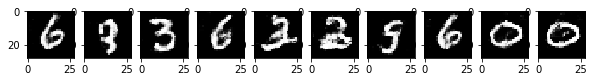

Epochs 6/10: Generator Loss: 3.732. Discriminator Loss: 0.371
Epochs 6/10: Generator Loss: 3.719. Discriminator Loss: 0.402
Epochs 6/10: Generator Loss: 3.459. Discriminator Loss: 0.452
Epochs 6/10: Generator Loss: 3.651. Discriminator Loss: 0.434
Epochs 6/10: Generator Loss: 3.579. Discriminator Loss: 0.396
Epochs 6/10: Generator Loss: 3.776. Discriminator Loss: 0.427
Epochs 6/10: Generator Loss: 3.566. Discriminator Loss: 0.419
Epochs 6/10: Generator Loss: 3.906. Discriminator Loss: 0.36
Epochs 6/10: Generator Loss: 3.883. Discriminator Loss: 0.464
Epochs 6/10: Generator Loss: 3.587. Discriminator Loss: 0.37


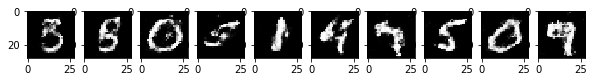

Epochs 6/10: Generator Loss: 3.62. Discriminator Loss: 0.382
Epochs 6/10: Generator Loss: 3.763. Discriminator Loss: 0.382
Epochs 6/10: Generator Loss: 3.611. Discriminator Loss: 0.439
Epochs 6/10: Generator Loss: 3.532. Discriminator Loss: 0.402
Epochs 6/10: Generator Loss: 3.828. Discriminator Loss: 0.395
Epochs 6/10: Generator Loss: 3.676. Discriminator Loss: 0.428
Epochs 6/10: Generator Loss: 3.525. Discriminator Loss: 0.383
Epochs 6/10: Generator Loss: 3.625. Discriminator Loss: 0.383
Epochs 6/10: Generator Loss: 3.597. Discriminator Loss: 0.367
Epochs 6/10: Generator Loss: 3.759. Discriminator Loss: 0.375


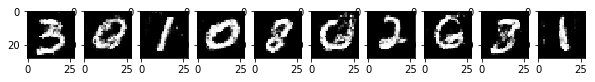

Epochs 6/10: Generator Loss: 3.803. Discriminator Loss: 0.371
Epochs 6/10: Generator Loss: 3.547. Discriminator Loss: 0.402
Epochs 6/10: Generator Loss: 4.044. Discriminator Loss: 0.371
Epochs 6/10: Generator Loss: 3.613. Discriminator Loss: 0.379
Epochs 6/10: Generator Loss: 3.601. Discriminator Loss: 0.394
Epochs 6/10: Generator Loss: 3.82. Discriminator Loss: 0.393
Epochs 6/10: Generator Loss: 3.674. Discriminator Loss: 0.365
Epochs 6/10: Generator Loss: 3.799. Discriminator Loss: 0.394
Epochs 6/10: Generator Loss: 3.576. Discriminator Loss: 0.406
Epochs 6/10: Generator Loss: 3.622. Discriminator Loss: 0.378


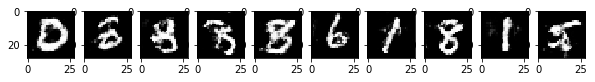

Epochs 6/10: Generator Loss: 3.949. Discriminator Loss: 0.374
Epochs 6/10: Generator Loss: 3.682. Discriminator Loss: 0.364
Epochs 6/10: Generator Loss: 3.92. Discriminator Loss: 0.389
Epochs 6/10: Generator Loss: 3.892. Discriminator Loss: 0.433
Epochs 6/10: Generator Loss: 3.572. Discriminator Loss: 0.387
Epochs 6/10: Generator Loss: 3.899. Discriminator Loss: 0.366
Epochs 6/10: Generator Loss: 3.555. Discriminator Loss: 0.388
Epochs 6/10: Generator Loss: 3.558. Discriminator Loss: 0.379
Epochs 6/10: Generator Loss: 3.829. Discriminator Loss: 0.372
Epochs 6/10: Generator Loss: 3.695. Discriminator Loss: 0.374


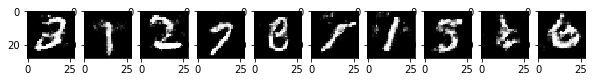

Epochs 6/10: Generator Loss: 3.977. Discriminator Loss: 0.434
Epochs 6/10: Generator Loss: 3.812. Discriminator Loss: 0.385
Epochs 6/10: Generator Loss: 4.229. Discriminator Loss: 0.362
Epochs 6/10: Generator Loss: 3.864. Discriminator Loss: 0.384
Epochs 6/10: Generator Loss: 3.835. Discriminator Loss: 0.375
Epochs 6/10: Generator Loss: 3.813. Discriminator Loss: 0.36
Epochs 6/10: Generator Loss: 3.789. Discriminator Loss: 0.373
Epochs 6/10: Generator Loss: 3.532. Discriminator Loss: 0.382
Epochs 6/10: Generator Loss: 3.569. Discriminator Loss: 0.39
Epochs 6/10: Generator Loss: 3.753. Discriminator Loss: 0.441


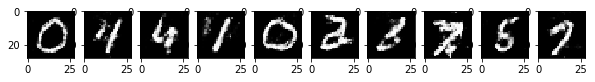

Epochs 6/10: Generator Loss: 3.855. Discriminator Loss: 0.407
Epochs 6/10: Generator Loss: 3.765. Discriminator Loss: 0.41
Epochs 6/10: Generator Loss: 3.84. Discriminator Loss: 0.392
Epochs 6/10: Generator Loss: 3.795. Discriminator Loss: 0.362
Epochs 6/10: Generator Loss: 3.711. Discriminator Loss: 0.386
Epochs 6/10: Generator Loss: 3.69. Discriminator Loss: 0.434
Epochs 6/10: Generator Loss: 3.891. Discriminator Loss: 0.413
Epochs 6/10: Generator Loss: 3.819. Discriminator Loss: 0.41
Epochs 6/10: Generator Loss: 3.888. Discriminator Loss: 0.361
Epochs 6/10: Generator Loss: 3.811. Discriminator Loss: 0.444


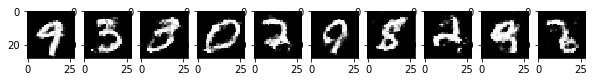

Epochs 6/10: Generator Loss: 3.299. Discriminator Loss: 0.456
Epochs 6/10: Generator Loss: 3.746. Discriminator Loss: 0.419
Epochs 6/10: Generator Loss: 3.703. Discriminator Loss: 0.431
Epochs 6/10: Generator Loss: 3.795. Discriminator Loss: 0.377
Epochs 6/10: Generator Loss: 3.597. Discriminator Loss: 0.366
Epochs 6/10: Generator Loss: 3.517. Discriminator Loss: 0.373
Epochs 6/10: Generator Loss: 3.762. Discriminator Loss: 0.375
Epochs 6/10: Generator Loss: 3.808. Discriminator Loss: 0.382
Epochs 6/10: Generator Loss: 3.97. Discriminator Loss: 0.37
Epochs 6/10: Generator Loss: 4.16. Discriminator Loss: 0.367


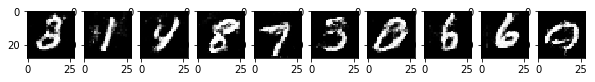

Epochs 6/10: Generator Loss: 3.697. Discriminator Loss: 0.393
Epochs 6/10: Generator Loss: 3.694. Discriminator Loss: 0.394
Epochs 6/10: Generator Loss: 3.614. Discriminator Loss: 0.391
Epochs 6/10: Generator Loss: 3.761. Discriminator Loss: 0.403
Epochs 6/10: Generator Loss: 4.051. Discriminator Loss: 0.405
Epochs 6/10: Generator Loss: 3.768. Discriminator Loss: 0.405
Epochs 6/10: Generator Loss: 3.973. Discriminator Loss: 0.386
Epochs 6/10: Generator Loss: 3.904. Discriminator Loss: 0.443
Epochs 6/10: Generator Loss: 3.663. Discriminator Loss: 0.391
Epochs 6/10: Generator Loss: 3.759. Discriminator Loss: 0.406


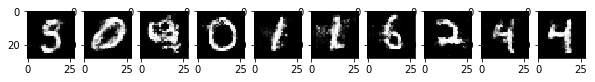

Epochs 6/10: Generator Loss: 3.928. Discriminator Loss: 0.426
Epochs 6/10: Generator Loss: 3.51. Discriminator Loss: 0.401
Epochs 6/10: Generator Loss: 3.647. Discriminator Loss: 0.407
Epochs 6/10: Generator Loss: 3.83. Discriminator Loss: 0.386
Epochs 6/10: Generator Loss: 3.691. Discriminator Loss: 0.375
Epochs 6/10: Generator Loss: 3.793. Discriminator Loss: 0.39
Epochs 6/10: Generator Loss: 3.709. Discriminator Loss: 0.414
Epochs 6/10: Generator Loss: 3.761. Discriminator Loss: 0.383
Epochs 6/10: Generator Loss: 3.799. Discriminator Loss: 0.378
Epochs 6/10: Generator Loss: 3.91. Discriminator Loss: 0.399


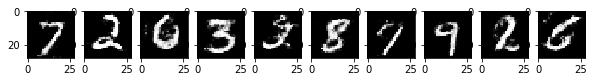

Epochs 6/10: Generator Loss: 3.704. Discriminator Loss: 0.394
Epochs 6/10: Generator Loss: 3.92. Discriminator Loss: 0.358
Epochs 6/10: Generator Loss: 3.729. Discriminator Loss: 0.375
Epochs 6/10: Generator Loss: 3.967. Discriminator Loss: 0.419
Epochs 6/10: Generator Loss: 4.022. Discriminator Loss: 0.386
Epochs 6/10: Generator Loss: 3.961. Discriminator Loss: 0.36
Epochs 6/10: Generator Loss: 3.77. Discriminator Loss: 0.555
Epochs 6/10: Generator Loss: 4.125. Discriminator Loss: 0.396
Epochs 6/10: Generator Loss: 3.903. Discriminator Loss: 0.42
Epochs 6/10: Generator Loss: 3.84. Discriminator Loss: 0.415


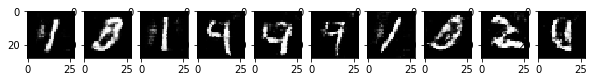

Epochs 6/10: Generator Loss: 3.753. Discriminator Loss: 0.392
Epochs 6/10: Generator Loss: 3.983. Discriminator Loss: 0.362
Epochs 6/10: Generator Loss: 3.761. Discriminator Loss: 0.389
Epochs 6/10: Generator Loss: 3.759. Discriminator Loss: 0.373
Epochs 6/10: Generator Loss: 3.955. Discriminator Loss: 0.406
Epochs 6/10: Generator Loss: 3.811. Discriminator Loss: 0.483
Epochs 6/10: Generator Loss: 3.902. Discriminator Loss: 0.403
Epochs 6/10: Generator Loss: 3.944. Discriminator Loss: 0.402
Epochs 6/10: Generator Loss: 4.04. Discriminator Loss: 0.393
Epochs 6/10: Generator Loss: 3.878. Discriminator Loss: 0.475


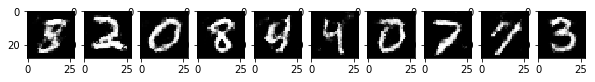

Epochs 6/10: Generator Loss: 4.055. Discriminator Loss: 0.385
Epochs 6/10: Generator Loss: 3.966. Discriminator Loss: 0.444
Epochs 6/10: Generator Loss: 3.796. Discriminator Loss: 0.41
Epochs 6/10: Generator Loss: 3.764. Discriminator Loss: 0.408
Epochs 6/10: Generator Loss: 3.922. Discriminator Loss: 0.376
Epochs 6/10: Generator Loss: 3.7. Discriminator Loss: 0.39
Epochs 6/10: Generator Loss: 3.978. Discriminator Loss: 0.42
Epochs 6/10: Generator Loss: 3.928. Discriminator Loss: 0.378
Epochs 6/10: Generator Loss: 3.908. Discriminator Loss: 0.377
Epochs 6/10: Generator Loss: 3.927. Discriminator Loss: 0.411


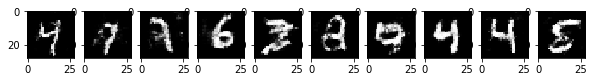

Epochs 6/10: Generator Loss: 3.807. Discriminator Loss: 0.363
Epochs 6/10: Generator Loss: 3.898. Discriminator Loss: 0.391
Epochs 6/10: Generator Loss: 3.705. Discriminator Loss: 0.375
Epochs 6/10: Generator Loss: 3.843. Discriminator Loss: 0.362
Epochs 6/10: Generator Loss: 3.898. Discriminator Loss: 0.406
Epochs 6/10: Generator Loss: 3.749. Discriminator Loss: 0.37
Epochs 6/10: Generator Loss: 3.836. Discriminator Loss: 0.362
Epochs 6/10: Generator Loss: 3.881. Discriminator Loss: 0.427
Epochs 6/10: Generator Loss: 3.562. Discriminator Loss: 0.538
Epochs 6/10: Generator Loss: 3.766. Discriminator Loss: 0.394


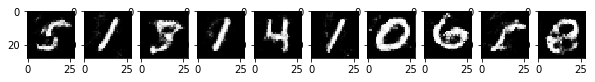

Epochs 6/10: Generator Loss: 3.954. Discriminator Loss: 0.407
Epochs 6/10: Generator Loss: 3.932. Discriminator Loss: 0.377
Epochs 6/10: Generator Loss: 3.882. Discriminator Loss: 0.39
Epochs 6/10: Generator Loss: 3.909. Discriminator Loss: 0.365
Epochs 6/10: Generator Loss: 3.709. Discriminator Loss: 0.394
Epochs 6/10: Generator Loss: 3.785. Discriminator Loss: 0.527
Epochs 6/10: Generator Loss: 3.508. Discriminator Loss: 0.458
Epochs 6/10: Generator Loss: 4.191. Discriminator Loss: 0.372
Epochs 6/10: Generator Loss: 3.797. Discriminator Loss: 0.374
Epochs 6/10: Generator Loss: 3.93. Discriminator Loss: 0.389


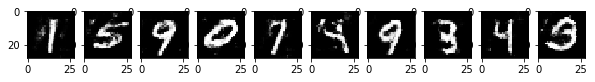

Epochs 6/10: Generator Loss: 3.985. Discriminator Loss: 0.367
Epochs 6/10: Generator Loss: 3.914. Discriminator Loss: 0.364
Epochs 6/10: Generator Loss: 3.96. Discriminator Loss: 0.462
Epochs 6/10: Generator Loss: 4.062. Discriminator Loss: 0.382
Epochs 6/10: Generator Loss: 3.557. Discriminator Loss: 0.482
Epochs 6/10: Generator Loss: 3.926. Discriminator Loss: 0.373
Epochs 6/10: Generator Loss: 3.964. Discriminator Loss: 0.358
Epochs 6/10: Generator Loss: 3.876. Discriminator Loss: 0.375
Epochs 6/10: Generator Loss: 3.7. Discriminator Loss: 0.383
Epochs 6/10: Generator Loss: 3.996. Discriminator Loss: 0.366


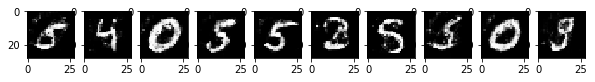

Epochs 6/10: Generator Loss: 3.943. Discriminator Loss: 0.36
Epochs 6/10: Generator Loss: 3.647. Discriminator Loss: 0.428
Epochs 7/10: Generator Loss: 3.203. Discriminator Loss: 0.455
Epochs 7/10: Generator Loss: 3.684. Discriminator Loss: 0.373
Epochs 7/10: Generator Loss: 3.528. Discriminator Loss: 0.375
Epochs 7/10: Generator Loss: 3.771. Discriminator Loss: 0.39
Epochs 7/10: Generator Loss: 3.931. Discriminator Loss: 0.405
Epochs 7/10: Generator Loss: 3.568. Discriminator Loss: 0.413
Epochs 7/10: Generator Loss: 4.174. Discriminator Loss: 0.372
Epochs 7/10: Generator Loss: 3.756. Discriminator Loss: 0.388


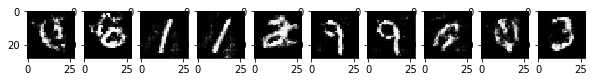

Epochs 7/10: Generator Loss: 4.038. Discriminator Loss: 0.47
Epochs 7/10: Generator Loss: 3.882. Discriminator Loss: 0.447
Epochs 7/10: Generator Loss: 3.749. Discriminator Loss: 0.386
Epochs 7/10: Generator Loss: 3.643. Discriminator Loss: 0.62
Epochs 7/10: Generator Loss: 3.506. Discriminator Loss: 0.412
Epochs 7/10: Generator Loss: 3.873. Discriminator Loss: 0.362
Epochs 7/10: Generator Loss: 3.731. Discriminator Loss: 0.418
Epochs 7/10: Generator Loss: 4.004. Discriminator Loss: 0.386
Epochs 7/10: Generator Loss: 4.045. Discriminator Loss: 0.382
Epochs 7/10: Generator Loss: 3.894. Discriminator Loss: 0.387


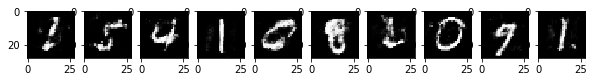

Epochs 7/10: Generator Loss: 3.838. Discriminator Loss: 0.368
Epochs 7/10: Generator Loss: 3.975. Discriminator Loss: 0.397
Epochs 7/10: Generator Loss: 3.936. Discriminator Loss: 0.411
Epochs 7/10: Generator Loss: 3.688. Discriminator Loss: 0.47
Epochs 7/10: Generator Loss: 3.861. Discriminator Loss: 0.394
Epochs 7/10: Generator Loss: 3.878. Discriminator Loss: 0.379
Epochs 7/10: Generator Loss: 4.064. Discriminator Loss: 0.376
Epochs 7/10: Generator Loss: 3.695. Discriminator Loss: 0.397
Epochs 7/10: Generator Loss: 4.063. Discriminator Loss: 0.367
Epochs 7/10: Generator Loss: 3.823. Discriminator Loss: 0.378


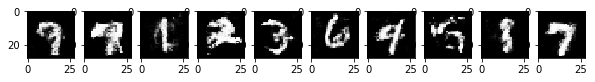

Epochs 7/10: Generator Loss: 3.864. Discriminator Loss: 0.613
Epochs 7/10: Generator Loss: 3.719. Discriminator Loss: 0.375
Epochs 7/10: Generator Loss: 3.807. Discriminator Loss: 0.371
Epochs 7/10: Generator Loss: 3.863. Discriminator Loss: 0.373
Epochs 7/10: Generator Loss: 3.859. Discriminator Loss: 0.37
Epochs 7/10: Generator Loss: 4.095. Discriminator Loss: 0.359
Epochs 7/10: Generator Loss: 3.968. Discriminator Loss: 0.38
Epochs 7/10: Generator Loss: 3.862. Discriminator Loss: 0.368
Epochs 7/10: Generator Loss: 3.974. Discriminator Loss: 0.377
Epochs 7/10: Generator Loss: 3.856. Discriminator Loss: 0.364


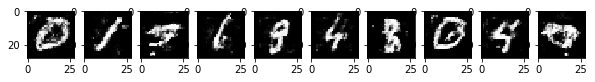

Epochs 7/10: Generator Loss: 3.996. Discriminator Loss: 0.413
Epochs 7/10: Generator Loss: 4.002. Discriminator Loss: 0.361
Epochs 7/10: Generator Loss: 4.001. Discriminator Loss: 0.387
Epochs 7/10: Generator Loss: 3.993. Discriminator Loss: 0.37
Epochs 7/10: Generator Loss: 3.698. Discriminator Loss: 0.415
Epochs 7/10: Generator Loss: 3.987. Discriminator Loss: 0.385
Epochs 7/10: Generator Loss: 3.817. Discriminator Loss: 0.449
Epochs 7/10: Generator Loss: 3.773. Discriminator Loss: 0.42
Epochs 7/10: Generator Loss: 3.836. Discriminator Loss: 0.372
Epochs 7/10: Generator Loss: 4.005. Discriminator Loss: 0.371


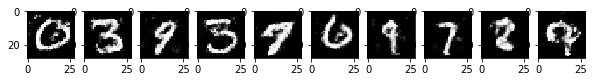

Epochs 7/10: Generator Loss: 3.844. Discriminator Loss: 0.417
Epochs 7/10: Generator Loss: 3.777. Discriminator Loss: 0.411
Epochs 7/10: Generator Loss: 3.981. Discriminator Loss: 0.376
Epochs 7/10: Generator Loss: 3.918. Discriminator Loss: 0.414
Epochs 7/10: Generator Loss: 3.799. Discriminator Loss: 0.389
Epochs 7/10: Generator Loss: 3.854. Discriminator Loss: 0.363
Epochs 7/10: Generator Loss: 3.753. Discriminator Loss: 0.395
Epochs 7/10: Generator Loss: 3.894. Discriminator Loss: 0.388
Epochs 7/10: Generator Loss: 3.848. Discriminator Loss: 0.379
Epochs 7/10: Generator Loss: 4.126. Discriminator Loss: 0.36


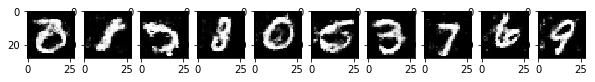

Epochs 7/10: Generator Loss: 3.862. Discriminator Loss: 0.417
Epochs 7/10: Generator Loss: 3.989. Discriminator Loss: 0.395
Epochs 7/10: Generator Loss: 3.777. Discriminator Loss: 0.428
Epochs 7/10: Generator Loss: 3.954. Discriminator Loss: 0.377
Epochs 7/10: Generator Loss: 3.817. Discriminator Loss: 0.359
Epochs 7/10: Generator Loss: 3.772. Discriminator Loss: 0.394
Epochs 7/10: Generator Loss: 3.918. Discriminator Loss: 0.424
Epochs 7/10: Generator Loss: 3.876. Discriminator Loss: 0.374
Epochs 7/10: Generator Loss: 4.029. Discriminator Loss: 0.41
Epochs 7/10: Generator Loss: 3.796. Discriminator Loss: 0.443


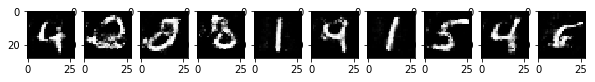

Epochs 7/10: Generator Loss: 3.622. Discriminator Loss: 0.427
Epochs 7/10: Generator Loss: 3.963. Discriminator Loss: 0.385
Epochs 7/10: Generator Loss: 3.792. Discriminator Loss: 0.393
Epochs 7/10: Generator Loss: 4.029. Discriminator Loss: 0.364
Epochs 7/10: Generator Loss: 3.831. Discriminator Loss: 0.46
Epochs 7/10: Generator Loss: 3.895. Discriminator Loss: 0.401
Epochs 7/10: Generator Loss: 4.141. Discriminator Loss: 0.369
Epochs 7/10: Generator Loss: 4.059. Discriminator Loss: 0.399
Epochs 7/10: Generator Loss: 3.997. Discriminator Loss: 0.359
Epochs 7/10: Generator Loss: 3.886. Discriminator Loss: 0.377


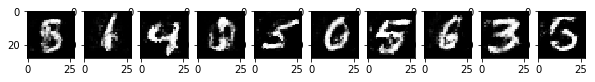

Epochs 7/10: Generator Loss: 4.292. Discriminator Loss: 0.374
Epochs 7/10: Generator Loss: 3.837. Discriminator Loss: 0.495
Epochs 7/10: Generator Loss: 3.664. Discriminator Loss: 0.367
Epochs 7/10: Generator Loss: 3.876. Discriminator Loss: 0.392
Epochs 7/10: Generator Loss: 4.168. Discriminator Loss: 0.358
Epochs 7/10: Generator Loss: 3.986. Discriminator Loss: 0.385
Epochs 7/10: Generator Loss: 3.698. Discriminator Loss: 0.374
Epochs 7/10: Generator Loss: 3.788. Discriminator Loss: 0.371
Epochs 7/10: Generator Loss: 4.096. Discriminator Loss: 0.372
Epochs 7/10: Generator Loss: 3.992. Discriminator Loss: 0.409


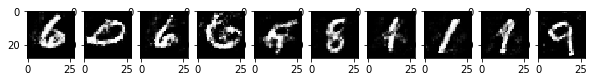

Epochs 7/10: Generator Loss: 4.04. Discriminator Loss: 0.422
Epochs 7/10: Generator Loss: 4.136. Discriminator Loss: 0.445
Epochs 7/10: Generator Loss: 4.124. Discriminator Loss: 0.379
Epochs 7/10: Generator Loss: 4.04. Discriminator Loss: 0.377
Epochs 7/10: Generator Loss: 3.805. Discriminator Loss: 0.39
Epochs 7/10: Generator Loss: 4.113. Discriminator Loss: 0.378
Epochs 7/10: Generator Loss: 3.807. Discriminator Loss: 0.614
Epochs 7/10: Generator Loss: 4.147. Discriminator Loss: 0.434
Epochs 7/10: Generator Loss: 4.149. Discriminator Loss: 0.366
Epochs 7/10: Generator Loss: 4.078. Discriminator Loss: 0.367


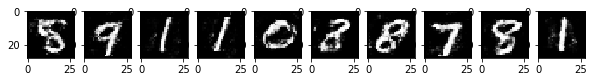

Epochs 7/10: Generator Loss: 4.06. Discriminator Loss: 0.361
Epochs 7/10: Generator Loss: 3.793. Discriminator Loss: 0.412
Epochs 7/10: Generator Loss: 4.267. Discriminator Loss: 0.363
Epochs 7/10: Generator Loss: 3.89. Discriminator Loss: 0.392
Epochs 7/10: Generator Loss: 3.946. Discriminator Loss: 0.421
Epochs 7/10: Generator Loss: 3.808. Discriminator Loss: 0.528
Epochs 7/10: Generator Loss: 4.002. Discriminator Loss: 0.383
Epochs 7/10: Generator Loss: 3.791. Discriminator Loss: 0.364
Epochs 7/10: Generator Loss: 4.039. Discriminator Loss: 0.389
Epochs 7/10: Generator Loss: 4.145. Discriminator Loss: 0.383


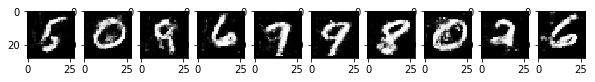

Epochs 7/10: Generator Loss: 3.821. Discriminator Loss: 0.39
Epochs 7/10: Generator Loss: 4.031. Discriminator Loss: 0.376
Epochs 7/10: Generator Loss: 4.012. Discriminator Loss: 0.538
Epochs 7/10: Generator Loss: 3.934. Discriminator Loss: 0.372
Epochs 7/10: Generator Loss: 3.926. Discriminator Loss: 0.483
Epochs 7/10: Generator Loss: 3.894. Discriminator Loss: 0.375
Epochs 7/10: Generator Loss: 3.914. Discriminator Loss: 0.373
Epochs 7/10: Generator Loss: 4.229. Discriminator Loss: 0.351
Epochs 7/10: Generator Loss: 3.903. Discriminator Loss: 0.38
Epochs 7/10: Generator Loss: 4.086. Discriminator Loss: 0.375


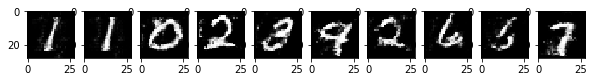

Epochs 7/10: Generator Loss: 3.863. Discriminator Loss: 0.389
Epochs 7/10: Generator Loss: 3.623. Discriminator Loss: 0.409
Epochs 7/10: Generator Loss: 3.528. Discriminator Loss: 0.418
Epochs 7/10: Generator Loss: 4.128. Discriminator Loss: 0.367
Epochs 7/10: Generator Loss: 4.003. Discriminator Loss: 0.375
Epochs 7/10: Generator Loss: 3.916. Discriminator Loss: 0.401
Epochs 7/10: Generator Loss: 4.219. Discriminator Loss: 0.393
Epochs 7/10: Generator Loss: 3.667. Discriminator Loss: 0.424
Epochs 7/10: Generator Loss: 4.047. Discriminator Loss: 0.362
Epochs 7/10: Generator Loss: 4.028. Discriminator Loss: 0.355


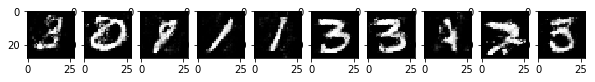

Epochs 7/10: Generator Loss: 4.361. Discriminator Loss: 0.383
Epochs 7/10: Generator Loss: 4.055. Discriminator Loss: 0.377
Epochs 7/10: Generator Loss: 4.324. Discriminator Loss: 0.373
Epochs 7/10: Generator Loss: 4.304. Discriminator Loss: 0.352
Epochs 7/10: Generator Loss: 4.31. Discriminator Loss: 0.369
Epochs 7/10: Generator Loss: 3.948. Discriminator Loss: 0.371
Epochs 7/10: Generator Loss: 3.832. Discriminator Loss: 0.367
Epochs 7/10: Generator Loss: 3.95. Discriminator Loss: 0.382
Epochs 7/10: Generator Loss: 4.11. Discriminator Loss: 0.353
Epochs 7/10: Generator Loss: 3.856. Discriminator Loss: 0.397


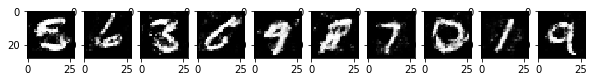

Epochs 7/10: Generator Loss: 4.061. Discriminator Loss: 0.358
Epochs 7/10: Generator Loss: 3.924. Discriminator Loss: 0.381
Epochs 7/10: Generator Loss: 3.847. Discriminator Loss: 0.41
Epochs 7/10: Generator Loss: 3.801. Discriminator Loss: 0.384
Epochs 7/10: Generator Loss: 4.034. Discriminator Loss: 0.35
Epochs 7/10: Generator Loss: 3.941. Discriminator Loss: 0.373
Epochs 7/10: Generator Loss: 3.714. Discriminator Loss: 0.577
Epochs 7/10: Generator Loss: 3.909. Discriminator Loss: 0.388
Epochs 7/10: Generator Loss: 3.976. Discriminator Loss: 0.374
Epochs 7/10: Generator Loss: 4.21. Discriminator Loss: 0.386


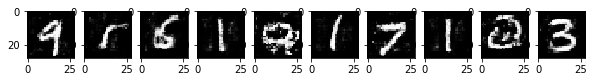

Epochs 7/10: Generator Loss: 4.179. Discriminator Loss: 0.375
Epochs 7/10: Generator Loss: 3.868. Discriminator Loss: 0.409
Epochs 7/10: Generator Loss: 4.061. Discriminator Loss: 0.389
Epochs 7/10: Generator Loss: 4.066. Discriminator Loss: 0.397
Epochs 7/10: Generator Loss: 3.907. Discriminator Loss: 0.373
Epochs 7/10: Generator Loss: 4.069. Discriminator Loss: 0.376
Epochs 7/10: Generator Loss: 4.2. Discriminator Loss: 0.399
Epochs 7/10: Generator Loss: 3.848. Discriminator Loss: 0.422
Epochs 7/10: Generator Loss: 3.918. Discriminator Loss: 0.461
Epochs 7/10: Generator Loss: 4.213. Discriminator Loss: 0.377


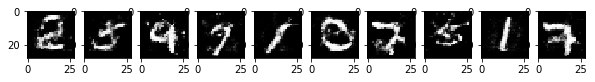

Epochs 7/10: Generator Loss: 4.092. Discriminator Loss: 0.371
Epochs 7/10: Generator Loss: 4.066. Discriminator Loss: 0.371
Epochs 7/10: Generator Loss: 3.986. Discriminator Loss: 0.381
Epochs 7/10: Generator Loss: 4.087. Discriminator Loss: 0.38
Epochs 7/10: Generator Loss: 4.014. Discriminator Loss: 0.372
Epochs 7/10: Generator Loss: 3.677. Discriminator Loss: 0.428
Epochs 7/10: Generator Loss: 4.165. Discriminator Loss: 0.39
Epochs 7/10: Generator Loss: 4.118. Discriminator Loss: 0.384
Epochs 7/10: Generator Loss: 4.028. Discriminator Loss: 0.363
Epochs 7/10: Generator Loss: 4.018. Discriminator Loss: 0.358


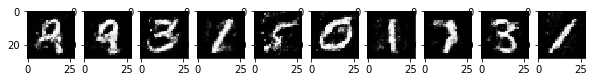

Epochs 7/10: Generator Loss: 4.095. Discriminator Loss: 0.371
Epochs 7/10: Generator Loss: 3.99. Discriminator Loss: 0.401
Epochs 7/10: Generator Loss: 4.173. Discriminator Loss: 0.359
Epochs 7/10: Generator Loss: 4.102. Discriminator Loss: 0.412
Epochs 7/10: Generator Loss: 4.15. Discriminator Loss: 0.356
Epochs 7/10: Generator Loss: 4.45. Discriminator Loss: 0.364
Epochs 7/10: Generator Loss: 4.167. Discriminator Loss: 0.397
Epochs 7/10: Generator Loss: 4.261. Discriminator Loss: 0.384
Epochs 7/10: Generator Loss: 4.244. Discriminator Loss: 0.425
Epochs 7/10: Generator Loss: 4.204. Discriminator Loss: 0.358


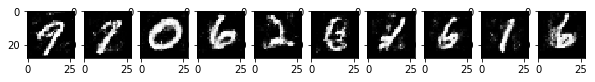

Epochs 7/10: Generator Loss: 3.792. Discriminator Loss: 0.431
Epochs 7/10: Generator Loss: 4.014. Discriminator Loss: 0.357
Epochs 7/10: Generator Loss: 4.43. Discriminator Loss: 0.349
Epochs 7/10: Generator Loss: 4.205. Discriminator Loss: 0.384
Epochs 7/10: Generator Loss: 4.106. Discriminator Loss: 0.361
Epochs 7/10: Generator Loss: 4.136. Discriminator Loss: 0.366
Epochs 7/10: Generator Loss: 4.128. Discriminator Loss: 0.353
Epochs 7/10: Generator Loss: 4.103. Discriminator Loss: 0.362
Epochs 7/10: Generator Loss: 4.074. Discriminator Loss: 0.355
Epochs 8/10: Generator Loss: 3.751. Discriminator Loss: 0.682


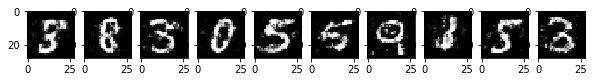

Epochs 8/10: Generator Loss: 3.6. Discriminator Loss: 0.366
Epochs 8/10: Generator Loss: 3.982. Discriminator Loss: 0.363
Epochs 8/10: Generator Loss: 4.02. Discriminator Loss: 0.354
Epochs 8/10: Generator Loss: 3.736. Discriminator Loss: 0.369
Epochs 8/10: Generator Loss: 4.104. Discriminator Loss: 0.375
Epochs 8/10: Generator Loss: 4.096. Discriminator Loss: 0.381
Epochs 8/10: Generator Loss: 4.059. Discriminator Loss: 0.372
Epochs 8/10: Generator Loss: 4.218. Discriminator Loss: 0.36
Epochs 8/10: Generator Loss: 3.89. Discriminator Loss: 0.565
Epochs 8/10: Generator Loss: 4.027. Discriminator Loss: 0.362


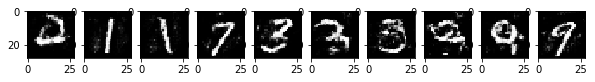

Epochs 8/10: Generator Loss: 4.255. Discriminator Loss: 0.381
Epochs 8/10: Generator Loss: 3.932. Discriminator Loss: 0.383
Epochs 8/10: Generator Loss: 4.109. Discriminator Loss: 0.37
Epochs 8/10: Generator Loss: 4.429. Discriminator Loss: 0.352
Epochs 8/10: Generator Loss: 4.218. Discriminator Loss: 0.369
Epochs 8/10: Generator Loss: 3.874. Discriminator Loss: 0.365
Epochs 8/10: Generator Loss: 4.087. Discriminator Loss: 0.358
Epochs 8/10: Generator Loss: 4.086. Discriminator Loss: 0.371
Epochs 8/10: Generator Loss: 3.743. Discriminator Loss: 0.467
Epochs 8/10: Generator Loss: 4.26. Discriminator Loss: 0.368


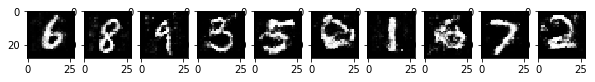

Epochs 8/10: Generator Loss: 4.194. Discriminator Loss: 0.379
Epochs 8/10: Generator Loss: 4.3. Discriminator Loss: 0.527
Epochs 8/10: Generator Loss: 4.048. Discriminator Loss: 0.363
Epochs 8/10: Generator Loss: 4.098. Discriminator Loss: 0.381
Epochs 8/10: Generator Loss: 3.993. Discriminator Loss: 0.377
Epochs 8/10: Generator Loss: 4.115. Discriminator Loss: 0.359
Epochs 8/10: Generator Loss: 4.193. Discriminator Loss: 0.368
Epochs 8/10: Generator Loss: 4.193. Discriminator Loss: 0.367
Epochs 8/10: Generator Loss: 3.707. Discriminator Loss: 0.754
Epochs 8/10: Generator Loss: 3.98. Discriminator Loss: 0.457


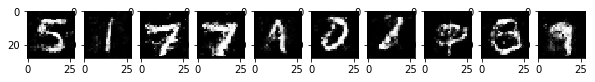

Epochs 8/10: Generator Loss: 4.249. Discriminator Loss: 0.412
Epochs 8/10: Generator Loss: 4.118. Discriminator Loss: 0.364
Epochs 8/10: Generator Loss: 4.385. Discriminator Loss: 0.356
Epochs 8/10: Generator Loss: 4.239. Discriminator Loss: 0.375
Epochs 8/10: Generator Loss: 4.385. Discriminator Loss: 0.357
Epochs 8/10: Generator Loss: 4.321. Discriminator Loss: 0.389
Epochs 8/10: Generator Loss: 4.417. Discriminator Loss: 0.379
Epochs 8/10: Generator Loss: 4.246. Discriminator Loss: 0.376
Epochs 8/10: Generator Loss: 4.294. Discriminator Loss: 0.421
Epochs 8/10: Generator Loss: 4.095. Discriminator Loss: 0.355


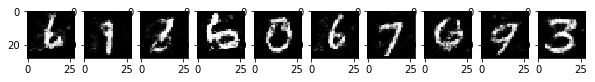

Epochs 8/10: Generator Loss: 4.383. Discriminator Loss: 0.376
Epochs 8/10: Generator Loss: 4.054. Discriminator Loss: 0.389
Epochs 8/10: Generator Loss: 3.817. Discriminator Loss: 0.453
Epochs 8/10: Generator Loss: 4.052. Discriminator Loss: 0.371
Epochs 8/10: Generator Loss: 4.029. Discriminator Loss: 0.366
Epochs 8/10: Generator Loss: 3.969. Discriminator Loss: 0.4
Epochs 8/10: Generator Loss: 4.287. Discriminator Loss: 0.36
Epochs 8/10: Generator Loss: 4.05. Discriminator Loss: 0.374
Epochs 8/10: Generator Loss: 4.03. Discriminator Loss: 0.379
Epochs 8/10: Generator Loss: 3.923. Discriminator Loss: 0.398


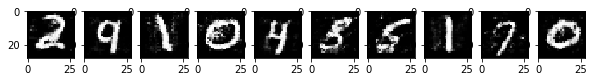

Epochs 8/10: Generator Loss: 4.305. Discriminator Loss: 0.355
Epochs 8/10: Generator Loss: 3.952. Discriminator Loss: 0.61
Epochs 8/10: Generator Loss: 3.892. Discriminator Loss: 0.424
Epochs 8/10: Generator Loss: 4.12. Discriminator Loss: 0.352
Epochs 8/10: Generator Loss: 3.996. Discriminator Loss: 0.371
Epochs 8/10: Generator Loss: 4.133. Discriminator Loss: 0.366
Epochs 8/10: Generator Loss: 4.005. Discriminator Loss: 0.367
Epochs 8/10: Generator Loss: 4.015. Discriminator Loss: 0.356
Epochs 8/10: Generator Loss: 4.159. Discriminator Loss: 0.362
Epochs 8/10: Generator Loss: 3.96. Discriminator Loss: 0.374


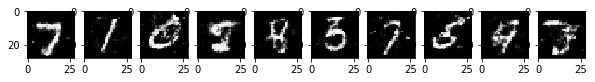

Epochs 8/10: Generator Loss: 3.734. Discriminator Loss: 0.411
Epochs 8/10: Generator Loss: 4.107. Discriminator Loss: 0.376
Epochs 8/10: Generator Loss: 3.89. Discriminator Loss: 0.37
Epochs 8/10: Generator Loss: 4.255. Discriminator Loss: 0.432
Epochs 8/10: Generator Loss: 3.994. Discriminator Loss: 0.401
Epochs 8/10: Generator Loss: 4.335. Discriminator Loss: 0.355
Epochs 8/10: Generator Loss: 4.343. Discriminator Loss: 0.347
Epochs 8/10: Generator Loss: 4.254. Discriminator Loss: 0.363
Epochs 8/10: Generator Loss: 4.096. Discriminator Loss: 0.392
Epochs 8/10: Generator Loss: 4.287. Discriminator Loss: 0.36


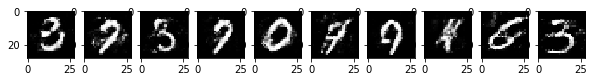

Epochs 8/10: Generator Loss: 4.121. Discriminator Loss: 0.37
Epochs 8/10: Generator Loss: 3.994. Discriminator Loss: 0.401
Epochs 8/10: Generator Loss: 4.084. Discriminator Loss: 0.389
Epochs 8/10: Generator Loss: 3.997. Discriminator Loss: 0.414
Epochs 8/10: Generator Loss: 3.961. Discriminator Loss: 0.387
Epochs 8/10: Generator Loss: 4.171. Discriminator Loss: 0.375
Epochs 8/10: Generator Loss: 4.271. Discriminator Loss: 0.38
Epochs 8/10: Generator Loss: 4.371. Discriminator Loss: 0.397
Epochs 8/10: Generator Loss: 4.363. Discriminator Loss: 0.363
Epochs 8/10: Generator Loss: 4.14. Discriminator Loss: 0.435


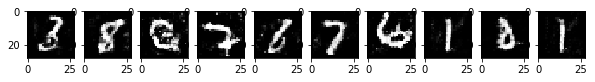

Epochs 8/10: Generator Loss: 4.196. Discriminator Loss: 0.362
Epochs 8/10: Generator Loss: 4.273. Discriminator Loss: 0.351
Epochs 8/10: Generator Loss: 3.986. Discriminator Loss: 0.406
Epochs 8/10: Generator Loss: 4.135. Discriminator Loss: 0.357
Epochs 8/10: Generator Loss: 4.327. Discriminator Loss: 0.366
Epochs 8/10: Generator Loss: 3.86. Discriminator Loss: 0.368
Epochs 8/10: Generator Loss: 4.168. Discriminator Loss: 0.408
Epochs 8/10: Generator Loss: 4.166. Discriminator Loss: 0.352
Epochs 8/10: Generator Loss: 4.556. Discriminator Loss: 0.343
Epochs 8/10: Generator Loss: 4.344. Discriminator Loss: 0.37


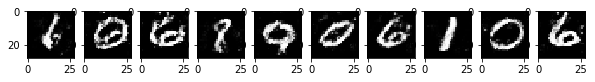

Epochs 8/10: Generator Loss: 4.129. Discriminator Loss: 0.505
Epochs 8/10: Generator Loss: 3.987. Discriminator Loss: 0.386
Epochs 8/10: Generator Loss: 4.123. Discriminator Loss: 0.354
Epochs 8/10: Generator Loss: 4.078. Discriminator Loss: 0.349
Epochs 8/10: Generator Loss: 4.258. Discriminator Loss: 0.379
Epochs 8/10: Generator Loss: 4.168. Discriminator Loss: 0.357
Epochs 8/10: Generator Loss: 4.312. Discriminator Loss: 0.375
Epochs 8/10: Generator Loss: 4.202. Discriminator Loss: 0.534
Epochs 8/10: Generator Loss: 4.212. Discriminator Loss: 0.357
Epochs 8/10: Generator Loss: 4.026. Discriminator Loss: 0.357


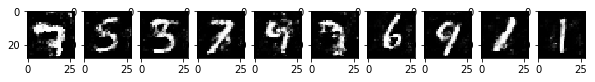

Epochs 8/10: Generator Loss: 3.851. Discriminator Loss: 0.36
Epochs 8/10: Generator Loss: 4.16. Discriminator Loss: 0.369
Epochs 8/10: Generator Loss: 4.207. Discriminator Loss: 0.392
Epochs 8/10: Generator Loss: 4.091. Discriminator Loss: 0.356
Epochs 8/10: Generator Loss: 4.047. Discriminator Loss: 0.366
Epochs 8/10: Generator Loss: 4.1. Discriminator Loss: 0.359
Epochs 8/10: Generator Loss: 4.182. Discriminator Loss: 0.382
Epochs 8/10: Generator Loss: 3.988. Discriminator Loss: 0.38
Epochs 8/10: Generator Loss: 4.007. Discriminator Loss: 0.386
Epochs 8/10: Generator Loss: 4.264. Discriminator Loss: 0.358


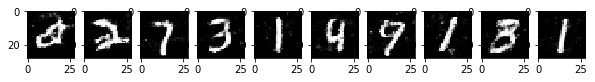

Epochs 8/10: Generator Loss: 4.077. Discriminator Loss: 0.382
Epochs 8/10: Generator Loss: 4.316. Discriminator Loss: 0.365
Epochs 8/10: Generator Loss: 4.091. Discriminator Loss: 0.414
Epochs 8/10: Generator Loss: 4.334. Discriminator Loss: 0.358
Epochs 8/10: Generator Loss: 4.009. Discriminator Loss: 0.354
Epochs 8/10: Generator Loss: 3.99. Discriminator Loss: 0.406
Epochs 8/10: Generator Loss: 4.288. Discriminator Loss: 0.408
Epochs 8/10: Generator Loss: 4.026. Discriminator Loss: 0.355
Epochs 8/10: Generator Loss: 4.146. Discriminator Loss: 0.397
Epochs 8/10: Generator Loss: 3.979. Discriminator Loss: 0.382


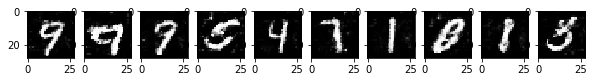

Epochs 8/10: Generator Loss: 4.05. Discriminator Loss: 0.363
Epochs 8/10: Generator Loss: 4.0. Discriminator Loss: 0.51
Epochs 8/10: Generator Loss: 4.19. Discriminator Loss: 0.366
Epochs 8/10: Generator Loss: 4.173. Discriminator Loss: 0.369
Epochs 8/10: Generator Loss: 4.344. Discriminator Loss: 0.368
Epochs 8/10: Generator Loss: 4.181. Discriminator Loss: 0.397
Epochs 8/10: Generator Loss: 4.111. Discriminator Loss: 0.349
Epochs 8/10: Generator Loss: 4.522. Discriminator Loss: 0.359
Epochs 8/10: Generator Loss: 4.077. Discriminator Loss: 0.392
Epochs 8/10: Generator Loss: 3.822. Discriminator Loss: 0.383


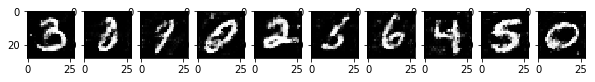

Epochs 8/10: Generator Loss: 4.223. Discriminator Loss: 0.356
Epochs 8/10: Generator Loss: 4.257. Discriminator Loss: 0.366
Epochs 8/10: Generator Loss: 4.211. Discriminator Loss: 0.392
Epochs 8/10: Generator Loss: 4.188. Discriminator Loss: 0.363
Epochs 8/10: Generator Loss: 4.278. Discriminator Loss: 0.387
Epochs 8/10: Generator Loss: 4.171. Discriminator Loss: 0.377
Epochs 8/10: Generator Loss: 4.256. Discriminator Loss: 0.379
Epochs 8/10: Generator Loss: 4.156. Discriminator Loss: 0.356
Epochs 8/10: Generator Loss: 4.169. Discriminator Loss: 0.376
Epochs 8/10: Generator Loss: 4.339. Discriminator Loss: 0.405


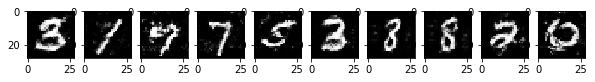

Epochs 8/10: Generator Loss: 4.368. Discriminator Loss: 0.387
Epochs 8/10: Generator Loss: 4.157. Discriminator Loss: 0.363
Epochs 8/10: Generator Loss: 4.128. Discriminator Loss: 0.383
Epochs 8/10: Generator Loss: 4.286. Discriminator Loss: 0.37
Epochs 8/10: Generator Loss: 4.06. Discriminator Loss: 0.485
Epochs 8/10: Generator Loss: 4.105. Discriminator Loss: 0.374
Epochs 8/10: Generator Loss: 4.315. Discriminator Loss: 0.386
Epochs 8/10: Generator Loss: 4.159. Discriminator Loss: 0.373
Epochs 8/10: Generator Loss: 3.986. Discriminator Loss: 0.412
Epochs 8/10: Generator Loss: 4.343. Discriminator Loss: 0.378


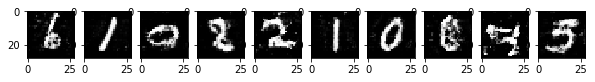

Epochs 8/10: Generator Loss: 4.211. Discriminator Loss: 0.357
Epochs 8/10: Generator Loss: 4.049. Discriminator Loss: 0.39
Epochs 8/10: Generator Loss: 4.386. Discriminator Loss: 0.35
Epochs 8/10: Generator Loss: 4.421. Discriminator Loss: 0.382
Epochs 8/10: Generator Loss: 4.319. Discriminator Loss: 0.359
Epochs 8/10: Generator Loss: 4.394. Discriminator Loss: 0.359
Epochs 8/10: Generator Loss: 4.392. Discriminator Loss: 0.359
Epochs 8/10: Generator Loss: 4.275. Discriminator Loss: 0.36
Epochs 8/10: Generator Loss: 4.234. Discriminator Loss: 0.355
Epochs 8/10: Generator Loss: 4.303. Discriminator Loss: 0.405


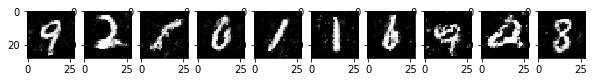

Epochs 8/10: Generator Loss: 4.252. Discriminator Loss: 0.397
Epochs 8/10: Generator Loss: 4.435. Discriminator Loss: 0.347
Epochs 8/10: Generator Loss: 4.169. Discriminator Loss: 0.391
Epochs 8/10: Generator Loss: 4.277. Discriminator Loss: 0.421
Epochs 8/10: Generator Loss: 4.227. Discriminator Loss: 0.36
Epochs 8/10: Generator Loss: 3.952. Discriminator Loss: 0.475
Epochs 8/10: Generator Loss: 4.343. Discriminator Loss: 0.367
Epochs 8/10: Generator Loss: 4.039. Discriminator Loss: 0.427
Epochs 8/10: Generator Loss: 4.043. Discriminator Loss: 0.364
Epochs 8/10: Generator Loss: 4.468. Discriminator Loss: 0.348


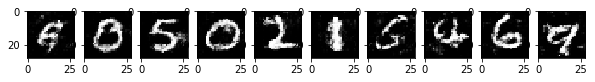

Epochs 8/10: Generator Loss: 4.308. Discriminator Loss: 0.389
Epochs 8/10: Generator Loss: 4.247. Discriminator Loss: 0.363
Epochs 8/10: Generator Loss: 4.242. Discriminator Loss: 0.37
Epochs 8/10: Generator Loss: 4.52. Discriminator Loss: 0.366
Epochs 8/10: Generator Loss: 4.395. Discriminator Loss: 0.387
Epochs 8/10: Generator Loss: 4.198. Discriminator Loss: 0.361
Epochs 8/10: Generator Loss: 4.285. Discriminator Loss: 0.371
Epochs 8/10: Generator Loss: 4.401. Discriminator Loss: 0.382
Epochs 8/10: Generator Loss: 4.327. Discriminator Loss: 0.394
Epochs 8/10: Generator Loss: 4.18. Discriminator Loss: 0.423


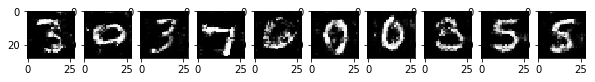

Epochs 8/10: Generator Loss: 4.339. Discriminator Loss: 0.352
Epochs 8/10: Generator Loss: 4.397. Discriminator Loss: 0.359
Epochs 8/10: Generator Loss: 4.102. Discriminator Loss: 0.532
Epochs 8/10: Generator Loss: 4.396. Discriminator Loss: 0.354
Epochs 8/10: Generator Loss: 4.384. Discriminator Loss: 0.347
Epochs 8/10: Generator Loss: 4.265. Discriminator Loss: 0.365
Epochs 8/10: Generator Loss: 4.295. Discriminator Loss: 0.366
Epochs 9/10: Generator Loss: 4.029. Discriminator Loss: 1.114
Epochs 9/10: Generator Loss: 4.46. Discriminator Loss: 0.404
Epochs 9/10: Generator Loss: 4.357. Discriminator Loss: 0.375


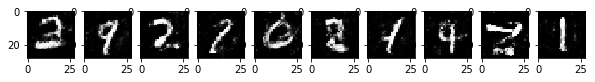

Epochs 9/10: Generator Loss: 4.627. Discriminator Loss: 0.397
Epochs 9/10: Generator Loss: 4.435. Discriminator Loss: 0.376
Epochs 9/10: Generator Loss: 4.256. Discriminator Loss: 0.401
Epochs 9/10: Generator Loss: 4.288. Discriminator Loss: 0.367
Epochs 9/10: Generator Loss: 4.48. Discriminator Loss: 0.353
Epochs 9/10: Generator Loss: 4.125. Discriminator Loss: 0.401
Epochs 9/10: Generator Loss: 4.352. Discriminator Loss: 0.366
Epochs 9/10: Generator Loss: 4.356. Discriminator Loss: 0.357
Epochs 9/10: Generator Loss: 4.274. Discriminator Loss: 0.383
Epochs 9/10: Generator Loss: 4.361. Discriminator Loss: 0.352


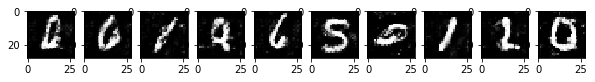

Epochs 9/10: Generator Loss: 4.42. Discriminator Loss: 0.373
Epochs 9/10: Generator Loss: 4.24. Discriminator Loss: 0.35
Epochs 9/10: Generator Loss: 4.089. Discriminator Loss: 0.372
Epochs 9/10: Generator Loss: 4.297. Discriminator Loss: 0.358
Epochs 9/10: Generator Loss: 4.017. Discriminator Loss: 0.365
Epochs 9/10: Generator Loss: 4.09. Discriminator Loss: 0.43
Epochs 9/10: Generator Loss: 4.18. Discriminator Loss: 0.58
Epochs 9/10: Generator Loss: 4.007. Discriminator Loss: 0.367
Epochs 9/10: Generator Loss: 4.126. Discriminator Loss: 0.397
Epochs 9/10: Generator Loss: 4.395. Discriminator Loss: 0.357


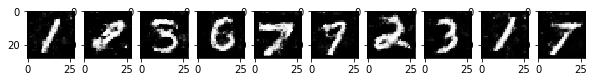

Epochs 9/10: Generator Loss: 4.086. Discriminator Loss: 0.403
Epochs 9/10: Generator Loss: 4.119. Discriminator Loss: 0.4
Epochs 9/10: Generator Loss: 4.219. Discriminator Loss: 0.371
Epochs 9/10: Generator Loss: 4.318. Discriminator Loss: 0.35
Epochs 9/10: Generator Loss: 4.071. Discriminator Loss: 0.402
Epochs 9/10: Generator Loss: 4.328. Discriminator Loss: 0.358
Epochs 9/10: Generator Loss: 4.37. Discriminator Loss: 0.429
Epochs 9/10: Generator Loss: 4.504. Discriminator Loss: 0.362
Epochs 9/10: Generator Loss: 4.174. Discriminator Loss: 0.411
Epochs 9/10: Generator Loss: 4.423. Discriminator Loss: 0.384


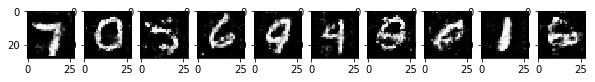

Epochs 9/10: Generator Loss: 4.304. Discriminator Loss: 0.386
Epochs 9/10: Generator Loss: 4.249. Discriminator Loss: 0.383
Epochs 9/10: Generator Loss: 4.306. Discriminator Loss: 0.362
Epochs 9/10: Generator Loss: 4.572. Discriminator Loss: 0.389
Epochs 9/10: Generator Loss: 4.327. Discriminator Loss: 0.357
Epochs 9/10: Generator Loss: 4.276. Discriminator Loss: 0.35
Epochs 9/10: Generator Loss: 4.252. Discriminator Loss: 0.358
Epochs 9/10: Generator Loss: 4.468. Discriminator Loss: 0.383
Epochs 9/10: Generator Loss: 4.41. Discriminator Loss: 0.37
Epochs 9/10: Generator Loss: 4.548. Discriminator Loss: 0.357


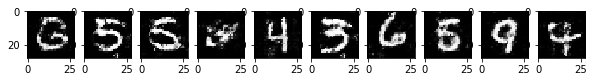

Epochs 9/10: Generator Loss: 4.525. Discriminator Loss: 0.344
Epochs 9/10: Generator Loss: 4.218. Discriminator Loss: 0.405
Epochs 9/10: Generator Loss: 4.419. Discriminator Loss: 0.357
Epochs 9/10: Generator Loss: 4.234. Discriminator Loss: 0.377
Epochs 9/10: Generator Loss: 4.128. Discriminator Loss: 0.365
Epochs 9/10: Generator Loss: 4.294. Discriminator Loss: 0.353
Epochs 9/10: Generator Loss: 4.544. Discriminator Loss: 0.344
Epochs 9/10: Generator Loss: 4.377. Discriminator Loss: 0.354
Epochs 9/10: Generator Loss: 4.228. Discriminator Loss: 0.387
Epochs 9/10: Generator Loss: 4.339. Discriminator Loss: 0.351


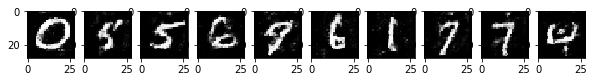

Epochs 9/10: Generator Loss: 4.457. Discriminator Loss: 0.359
Epochs 9/10: Generator Loss: 3.942. Discriminator Loss: 0.366
Epochs 9/10: Generator Loss: 3.763. Discriminator Loss: 0.456
Epochs 9/10: Generator Loss: 3.995. Discriminator Loss: 0.386
Epochs 9/10: Generator Loss: 4.209. Discriminator Loss: 0.392
Epochs 9/10: Generator Loss: 4.113. Discriminator Loss: 0.36
Epochs 9/10: Generator Loss: 4.048. Discriminator Loss: 0.42
Epochs 9/10: Generator Loss: 3.966. Discriminator Loss: 0.463
Epochs 9/10: Generator Loss: 4.321. Discriminator Loss: 0.35
Epochs 9/10: Generator Loss: 4.379. Discriminator Loss: 0.35


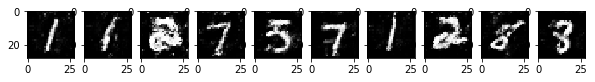

Epochs 9/10: Generator Loss: 4.265. Discriminator Loss: 0.393
Epochs 9/10: Generator Loss: 4.036. Discriminator Loss: 0.422
Epochs 9/10: Generator Loss: 4.285. Discriminator Loss: 0.359
Epochs 9/10: Generator Loss: 4.279. Discriminator Loss: 0.521
Epochs 9/10: Generator Loss: 4.261. Discriminator Loss: 0.381
Epochs 9/10: Generator Loss: 4.545. Discriminator Loss: 0.355
Epochs 9/10: Generator Loss: 4.338. Discriminator Loss: 0.41
Epochs 9/10: Generator Loss: 4.449. Discriminator Loss: 0.563
Epochs 9/10: Generator Loss: 4.582. Discriminator Loss: 0.358
Epochs 9/10: Generator Loss: 4.312. Discriminator Loss: 0.436


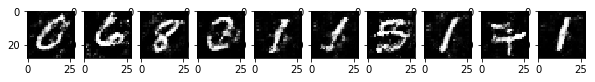

Epochs 9/10: Generator Loss: 4.454. Discriminator Loss: 0.353
Epochs 9/10: Generator Loss: 4.338. Discriminator Loss: 0.378
Epochs 9/10: Generator Loss: 4.277. Discriminator Loss: 0.384
Epochs 9/10: Generator Loss: 4.412. Discriminator Loss: 0.375
Epochs 9/10: Generator Loss: 4.56. Discriminator Loss: 0.374
Epochs 9/10: Generator Loss: 4.326. Discriminator Loss: 0.361
Epochs 9/10: Generator Loss: 4.117. Discriminator Loss: 0.402
Epochs 9/10: Generator Loss: 4.333. Discriminator Loss: 0.353
Epochs 9/10: Generator Loss: 4.31. Discriminator Loss: 0.403
Epochs 9/10: Generator Loss: 3.986. Discriminator Loss: 0.365


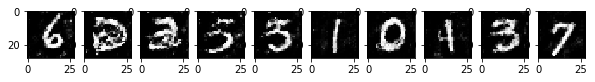

Epochs 9/10: Generator Loss: 4.283. Discriminator Loss: 0.369
Epochs 9/10: Generator Loss: 4.427. Discriminator Loss: 0.365
Epochs 9/10: Generator Loss: 4.233. Discriminator Loss: 0.37
Epochs 9/10: Generator Loss: 4.299. Discriminator Loss: 0.38
Epochs 9/10: Generator Loss: 4.158. Discriminator Loss: 0.435
Epochs 9/10: Generator Loss: 4.145. Discriminator Loss: 0.379
Epochs 9/10: Generator Loss: 4.501. Discriminator Loss: 0.366
Epochs 9/10: Generator Loss: 4.665. Discriminator Loss: 0.347
Epochs 9/10: Generator Loss: 4.576. Discriminator Loss: 0.365
Epochs 9/10: Generator Loss: 4.296. Discriminator Loss: 0.362


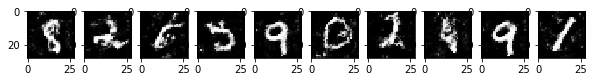

Epochs 9/10: Generator Loss: 4.606. Discriminator Loss: 0.346
Epochs 9/10: Generator Loss: 4.421. Discriminator Loss: 0.553
Epochs 9/10: Generator Loss: 4.27. Discriminator Loss: 0.368
Epochs 9/10: Generator Loss: 4.161. Discriminator Loss: 0.384
Epochs 9/10: Generator Loss: 4.234. Discriminator Loss: 0.378
Epochs 9/10: Generator Loss: 4.436. Discriminator Loss: 0.391
Epochs 9/10: Generator Loss: 4.159. Discriminator Loss: 0.376
Epochs 9/10: Generator Loss: 4.182. Discriminator Loss: 0.367
Epochs 9/10: Generator Loss: 4.453. Discriminator Loss: 0.37
Epochs 9/10: Generator Loss: 4.401. Discriminator Loss: 0.345


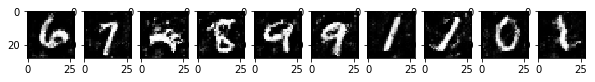

Epochs 9/10: Generator Loss: 3.981. Discriminator Loss: 0.392
Epochs 9/10: Generator Loss: 4.218. Discriminator Loss: 0.388
Epochs 9/10: Generator Loss: 4.193. Discriminator Loss: 0.353
Epochs 9/10: Generator Loss: 4.372. Discriminator Loss: 0.364
Epochs 9/10: Generator Loss: 4.161. Discriminator Loss: 0.354
Epochs 9/10: Generator Loss: 4.322. Discriminator Loss: 0.354
Epochs 9/10: Generator Loss: 3.782. Discriminator Loss: 0.414
Epochs 9/10: Generator Loss: 4.124. Discriminator Loss: 0.375
Epochs 9/10: Generator Loss: 4.186. Discriminator Loss: 0.423
Epochs 9/10: Generator Loss: 4.219. Discriminator Loss: 0.466


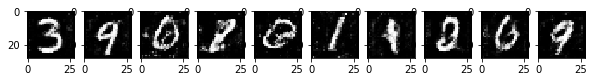

Epochs 9/10: Generator Loss: 4.045. Discriminator Loss: 0.362
Epochs 9/10: Generator Loss: 4.454. Discriminator Loss: 0.343
Epochs 9/10: Generator Loss: 4.371. Discriminator Loss: 0.377
Epochs 9/10: Generator Loss: 4.409. Discriminator Loss: 0.425
Epochs 9/10: Generator Loss: 4.358. Discriminator Loss: 0.38
Epochs 9/10: Generator Loss: 4.347. Discriminator Loss: 0.383
Epochs 9/10: Generator Loss: 4.343. Discriminator Loss: 0.415
Epochs 9/10: Generator Loss: 4.099. Discriminator Loss: 0.362
Epochs 9/10: Generator Loss: 4.296. Discriminator Loss: 0.368
Epochs 9/10: Generator Loss: 4.378. Discriminator Loss: 0.359


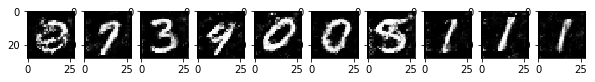

Epochs 9/10: Generator Loss: 4.1. Discriminator Loss: 0.357
Epochs 9/10: Generator Loss: 4.245. Discriminator Loss: 0.375
Epochs 9/10: Generator Loss: 4.479. Discriminator Loss: 0.449
Epochs 9/10: Generator Loss: 3.952. Discriminator Loss: 0.361
Epochs 9/10: Generator Loss: 4.47. Discriminator Loss: 0.347
Epochs 9/10: Generator Loss: 4.254. Discriminator Loss: 0.359
Epochs 9/10: Generator Loss: 4.284. Discriminator Loss: 0.385
Epochs 9/10: Generator Loss: 4.288. Discriminator Loss: 0.353
Epochs 9/10: Generator Loss: 4.336. Discriminator Loss: 0.37
Epochs 9/10: Generator Loss: 4.472. Discriminator Loss: 0.364


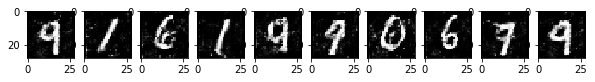

Epochs 9/10: Generator Loss: 4.359. Discriminator Loss: 0.37
Epochs 9/10: Generator Loss: 4.474. Discriminator Loss: 0.385
Epochs 9/10: Generator Loss: 4.388. Discriminator Loss: 0.35
Epochs 9/10: Generator Loss: 4.444. Discriminator Loss: 0.36
Epochs 9/10: Generator Loss: 4.157. Discriminator Loss: 0.363
Epochs 9/10: Generator Loss: 4.357. Discriminator Loss: 0.345
Epochs 9/10: Generator Loss: 4.253. Discriminator Loss: 0.391
Epochs 9/10: Generator Loss: 4.356. Discriminator Loss: 0.346
Epochs 9/10: Generator Loss: 3.985. Discriminator Loss: 0.494
Epochs 9/10: Generator Loss: 4.531. Discriminator Loss: 0.371


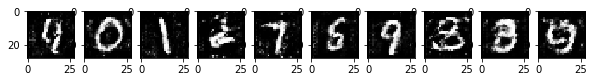

Epochs 9/10: Generator Loss: 4.317. Discriminator Loss: 0.375
Epochs 9/10: Generator Loss: 4.1. Discriminator Loss: 0.504
Epochs 9/10: Generator Loss: 4.257. Discriminator Loss: 0.373
Epochs 9/10: Generator Loss: 4.389. Discriminator Loss: 0.353
Epochs 9/10: Generator Loss: 4.276. Discriminator Loss: 0.378
Epochs 9/10: Generator Loss: 4.506. Discriminator Loss: 0.363
Epochs 9/10: Generator Loss: 4.493. Discriminator Loss: 0.374
Epochs 9/10: Generator Loss: 4.311. Discriminator Loss: 0.38
Epochs 9/10: Generator Loss: 4.524. Discriminator Loss: 0.37
Epochs 9/10: Generator Loss: 4.276. Discriminator Loss: 0.348


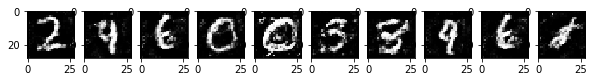

Epochs 9/10: Generator Loss: 4.649. Discriminator Loss: 0.356
Epochs 9/10: Generator Loss: 4.286. Discriminator Loss: 0.395
Epochs 9/10: Generator Loss: 4.352. Discriminator Loss: 0.352
Epochs 9/10: Generator Loss: 4.346. Discriminator Loss: 0.348
Epochs 9/10: Generator Loss: 4.396. Discriminator Loss: 0.361
Epochs 9/10: Generator Loss: 3.931. Discriminator Loss: 0.366
Epochs 9/10: Generator Loss: 4.254. Discriminator Loss: 0.357
Epochs 9/10: Generator Loss: 4.322. Discriminator Loss: 0.369
Epochs 9/10: Generator Loss: 4.276. Discriminator Loss: 0.395
Epochs 9/10: Generator Loss: 4.347. Discriminator Loss: 0.355


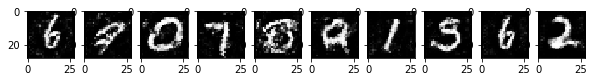

Epochs 9/10: Generator Loss: 4.337. Discriminator Loss: 0.391
Epochs 9/10: Generator Loss: 4.358. Discriminator Loss: 0.348
Epochs 9/10: Generator Loss: 4.344. Discriminator Loss: 0.358
Epochs 9/10: Generator Loss: 4.252. Discriminator Loss: 0.382
Epochs 9/10: Generator Loss: 4.289. Discriminator Loss: 0.421
Epochs 9/10: Generator Loss: 4.097. Discriminator Loss: 0.381
Epochs 9/10: Generator Loss: 4.399. Discriminator Loss: 0.379
Epochs 9/10: Generator Loss: 4.43. Discriminator Loss: 0.36
Epochs 9/10: Generator Loss: 4.357. Discriminator Loss: 0.401
Epochs 9/10: Generator Loss: 4.372. Discriminator Loss: 0.404


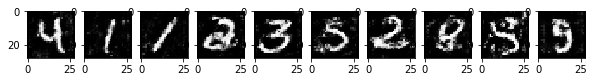

Epochs 9/10: Generator Loss: 4.213. Discriminator Loss: 0.35
Epochs 9/10: Generator Loss: 4.329. Discriminator Loss: 0.367
Epochs 9/10: Generator Loss: 4.322. Discriminator Loss: 0.416
Epochs 9/10: Generator Loss: 4.187. Discriminator Loss: 0.407
Epochs 9/10: Generator Loss: 4.511. Discriminator Loss: 0.358
Epochs 9/10: Generator Loss: 4.255. Discriminator Loss: 0.387
Epochs 9/10: Generator Loss: 4.4. Discriminator Loss: 0.416
Epochs 9/10: Generator Loss: 4.34. Discriminator Loss: 0.355
Epochs 9/10: Generator Loss: 4.325. Discriminator Loss: 0.359
Epochs 9/10: Generator Loss: 4.313. Discriminator Loss: 0.367


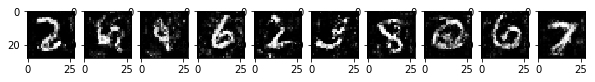

Epochs 9/10: Generator Loss: 4.581. Discriminator Loss: 0.358
Epochs 9/10: Generator Loss: 4.493. Discriminator Loss: 0.355
Epochs 9/10: Generator Loss: 4.457. Discriminator Loss: 0.36
Epochs 9/10: Generator Loss: 4.408. Discriminator Loss: 0.358
Epochs 10/10: Generator Loss: 3.99. Discriminator Loss: 0.54
Epochs 10/10: Generator Loss: 4.093. Discriminator Loss: 0.361
Epochs 10/10: Generator Loss: 4.398. Discriminator Loss: 0.346
Epochs 10/10: Generator Loss: 4.39. Discriminator Loss: 0.354
Epochs 10/10: Generator Loss: 4.395. Discriminator Loss: 0.357
Epochs 10/10: Generator Loss: 4.338. Discriminator Loss: 0.369


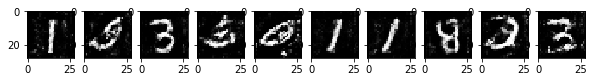

Epochs 10/10: Generator Loss: 4.479. Discriminator Loss: 0.374
Epochs 10/10: Generator Loss: 4.34. Discriminator Loss: 0.384
Epochs 10/10: Generator Loss: 4.592. Discriminator Loss: 0.355
Epochs 10/10: Generator Loss: 4.399. Discriminator Loss: 0.407
Epochs 10/10: Generator Loss: 4.245. Discriminator Loss: 0.372
Epochs 10/10: Generator Loss: 4.307. Discriminator Loss: 0.394
Epochs 10/10: Generator Loss: 4.605. Discriminator Loss: 0.442
Epochs 10/10: Generator Loss: 4.323. Discriminator Loss: 0.395
Epochs 10/10: Generator Loss: 4.54. Discriminator Loss: 0.347
Epochs 10/10: Generator Loss: 4.588. Discriminator Loss: 0.36


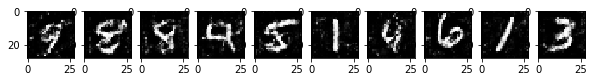

Epochs 10/10: Generator Loss: 4.326. Discriminator Loss: 0.353
Epochs 10/10: Generator Loss: 4.464. Discriminator Loss: 0.346
Epochs 10/10: Generator Loss: 4.457. Discriminator Loss: 0.378
Epochs 10/10: Generator Loss: 4.456. Discriminator Loss: 0.375
Epochs 10/10: Generator Loss: 4.167. Discriminator Loss: 0.388
Epochs 10/10: Generator Loss: 4.751. Discriminator Loss: 0.347
Epochs 10/10: Generator Loss: 4.533. Discriminator Loss: 0.364
Epochs 10/10: Generator Loss: 4.468. Discriminator Loss: 0.356
Epochs 10/10: Generator Loss: 4.341. Discriminator Loss: 0.359
Epochs 10/10: Generator Loss: 4.376. Discriminator Loss: 0.346


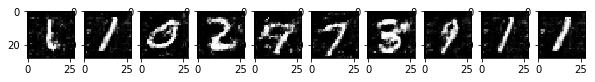

Epochs 10/10: Generator Loss: 4.507. Discriminator Loss: 0.341
Epochs 10/10: Generator Loss: 4.387. Discriminator Loss: 0.355
Epochs 10/10: Generator Loss: 4.389. Discriminator Loss: 0.392
Epochs 10/10: Generator Loss: 4.617. Discriminator Loss: 0.353
Epochs 10/10: Generator Loss: 4.522. Discriminator Loss: 0.384
Epochs 10/10: Generator Loss: 4.686. Discriminator Loss: 0.354
Epochs 10/10: Generator Loss: 4.307. Discriminator Loss: 0.379
Epochs 10/10: Generator Loss: 4.331. Discriminator Loss: 0.352
Epochs 10/10: Generator Loss: 4.433. Discriminator Loss: 0.369
Epochs 10/10: Generator Loss: 4.299. Discriminator Loss: 0.392


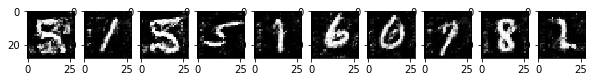

Epochs 10/10: Generator Loss: 4.599. Discriminator Loss: 0.349
Epochs 10/10: Generator Loss: 4.497. Discriminator Loss: 0.425
Epochs 10/10: Generator Loss: 4.56. Discriminator Loss: 0.349
Epochs 10/10: Generator Loss: 4.311. Discriminator Loss: 0.43
Epochs 10/10: Generator Loss: 4.702. Discriminator Loss: 0.36
Epochs 10/10: Generator Loss: 4.383. Discriminator Loss: 0.418
Epochs 10/10: Generator Loss: 4.189. Discriminator Loss: 0.392
Epochs 10/10: Generator Loss: 4.393. Discriminator Loss: 0.345
Epochs 10/10: Generator Loss: 4.076. Discriminator Loss: 0.695
Epochs 10/10: Generator Loss: 4.379. Discriminator Loss: 0.423


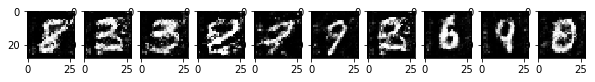

Epochs 10/10: Generator Loss: 4.694. Discriminator Loss: 0.508
Epochs 10/10: Generator Loss: 4.649. Discriminator Loss: 0.362
Epochs 10/10: Generator Loss: 4.429. Discriminator Loss: 0.397
Epochs 10/10: Generator Loss: 4.333. Discriminator Loss: 0.381
Epochs 10/10: Generator Loss: 4.375. Discriminator Loss: 0.366
Epochs 10/10: Generator Loss: 4.386. Discriminator Loss: 0.408
Epochs 10/10: Generator Loss: 4.278. Discriminator Loss: 0.373
Epochs 10/10: Generator Loss: 4.261. Discriminator Loss: 0.372
Epochs 10/10: Generator Loss: 4.368. Discriminator Loss: 0.35
Epochs 10/10: Generator Loss: 4.363. Discriminator Loss: 0.36


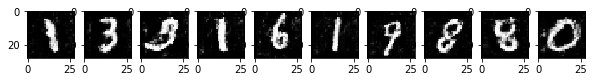

Epochs 10/10: Generator Loss: 4.313. Discriminator Loss: 0.36
Epochs 10/10: Generator Loss: 4.36. Discriminator Loss: 0.408
Epochs 10/10: Generator Loss: 4.36. Discriminator Loss: 0.371
Epochs 10/10: Generator Loss: 4.543. Discriminator Loss: 0.365
Epochs 10/10: Generator Loss: 4.13. Discriminator Loss: 0.37
Epochs 10/10: Generator Loss: 4.509. Discriminator Loss: 0.352
Epochs 10/10: Generator Loss: 4.504. Discriminator Loss: 0.377
Epochs 10/10: Generator Loss: 4.403. Discriminator Loss: 0.36
Epochs 10/10: Generator Loss: 4.055. Discriminator Loss: 0.493
Epochs 10/10: Generator Loss: 4.324. Discriminator Loss: 0.374


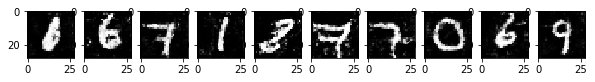

Epochs 10/10: Generator Loss: 4.377. Discriminator Loss: 0.369
Epochs 10/10: Generator Loss: 4.303. Discriminator Loss: 0.363
Epochs 10/10: Generator Loss: 4.797. Discriminator Loss: 0.342
Epochs 10/10: Generator Loss: 4.672. Discriminator Loss: 0.352
Epochs 10/10: Generator Loss: 4.442. Discriminator Loss: 0.351
Epochs 10/10: Generator Loss: 4.352. Discriminator Loss: 0.345
Epochs 10/10: Generator Loss: 4.073. Discriminator Loss: 0.357
Epochs 10/10: Generator Loss: 4.342. Discriminator Loss: 0.353
Epochs 10/10: Generator Loss: 4.423. Discriminator Loss: 0.365
Epochs 10/10: Generator Loss: 4.395. Discriminator Loss: 0.394


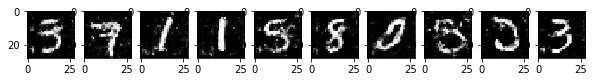

Epochs 10/10: Generator Loss: 4.188. Discriminator Loss: 0.594
Epochs 10/10: Generator Loss: 4.455. Discriminator Loss: 0.361
Epochs 10/10: Generator Loss: 4.636. Discriminator Loss: 0.345
Epochs 10/10: Generator Loss: 4.578. Discriminator Loss: 0.348
Epochs 10/10: Generator Loss: 4.223. Discriminator Loss: 0.389
Epochs 10/10: Generator Loss: 4.126. Discriminator Loss: 0.357
Epochs 10/10: Generator Loss: 4.216. Discriminator Loss: 0.347
Epochs 10/10: Generator Loss: 4.145. Discriminator Loss: 0.362
Epochs 10/10: Generator Loss: 4.397. Discriminator Loss: 0.406
Epochs 10/10: Generator Loss: 4.339. Discriminator Loss: 0.371


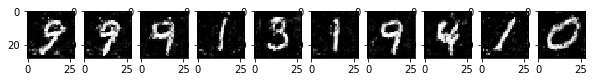

Epochs 10/10: Generator Loss: 4.415. Discriminator Loss: 0.347
Epochs 10/10: Generator Loss: 4.276. Discriminator Loss: 0.428
Epochs 10/10: Generator Loss: 4.361. Discriminator Loss: 0.396
Epochs 10/10: Generator Loss: 4.599. Discriminator Loss: 0.357
Epochs 10/10: Generator Loss: 4.45. Discriminator Loss: 0.356
Epochs 10/10: Generator Loss: 4.392. Discriminator Loss: 0.359
Epochs 10/10: Generator Loss: 4.193. Discriminator Loss: 0.412
Epochs 10/10: Generator Loss: 4.596. Discriminator Loss: 0.347
Epochs 10/10: Generator Loss: 4.659. Discriminator Loss: 0.341
Epochs 10/10: Generator Loss: 4.212. Discriminator Loss: 0.367


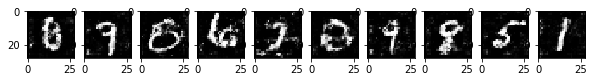

Epochs 10/10: Generator Loss: 4.322. Discriminator Loss: 0.38
Epochs 10/10: Generator Loss: 4.579. Discriminator Loss: 0.349
Epochs 10/10: Generator Loss: 4.605. Discriminator Loss: 0.375
Epochs 10/10: Generator Loss: 4.336. Discriminator Loss: 0.352
Epochs 10/10: Generator Loss: 4.329. Discriminator Loss: 0.354
Epochs 10/10: Generator Loss: 4.471. Discriminator Loss: 0.374
Epochs 10/10: Generator Loss: 4.564. Discriminator Loss: 0.363
Epochs 10/10: Generator Loss: 4.431. Discriminator Loss: 0.569
Epochs 10/10: Generator Loss: 4.389. Discriminator Loss: 0.361
Epochs 10/10: Generator Loss: 4.205. Discriminator Loss: 0.348


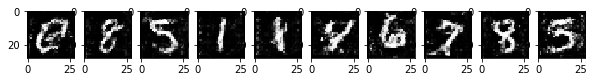

Epochs 10/10: Generator Loss: 4.185. Discriminator Loss: 0.375
Epochs 10/10: Generator Loss: 4.133. Discriminator Loss: 0.378
Epochs 10/10: Generator Loss: 4.316. Discriminator Loss: 0.369
Epochs 10/10: Generator Loss: 4.42. Discriminator Loss: 0.354
Epochs 10/10: Generator Loss: 4.284. Discriminator Loss: 0.358
Epochs 10/10: Generator Loss: 4.468. Discriminator Loss: 0.354
Epochs 10/10: Generator Loss: 4.732. Discriminator Loss: 0.374
Epochs 10/10: Generator Loss: 3.839. Discriminator Loss: 0.51
Epochs 10/10: Generator Loss: 4.503. Discriminator Loss: 0.364
Epochs 10/10: Generator Loss: 4.432. Discriminator Loss: 0.353


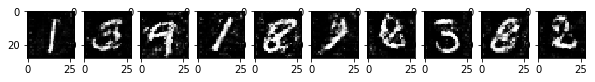

Epochs 10/10: Generator Loss: 4.227. Discriminator Loss: 0.37
Epochs 10/10: Generator Loss: 4.495. Discriminator Loss: 0.357
Epochs 10/10: Generator Loss: 4.494. Discriminator Loss: 0.36
Epochs 10/10: Generator Loss: 3.91. Discriminator Loss: 0.365
Epochs 10/10: Generator Loss: 4.433. Discriminator Loss: 0.359
Epochs 10/10: Generator Loss: 4.589. Discriminator Loss: 0.346
Epochs 10/10: Generator Loss: 4.243. Discriminator Loss: 0.391
Epochs 10/10: Generator Loss: 4.415. Discriminator Loss: 0.354
Epochs 10/10: Generator Loss: 4.497. Discriminator Loss: 0.363
Epochs 10/10: Generator Loss: 4.486. Discriminator Loss: 0.359


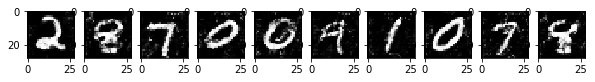

Epochs 10/10: Generator Loss: 4.301. Discriminator Loss: 0.351
Epochs 10/10: Generator Loss: 4.442. Discriminator Loss: 0.353
Epochs 10/10: Generator Loss: 4.409. Discriminator Loss: 0.566
Epochs 10/10: Generator Loss: 4.307. Discriminator Loss: 0.396
Epochs 10/10: Generator Loss: 4.415. Discriminator Loss: 0.364
Epochs 10/10: Generator Loss: 4.535. Discriminator Loss: 0.37
Epochs 10/10: Generator Loss: 4.495. Discriminator Loss: 0.382
Epochs 10/10: Generator Loss: 4.338. Discriminator Loss: 0.377
Epochs 10/10: Generator Loss: 4.422. Discriminator Loss: 0.356
Epochs 10/10: Generator Loss: 4.886. Discriminator Loss: 0.352


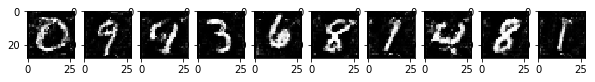

Epochs 10/10: Generator Loss: 4.343. Discriminator Loss: 0.354
Epochs 10/10: Generator Loss: 4.244. Discriminator Loss: 0.386
Epochs 10/10: Generator Loss: 4.357. Discriminator Loss: 0.352
Epochs 10/10: Generator Loss: 4.602. Discriminator Loss: 0.345
Epochs 10/10: Generator Loss: 4.563. Discriminator Loss: 0.361
Epochs 10/10: Generator Loss: 4.515. Discriminator Loss: 0.427
Epochs 10/10: Generator Loss: 4.458. Discriminator Loss: 0.352
Epochs 10/10: Generator Loss: 4.417. Discriminator Loss: 0.345
Epochs 10/10: Generator Loss: 4.728. Discriminator Loss: 0.401
Epochs 10/10: Generator Loss: 4.343. Discriminator Loss: 0.384


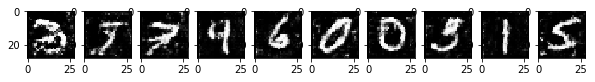

Epochs 10/10: Generator Loss: 4.349. Discriminator Loss: 0.379
Epochs 10/10: Generator Loss: 4.585. Discriminator Loss: 0.367
Epochs 10/10: Generator Loss: 4.157. Discriminator Loss: 0.428
Epochs 10/10: Generator Loss: 4.501. Discriminator Loss: 0.349
Epochs 10/10: Generator Loss: 4.672. Discriminator Loss: 0.348
Epochs 10/10: Generator Loss: 4.486. Discriminator Loss: 0.362
Epochs 10/10: Generator Loss: 4.611. Discriminator Loss: 0.361
Epochs 10/10: Generator Loss: 4.214. Discriminator Loss: 0.351
Epochs 10/10: Generator Loss: 4.527. Discriminator Loss: 0.352
Epochs 10/10: Generator Loss: 4.724. Discriminator Loss: 0.347


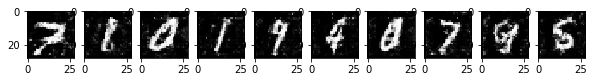

Epochs 10/10: Generator Loss: 4.789. Discriminator Loss: 0.342
Epochs 10/10: Generator Loss: 4.552. Discriminator Loss: 0.389
Epochs 10/10: Generator Loss: 4.447. Discriminator Loss: 0.348
Epochs 10/10: Generator Loss: 4.384. Discriminator Loss: 0.379
Epochs 10/10: Generator Loss: 4.389. Discriminator Loss: 0.362
Epochs 10/10: Generator Loss: 4.563. Discriminator Loss: 0.349
Epochs 10/10: Generator Loss: 4.463. Discriminator Loss: 0.389
Epochs 10/10: Generator Loss: 4.29. Discriminator Loss: 0.462
Epochs 10/10: Generator Loss: 4.512. Discriminator Loss: 0.35
Epochs 10/10: Generator Loss: 4.679. Discriminator Loss: 0.396


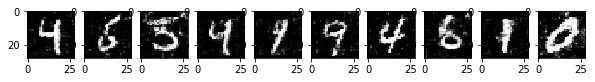

Epochs 10/10: Generator Loss: 4.421. Discriminator Loss: 0.429
Epochs 10/10: Generator Loss: 4.437. Discriminator Loss: 0.35
Epochs 10/10: Generator Loss: 4.571. Discriminator Loss: 0.359
Epochs 10/10: Generator Loss: 4.428. Discriminator Loss: 0.374
Epochs 10/10: Generator Loss: 4.459. Discriminator Loss: 0.347
Epochs 10/10: Generator Loss: 4.354. Discriminator Loss: 0.488
Epochs 10/10: Generator Loss: 4.737. Discriminator Loss: 0.361
Epochs 10/10: Generator Loss: 4.348. Discriminator Loss: 0.395
Epochs 10/10: Generator Loss: 4.678. Discriminator Loss: 0.363
Epochs 10/10: Generator Loss: 4.582. Discriminator Loss: 0.359


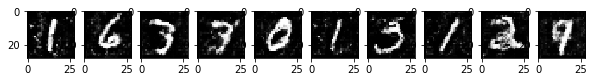

Epochs 10/10: Generator Loss: 4.619. Discriminator Loss: 0.343
Epochs 10/10: Generator Loss: 4.622. Discriminator Loss: 0.366
Epochs 10/10: Generator Loss: 4.558. Discriminator Loss: 0.441
Epochs 10/10: Generator Loss: 4.376. Discriminator Loss: 0.363
Epochs 10/10: Generator Loss: 4.202. Discriminator Loss: 0.444
Epochs 10/10: Generator Loss: 5.021. Discriminator Loss: 0.341
Epochs 10/10: Generator Loss: 4.331. Discriminator Loss: 0.362
Epochs 10/10: Generator Loss: 4.807. Discriminator Loss: 0.361
Epochs 10/10: Generator Loss: 4.383. Discriminator Loss: 0.358
Epochs 10/10: Generator Loss: 4.691. Discriminator Loss: 0.35


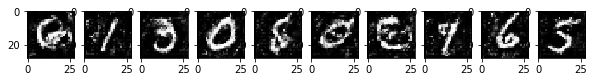

Epochs 10/10: Generator Loss: 4.428. Discriminator Loss: 0.352
Epochs 10/10: Generator Loss: 4.564. Discriminator Loss: 0.355


In [13]:
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
dataset = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

epochs = 10
batch_size = 32
z_dim = 100
learning_rate = 1e-4
beta1 = 0.5
image_type = 'gray'
alpha = 0.2

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, dataset, image_type, alpha)